
<div style="color:white; text-align:center; display:fill; 
            border-radius:12px; padding:10px; font-size:180%;
            font-weight:bold; letter-spacing:1.5px;
            background-color:#B5A8D5;
            background-image: url(https://i.imgur.com/GVd0La1.png)">
    Lung Nodule Detection & Analysis Pipeline
</div>

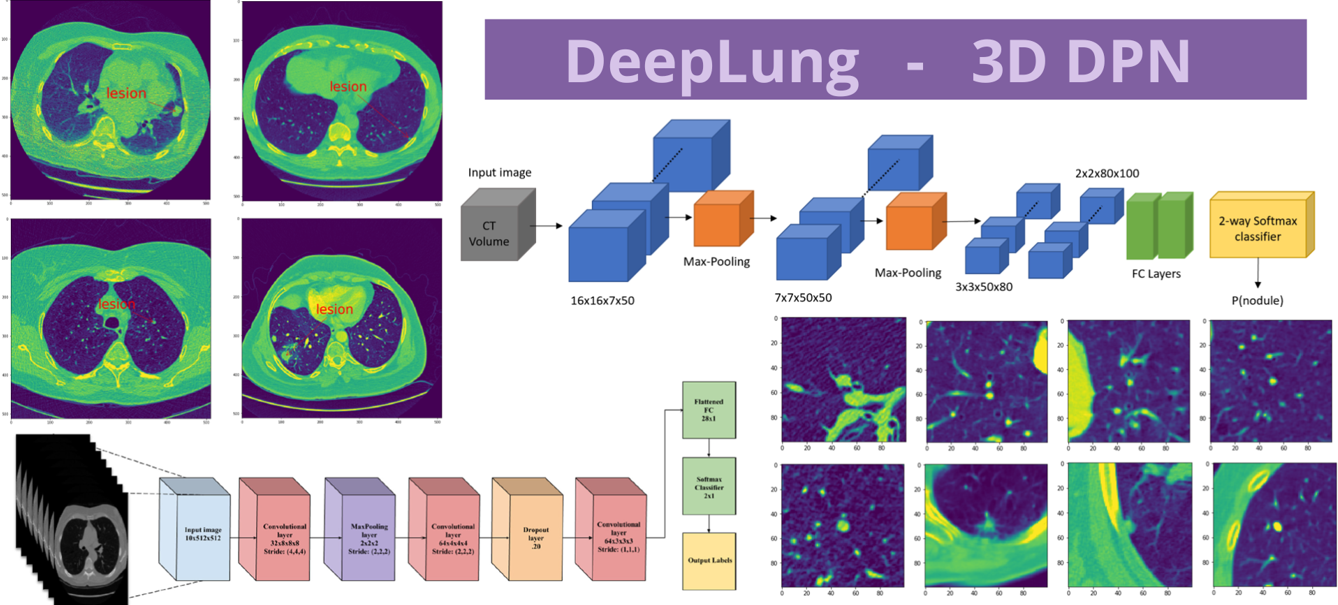



##  Introduction

This notebook implements a 3D Dual Path Network (DPN) based on the DeepLung framework presented in ["DeepLung: Deep 3D Dual Path Nets for Automated Pulmonary Nodule Detection and Classification"](https://arxiv.org/abs/1801.09555) by Zhu et al. The DeepLung system represents a significant advancement in automated lung CT cancer diagnosis through two primary components:

1. **Nodule Detection** 🔍 - A 3D Faster R-CNN architecture with 3D dual path blocks and a U-net-like encoder-decoder structure to effectively detect candidate nodules in CT scans.

2. **Nodule Classification** 🔬 - A deep 3D dual path network combined with gradient boosting machines (GBM) to classify detected nodules as benign or malignant.

📑 The core innovation lies in the implementation of 3D Dual Path Networks, which combine the advantages of:
- **Residual learning** for feature reuse
- **Dense connections** for exploiting new features

This architecture provides superior performance with fewer parameters compared to traditional 3D convolutional networks, making it computationally efficient while maintaining high accuracy. On benchmark datasets like LUNA16 and LIDC-IDRI, the DeepLung system demonstrated performance comparable to experienced radiologists in nodule detection and classification tasks.

## 🧪 Implementation Strategy

In this notebook, we focus on implementing the 3D DPN component, adapting it for our specific dataset while preserving the core architectural principles from the paper. Our implementation prioritizes:

- Efficient 3D feature extraction from volumetric CT data
- Compact model architecture to reduce computational overhead
- Scientifically justified preprocessing techniques for lung CT scans


# <b> 📌 <span style='color:#B5A8D5'>|</span> Project Summary </b>  
<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>1 |</span></b> Data Exploration</b></p>
</div>

- <b>1.1</b> Data Samples  
- <b>1.2</b> Advanced Data Analysis

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>2 |</span></b> Data Preprocessing</b></p>
</div>

- <b>2.1</b> Sample Scans (Before vs. After Preprocessing)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>3 |</span></b> 3D DPN Pipeline</b></p>
</div>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>4 |</span></b> Report Generation</b></p>
</div>

- <b>4.1</b> Generation Pipeline  
- <b>4.2</b> Sample Diagnostic Reports



# <b> ✨1 <span style='color:#B5A8D5'>|</span> Data Exploration  </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>1.1 |</span></b>  data samples </b></p>
</div>


In [ ]:
# 1. Imports et Configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from scipy.ndimage import zoom, binary_fill_holes
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
annotations = pd.read_csv("/kaggle/input/luna-16/LUNA_16/annotations.csv")
candidates = pd.read_csv("/kaggle/input/luna-16/LUNA_16/candidates_V2.csv")
dataset_path = "/kaggle/input/luna-16/LUNA_16"

In [4]:
annotations.head()


seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150

In [5]:
candidates.head()

seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>1.2 |</span></b>  data advanced analysis </b></p>
</div>


## 📊 Data Loading and Preparation

## 📋 Dataset Overview

### Annotations Dataset Summary

Attribute      Value
0            Rows      1,186
1         Columns          5
2    Memory Usage    0.17 MB
3  Missing Values  0 (0.00%)

count unique                                                top  \
seriesuid      1186    601  1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406...   
coordX       1186.0    NaN                                                NaN   
coordY       1186.0    NaN                                                NaN   
coordZ       1186.0    NaN                                                NaN   
diameter_mm  1186.0    NaN                                                NaN   

            freq        mean         std         min         25%        50%  \
seriesuid     12         NaN         NaN         NaN         NaN        NaN   
coordX       NaN   -5.067547   84.468115 -164.351031  -80.909225 -32.855132   
coordY       NaN    8.428113   98.316003 -283.834336  -51.549643  18.787926   
coordZ       NaN -160.159029  279.829437 -790.074799 -221.197808 -167.61516   
diameter_mm  NaN    8.306527    4.762033    3.253443    5.107177     6.4336   

                    75%          max  
seriesuid           NaN          NaN  
coordX        76.830069   164.763985  
coordY        67.245915   271.405521  
coordZ      -109.735281  1790.494057  
diameter_mm    9.696301     32.27003

Data Type  Count
0   float64      4
1    object      1

### Candidates Dataset Summary

Attribute      Value
0            Rows    754,975
1         Columns          5
2    Memory Usage  110.16 MB
3  Missing Values  0 (0.00%)

count unique                                                top  \
seriesuid    754975    888  1.3.6.1.4.1.14519.5.2.1.6279.6001.652347820272...   
coordX     754975.0    NaN                                                NaN   
coordY     754975.0    NaN                                                NaN   
coordZ     754975.0    NaN                                                NaN   
class      754975.0    NaN                                                NaN   

           freq        mean         std     min         25%     50%  \
seriesuid  2066         NaN         NaN     NaN         NaN     NaN   
coordX      NaN   -2.633154   71.215354 -187.77      -61.76  -17.34   
coordY      NaN    4.841814   92.676709 -321.63  -43.642962    16.6   
coordZ      NaN -158.963584  280.076072 -895.22 -226.550959 -172.73   
class       NaN    0.002062    0.045366     0.0         0.0     0.0   

                  75%          max  
seriesuid         NaN          NaN  
coordX          60.72    217.43329  
coordY      57.677198        294.5  
coordZ    -120.004883  1906.140031  
class             0.0          1.0

Data Type  Count
0   float64      3
1    object      1
2     int64      1

## 🔍 Missing Data Analysis

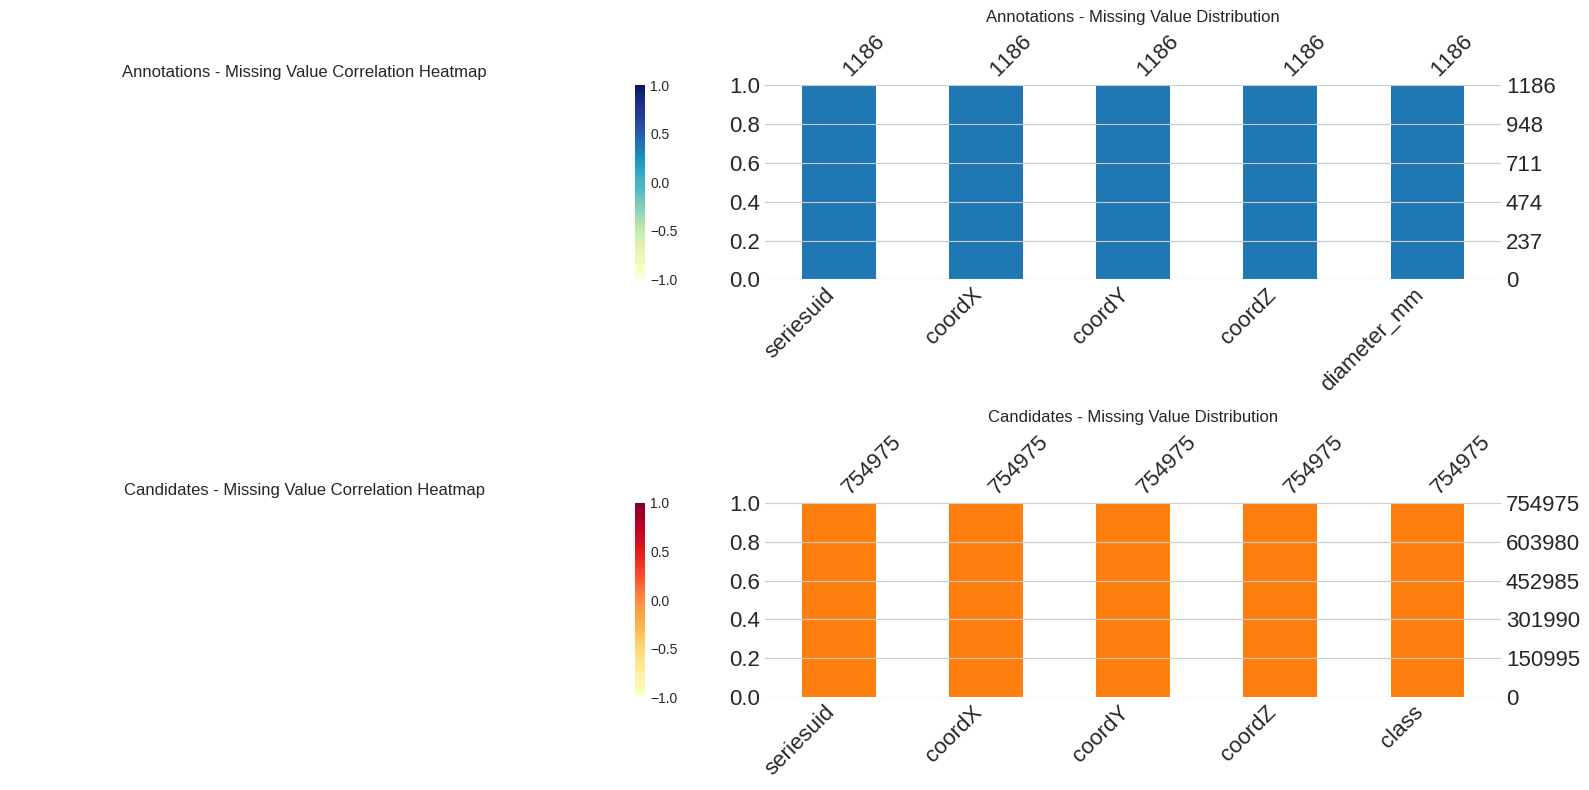

## 📊 Class Distribution Analysis

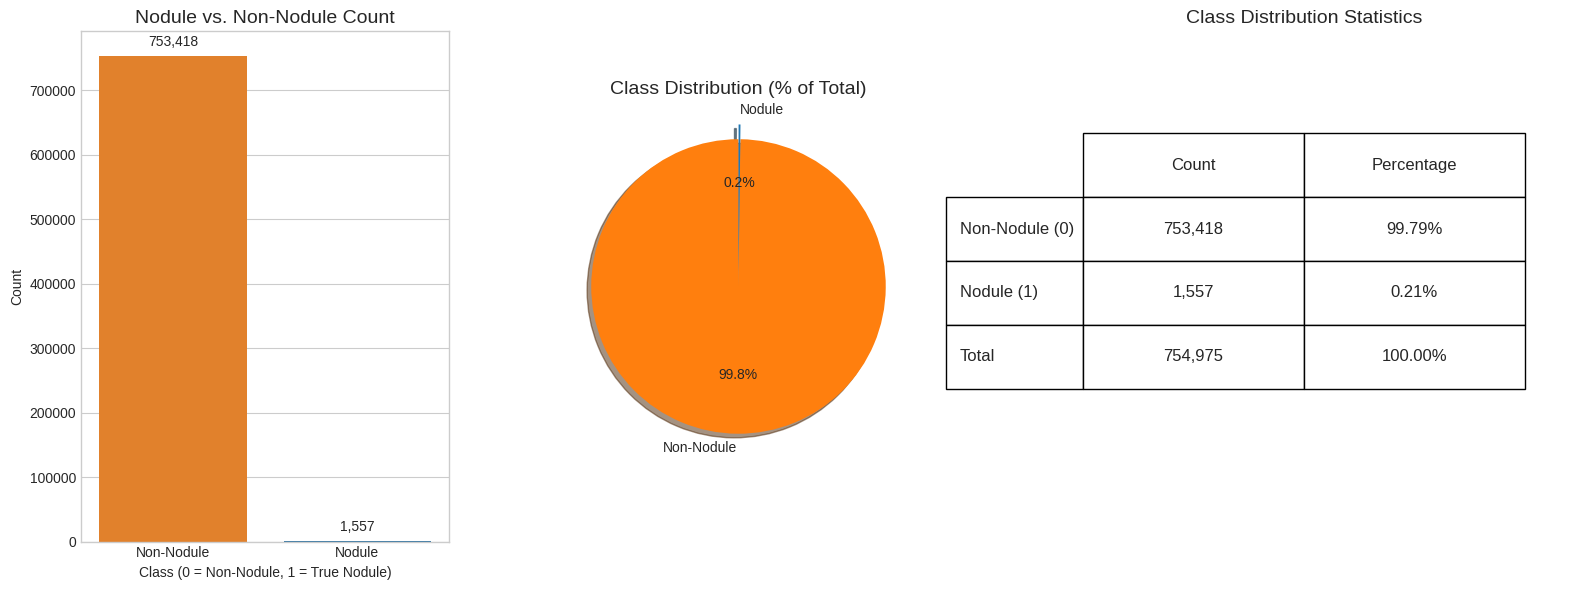

**Class Imbalance Ratio (Non-Nodule : Nodule)**: 483.89 : 1

## 📏 Nodule Size Analysis

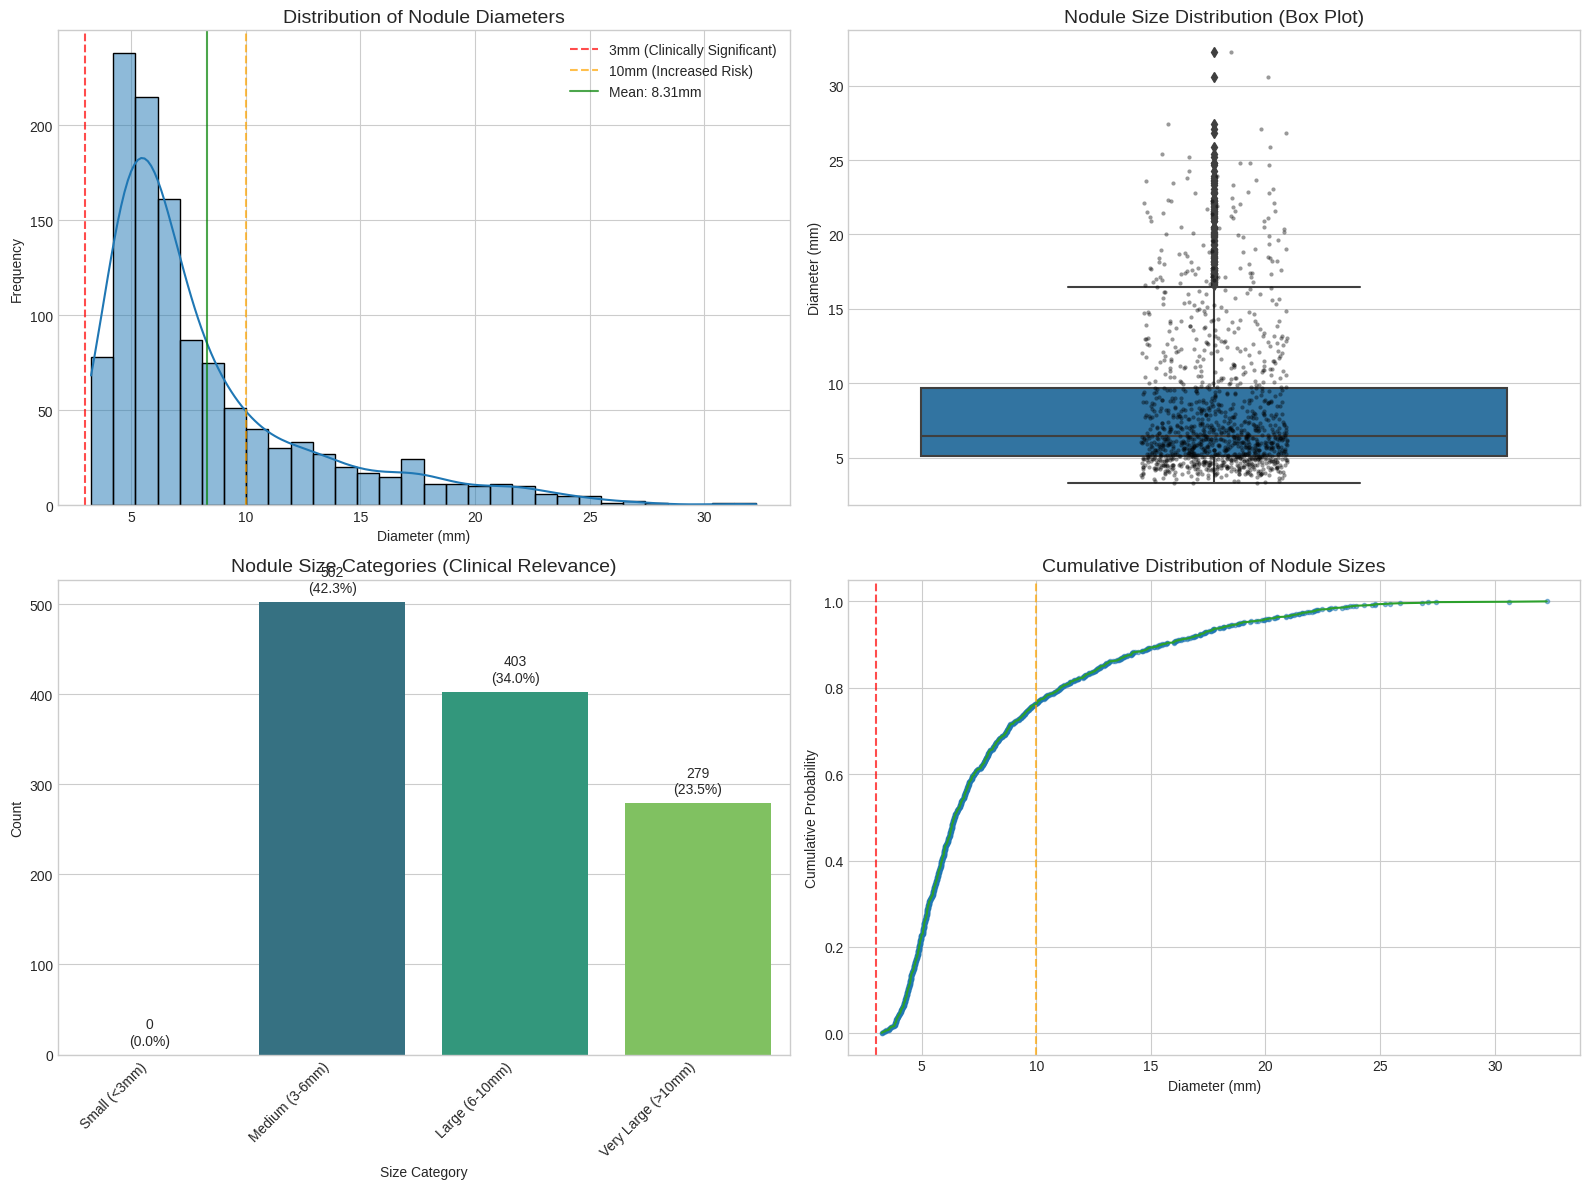

count      mean       std       min       25%     50%       75%  \
diameter_mm  1186.0  8.306527  4.762033  3.253443  5.107177  6.4336  9.696301   

                  max  skewness  kurtosis  
diameter_mm  32.27003  1.747964  2.847341

## 📍 Nodule Position Analysis

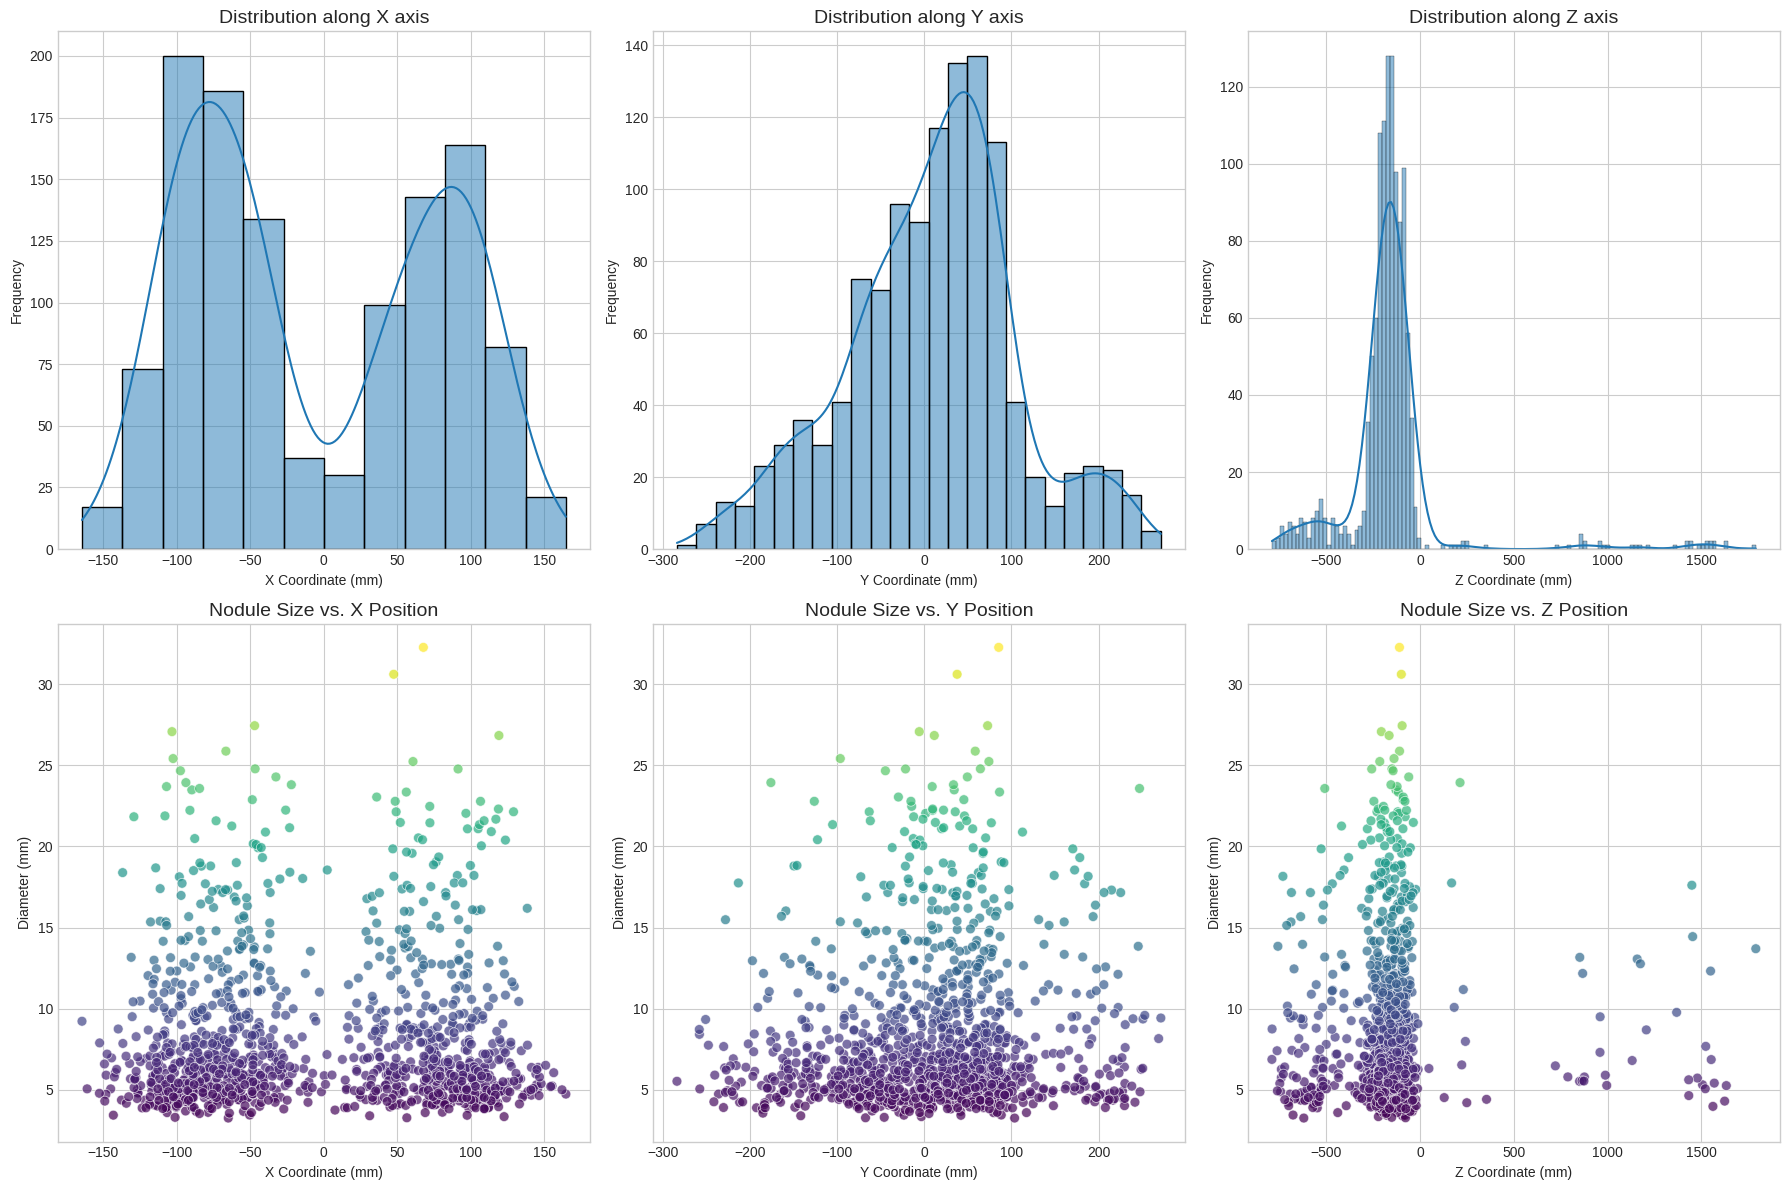

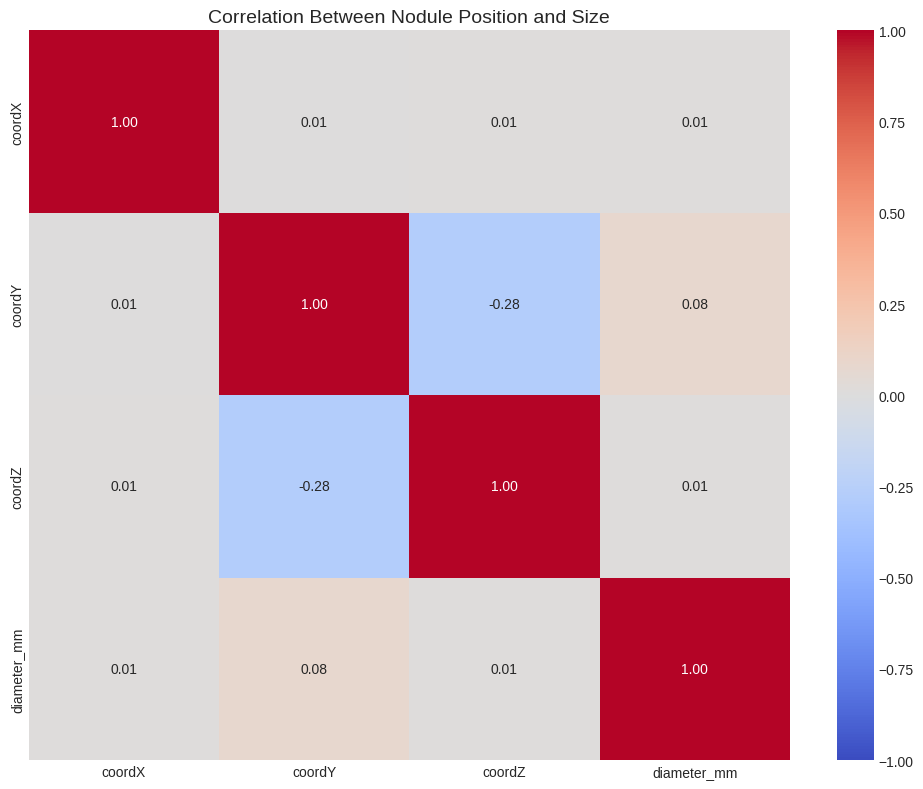

## 👤 Patient-Level Analysis

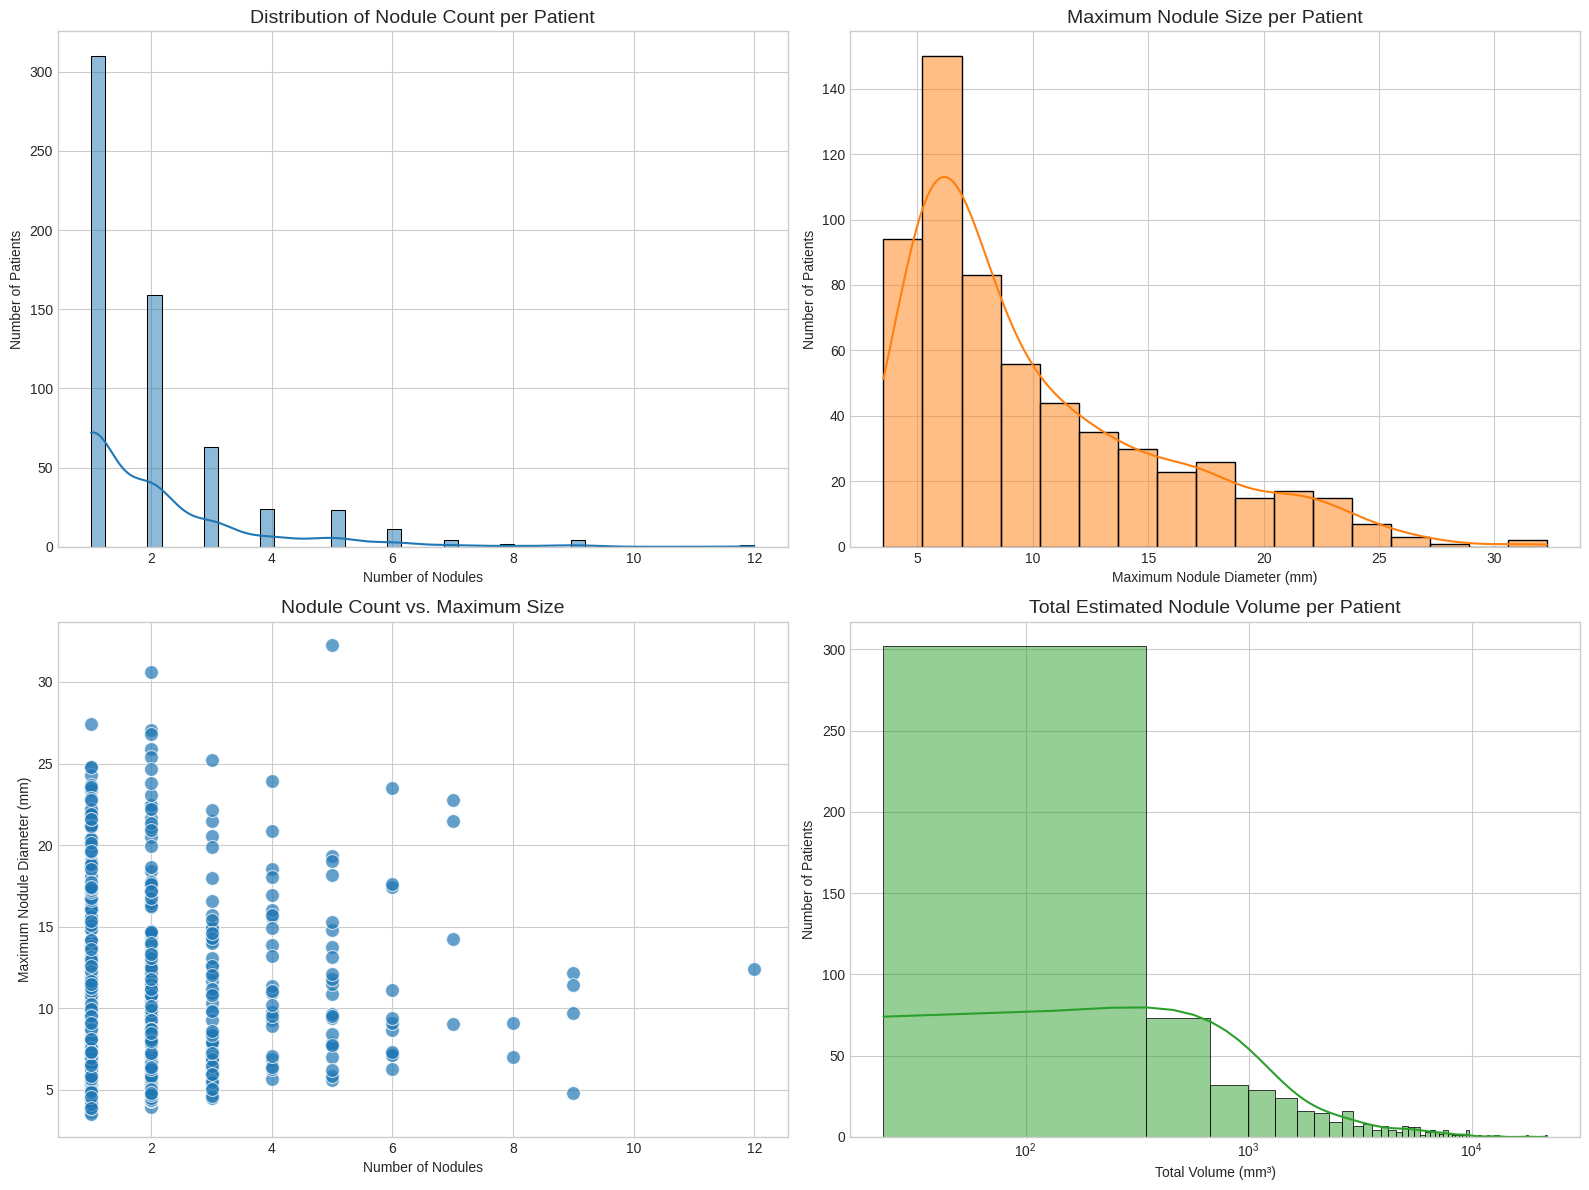

## 📑 Summary Statistics


**Dataset Dimensions:**
- **Annotations Dataset:** 1,186 rows × 6 columns
  - Represents 601 unique patients
  - Contains 1,186 confirmed nodules
  - Mean nodules per patient: 1.97

- **Candidates Dataset:** 754,975 rows × 5 columns
  - Contains 1,557 confirmed nodules (0.21% of candidates)
  - 753,418 false positives from initial detection
  - Class imbalance ratio: 483.89:1 (Non-nodule:Nodule)



**Key Findings:**

1. **Class Distribution:**
   - Significant class imbalance between nodules and non-nodules
   - This imbalance will require careful consideration during model training

2. **Nodule Size Distribution:**
   - Most nodules fall between 3-10mm in diameter
   - Median diameter is smaller than mean, indicating a right-skewed distribution
   - Presence of both very small (<3mm) and very large (>10mm) nodules

3. **Spatial Distribution:**
   - Nodules are distributed throughout the lung volume
   - No strong correlation between nodule position and size
   - Some clustering patterns may be present

4. **Patient-Level Analysis:**
   - Variable number of nodules per patient
   - Total nodule burden (volume) varies significantly across patients


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from IPython.display import display, Markdown
import numpy as np
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set consistent visualization style
plt.style.use('seaborn-v0_8-whitegrid')
colors = {'primary': '#1f77b4', 'secondary': '#ff7f0e', 'highlight': '#2ca02c'}

# Function to create standardized section headers
def section_header(title, level=2):
    """Create standardized section headers with proper markdown format"""
    prefix = "#" * level
    display(Markdown(f"{prefix} {title}"))

# Function to display dataset summary with improved formatting
def display_dataset_summary(df, name):
    """Display enhanced dataset summary with key statistics"""
    section_header(f"{name} Dataset Summary", level=3)
    
    # Basic info
    info_df = pd.DataFrame({
        'Attribute': ['Rows', 'Columns', 'Memory Usage', 'Missing Values'],
        'Value': [
            f"{df.shape[0]:,}",
            f"{df.shape[1]}",
            f"{df.memory_usage(deep=True).sum() / (1024**2):.2f} MB",
            f"{df.isna().sum().sum():,} ({df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%)"
        ]
    })
    
    display(info_df)
    
    # Display detailed statistics
    display(df.describe(include='all').T)
    
    # Display data types
    dtype_counts = df.dtypes.value_counts().reset_index()
    dtype_counts.columns = ['Data Type', 'Count']
    display(dtype_counts)

# Load datasets
section_header("📊 Data Loading and Preparation")
annotations = pd.read_csv("/kaggle/input/luna-16/LUNA_16/annotations.csv")
candidates = pd.read_csv("/kaggle/input/luna-16/LUNA_16/candidates_V2.csv")

# Display dataset summaries
section_header("📋 Dataset Overview")
display_dataset_summary(annotations, "Annotations")
display_dataset_summary(candidates, "Candidates")

# Missing value analysis
section_header("🔍 Missing Data Analysis")

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(hspace=0.4)

# Missing value heatmap for annotations
msno.heatmap(annotations, ax=axes[0, 0], cmap="YlGnBu")
axes[0, 0].set_title("Annotations - Missing Value Correlation Heatmap", fontsize=12)

# Missing value bar chart for annotations
msno.bar(annotations, ax=axes[0, 1], color=colors['primary'])
axes[0, 1].set_title("Annotations - Missing Value Distribution", fontsize=12)

# Missing value heatmap for candidates
msno.heatmap(candidates, ax=axes[1, 0], cmap="YlOrRd")
axes[1, 0].set_title("Candidates - Missing Value Correlation Heatmap", fontsize=12)

# Missing value bar chart for candidates
msno.bar(candidates, ax=axes[1, 1], color=colors['secondary'])
axes[1, 1].set_title("Candidates - Missing Value Distribution", fontsize=12)

plt.tight_layout()
plt.show()

# Class distribution analysis
section_header("📊 Class Distribution Analysis")

# Calculate class distribution
class_counts = candidates['class'].value_counts()
class_percentages = (class_counts / class_counts.sum() * 100).round(2)

# Create figure with two subplots
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1.5], figure=fig)

# Plot 1: Count plot
ax1 = fig.add_subplot(gs[0])
sns.countplot(data=candidates, x='class', palette=[colors['secondary'], colors['primary']], ax=ax1)
ax1.set_title("Nodule vs. Non-Nodule Count", fontsize=14)
ax1.set_xlabel("Class (0 = Non-Nodule, 1 = True Nodule)")
ax1.set_ylabel("Count")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Non-Nodule', 'Nodule'])

# Add count labels on bars
for i, count in enumerate(class_counts):
    ax1.annotate(f'{count:,}', 
                xy=(i, count), 
                xytext=(0, 5), 
                textcoords='offset points',
                ha='center', va='bottom')

# Plot 2: Pie chart
ax2 = fig.add_subplot(gs[1])
ax2.pie(class_counts, 
       labels=['Non-Nodule', 'Nodule'],
       autopct='%1.1f%%',
       colors=[colors['secondary'], colors['primary']],
       explode=[0, 0.1],
       shadow=True,
       startangle=90)
ax2.set_title("Class Distribution (% of Total)", fontsize=14)

# Plot 3: Table with detailed statistics
ax3 = fig.add_subplot(gs[2])
ax3.axis('off')
cell_text = [
    [f"{class_counts[0]:,}", f"{class_percentages[0]}%"],
    [f"{class_counts[1]:,}", f"{class_percentages[1]}%"],
    [f"{class_counts.sum():,}", "100.00%"]
]
table = ax3.table(cellText=cell_text,
                 rowLabels=['Non-Nodule (0)', 'Nodule (1)', 'Total'],
                 colLabels=['Count', 'Percentage'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0.1, 0.3, 0.8, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)
ax3.set_title("Class Distribution Statistics", fontsize=14)

plt.tight_layout()
plt.show()

# Calculate class imbalance ratio
imbalance_ratio = class_counts[0] / class_counts[1]
display(Markdown(f"**Class Imbalance Ratio (Non-Nodule : Nodule)**: {imbalance_ratio:.2f} : 1"))

# Nodule size analysis
section_header("📏 Nodule Size Analysis")

# Create figure with multiple plots for nodule diameter analysis
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, figure=fig)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot 1: Enhanced histogram with KDE
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(annotations['diameter_mm'], bins=30, kde=True, color=colors['primary'], ax=ax1)
ax1.set_title("Distribution of Nodule Diameters", fontsize=14)
ax1.set_xlabel("Diameter (mm)")
ax1.set_ylabel("Frequency")
# Add vertical lines for important clinical thresholds
ax1.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='3mm (Clinically Significant)')
ax1.axvline(x=10, color='orange', linestyle='--', alpha=0.7, label='10mm (Increased Risk)')
ax1.axvline(x=annotations['diameter_mm'].mean(), color='green', linestyle='-', alpha=0.7, 
            label=f'Mean: {annotations["diameter_mm"].mean():.2f}mm')
ax1.legend()

# Plot 2: Box plot with points
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(y=annotations['diameter_mm'], color=colors['primary'], ax=ax2)
sns.stripplot(y=annotations['diameter_mm'], color='black', alpha=0.4, size=3, ax=ax2)
ax2.set_title("Nodule Size Distribution (Box Plot)", fontsize=14)
ax2.set_ylabel("Diameter (mm)")

# Plot 3: Diameter size categories
ax3 = fig.add_subplot(gs[1, 0])
# Create clinically relevant categories
bins = [0, 3, 6, 10, 30]
labels = ['Small (<3mm)', 'Medium (3-6mm)', 'Large (6-10mm)', 'Very Large (>10mm)']
annotations['size_category'] = pd.cut(annotations['diameter_mm'], bins=bins, labels=labels)
size_counts = annotations['size_category'].value_counts().sort_index()

sns.barplot(x=size_counts.index, y=size_counts.values, palette='viridis', ax=ax3)
ax3.set_title("Nodule Size Categories (Clinical Relevance)", fontsize=14)
ax3.set_xlabel("Size Category")
ax3.set_ylabel("Count")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
# Add count labels
for i, count in enumerate(size_counts):
    ax3.annotate(f'{count}\n({count/len(annotations)*100:.1f}%)', 
                xy=(i, count), 
                xytext=(0, 5), 
                textcoords='offset points',
                ha='center', va='bottom')

# Plot 4: Cumulative distribution
ax4 = fig.add_subplot(gs[1, 1])
# Calculate ECDF
diameters = np.sort(annotations['diameter_mm'])
ecdf = np.arange(1, len(diameters) + 1) / len(diameters)
ax4.plot(diameters, ecdf, marker='.', linestyle='none', alpha=0.5, color=colors['primary'])
ax4.plot(diameters, ecdf, linestyle='-', color=colors['highlight'])
ax4.set_title("Cumulative Distribution of Nodule Sizes", fontsize=14)
ax4.set_xlabel("Diameter (mm)")
ax4.set_ylabel("Cumulative Probability")
# Add references for clinical thresholds
ax4.axvline(x=3, color='red', linestyle='--', alpha=0.7)
ax4.axvline(x=10, color='orange', linestyle='--', alpha=0.7)
ax4.grid(True)

plt.tight_layout()
plt.show()

# Display statistical summary of nodule sizes
nodule_stats = annotations['diameter_mm'].describe()
nodule_stats['skewness'] = annotations['diameter_mm'].skew()
nodule_stats['kurtosis'] = annotations['diameter_mm'].kurtosis()
display(pd.DataFrame(nodule_stats).T)


# Perform a positional analysis of nodules
section_header("📍 Nodule Position Analysis")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot distributions along each axis
for i, coord in enumerate(['coordX', 'coordY', 'coordZ']):
    # Histogram for each axis
    sns.histplot(annotations[coord], kde=True, ax=axes[0, i], color=colors['primary'])
    axes[0, i].set_title(f"Distribution along {coord[-1]} axis", fontsize=14)
    axes[0, i].set_xlabel(f"{coord[-1]} Coordinate (mm)")
    axes[0, i].set_ylabel("Frequency")
    
    # Scatterplot of position vs. diameter
    sns.scatterplot(
        x=annotations[coord], 
        y=annotations['diameter_mm'],
        hue=annotations['diameter_mm'],
        palette='viridis',
        s=50,
        alpha=0.7,
        ax=axes[1, i]
    )
    axes[1, i].set_title(f"Nodule Size vs. {coord[-1]} Position", fontsize=14)
    axes[1, i].set_xlabel(f"{coord[-1]} Coordinate (mm)")
    axes[1, i].set_ylabel("Diameter (mm)")
    axes[1, i].legend([],[], frameon=False)

plt.tight_layout()
plt.show()

# Calculate positional correlations
position_correlations = annotations[['coordX', 'coordY', 'coordZ', 'diameter_mm']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(position_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Between Nodule Position and Size", fontsize=14)
plt.tight_layout()
plt.show()

# Patient-level analysis
section_header("👤 Patient-Level Analysis")

# Group data by patient (seriesuid)
patient_counts = annotations.groupby('seriesuid').size().reset_index(name='nodule_count')
patient_stats = annotations.groupby('seriesuid')['diameter_mm'].agg(['min', 'max', 'mean', 'median', 'sum']).reset_index()
patient_data = pd.merge(patient_counts, patient_stats, on='seriesuid')

# Plot patient-level metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot 1: Distribution of nodules per patient
sns.histplot(patient_counts['nodule_count'], kde=True, ax=axes[0, 0], color=colors['primary'])
axes[0, 0].set_title("Distribution of Nodule Count per Patient", fontsize=14)
axes[0, 0].set_xlabel("Number of Nodules")
axes[0, 0].set_ylabel("Number of Patients")

# Plot 2: Max nodule size distribution
sns.histplot(patient_stats['max'], kde=True, ax=axes[0, 1], color=colors['secondary'])
axes[0, 1].set_title("Maximum Nodule Size per Patient", fontsize=14)
axes[0, 1].set_xlabel("Maximum Nodule Diameter (mm)")
axes[0, 1].set_ylabel("Number of Patients")

# Plot 3: Nodule count vs. max size
sns.scatterplot(
    x='nodule_count', 
    y='max', 
    data=patient_data, 
    ax=axes[1, 0],
    color=colors['primary'],
    s=100,
    alpha=0.7
)
axes[1, 0].set_title("Nodule Count vs. Maximum Size", fontsize=14)
axes[1, 0].set_xlabel("Number of Nodules")
axes[1, 0].set_ylabel("Maximum Nodule Diameter (mm)")

# Plot 4: Total nodule volume approximation (assuming spherical nodules)
# V = (4/3) * π * r³, where r = diameter/2
patient_data['total_volume_mm3'] = patient_data.apply(
    lambda row: np.sum([(4/3) * np.pi * (d/2)**3 for d in 
                        annotations[annotations['seriesuid'] == row['seriesuid']]['diameter_mm']]),
    axis=1
)

sns.histplot(patient_data['total_volume_mm3'], kde=True, ax=axes[1, 1], color=colors['highlight'])
axes[1, 1].set_title("Total Estimated Nodule Volume per Patient", fontsize=14)
axes[1, 1].set_xlabel("Total Volume (mm³)")
axes[1, 1].set_ylabel("Number of Patients")
# Use log scale for better visualization of the distribution
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.show()

# Summary statistics
section_header("📑 Summary Statistics")

# Display final dataset shapes with additional context
display(Markdown(f"""
**Dataset Dimensions:**
- **Annotations Dataset:** {annotations.shape[0]:,} rows × {annotations.shape[1]} columns
  - Represents {len(annotations['seriesuid'].unique()):,} unique patients
  - Contains {len(annotations):,} confirmed nodules
  - Mean nodules per patient: {len(annotations)/len(annotations['seriesuid'].unique()):.2f}

- **Candidates Dataset:** {candidates.shape[0]:,} rows × {candidates.shape[1]} columns
  - Contains {candidates['class'].sum():,} confirmed nodules ({candidates['class'].mean()*100:.2f}% of candidates)
  - {candidates.shape[0] - candidates['class'].sum():,} false positives from initial detection
  - Class imbalance ratio: {imbalance_ratio:.2f}:1 (Non-nodule:Nodule)
"""))

# Summary of key findings
display(Markdown("""
**Key Findings:**

1. **Class Distribution:**
   - Significant class imbalance between nodules and non-nodules
   - This imbalance will require careful consideration during model training

2. **Nodule Size Distribution:**
   - Most nodules fall between 3-10mm in diameter
   - Median diameter is smaller than mean, indicating a right-skewed distribution
   - Presence of both very small (<3mm) and very large (>10mm) nodules

3. **Spatial Distribution:**
   - Nodules are distributed throughout the lung volume
   - No strong correlation between nodule position and size
   - Some clustering patterns may be present

4. **Patient-Level Analysis:**
   - Variable number of nodules per patient
   - Total nodule burden (volume) varies significantly across patients
"""))



# <b>📊 2 <span style='color:#B5A8D5'>|</span> Data Preprocessing  </b>



## **🛠️ Preprocessing Pipeline 🛠️**

1. **Load .raw CT scans**
   * Function: `load_raw_scan()`
   * Reads binary .raw files directly 
   * Reshapes data based on provided dimensions (default 512×512)
   * Handles variable slice depths automatically

2. **Lung segmentation per slice**
   * Function: `segment_lungs_slice()` and `segment_volume()`
   * Applies histogram equalization for better contrast
   * Uses Sobel edge detection to identify lung boundaries
   * Applies Otsu thresholding for binary segmentation
   * Fills holes in the binary mask using scipy's binary_fill_holes

3. **HU normalization [-1000, 400] ➔ [0,1]**
   * Function: `normalize_hu()`
   * Clips values to the clinically relevant range (-1000 to 400 HU)
   * Normalizes to [0,1] range for consistent processing

4. **Apply lung mask**
   * Multiplies normalized volume with binary lung mask
   * Isolates lung tissue and removes background structures

5. **Resize volumes to (128,128,128)**
   * Function: `resize_volume()`
   * Resamples the 3D volume to consistent dimensions
   * Uses scipy's zoom with linear interpolation for quality preservation

6. **Extract class information**
   * Function: `create_mapping_with_class_info()`
   * Analyzes candidates.csv to identify nodule status
   * Determines class label (nodule/non-nodule) for each scan
   * Stores nodule coordinates and counts for potential region-based analysis

7. **Save processed data**
   * Saves volumes as .npz files with class information
   * Creates separate directories for nodule and non-nodule cases
   * Generates metadata CSV for training, validation, and testing












In [7]:
# 📦 Required Libraries
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import cv2
import random
from scipy.ndimage import zoom, binary_fill_holes
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import glob

# ====================================================
# 1. Load Scan from .raw directly
# ====================================================
def load_raw_scan(raw_path, shape=(512, 512, None), dtype=np.int16):
    file_size = os.path.getsize(raw_path)
    voxel_size = np.dtype(dtype).itemsize
    total_voxels = file_size // voxel_size

    if shape[2] is None:
        depth = total_voxels // (shape[0] * shape[1])
        full_shape = (depth, shape[1], shape[0])  # Z,Y,X
    else:
        full_shape = (shape[2], shape[1], shape[0])

    with open(raw_path, 'rb') as f:
        scan = np.frombuffer(f.read(), dtype=dtype)
    scan = scan.reshape(full_shape)
    return scan

# ====================================================
# 2. Preprocessing Functions
# ====================================================
def segment_lungs_slice(img):
    img = cv2.equalizeHist(img.astype(np.uint8))
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=3)
    _, binary = cv2.threshold(np.uint8(np.abs(sobel)), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = binary_fill_holes(binary).astype(np.uint8)
    return binary

def segment_volume(volume):
    segmented = np.array([segment_lungs_slice(slice) for slice in volume])
    return segmented

def normalize_hu(image, MIN=-1000, MAX=400):
    image = np.clip(image, MIN, MAX)
    normalized = (image - MIN) / (MAX - MIN)
    return normalized

def resize_volume(img, shape=(128, 128, 128)):
    factors = [shape[i] / img.shape[i] for i in range(3)]
    resized = zoom(img, factors, order=1)
    return resized

# ====================================================
# 3. Preprocess a Single Scan and Extract Class Info
# ====================================================
def preprocess_single_scan(raw_file, save_dir, scan_name, class_info, output_shape=(128,128,128), shape_hint=(512,512,None)):
    try:
        # Step 1: Load
        volume = load_raw_scan(raw_file, shape=shape_hint)
        print(f"📂 Loaded {scan_name} | Original shape: {volume.shape}")

        # Step 2: Segment lungs
        lung_mask = segment_volume(volume)

        # Step 3: Normalize
        normalized_volume = normalize_hu(volume)

        # Step 4: Apply Mask
        preprocessed_volume = normalized_volume * (lung_mask > 0)

        # Step 5: Resize
        resized_volume = resize_volume(preprocessed_volume, shape=output_shape)

        # Step 6: Save preprocessed scan with class info
        data_to_save = {
            'volume': resized_volume,
            'has_nodule': class_info['has_nodule'],
            'nodule_count': class_info['nodule_count'],
            'nodule_coordinates': class_info['nodule_coordinates']
        }
        
        save_path = os.path.join(save_dir, scan_name + ".npz")
        np.savez_compressed(save_path, **data_to_save)
        print(f"✅ Saved preprocessed scan with class info to {save_path}")
        
        # Step 7: Create a subdirectory for class organization (optional but helpful)
        class_subdir = os.path.join(save_dir, "nodule" if class_info['has_nodule'] else "non_nodule")
        if not os.path.exists(class_subdir):
            os.makedirs(class_subdir)
        
        # Save a copy in the class-specific directory as well
        class_save_path = os.path.join(class_subdir, scan_name + ".npz")
        np.savez_compressed(class_save_path, **data_to_save)

        # Cleanup
        del volume, lung_mask, normalized_volume, preprocessed_volume, resized_volume
        gc.collect()
        
        return True

    except Exception as e:
        print(f"❌ Error processing {scan_name}: {e}")
        return False

# ====================================================
# 4. Create enhanced mapping with class information
# ====================================================
def create_mapping_with_class_info(base_dir, candidates_csv, mapping_file="scan_info_mapping.csv"):
    """Create a mapping between seriesUIDs and folder names with class information"""
    print("🔄 Creating mapping between scans and class information...")
    
    # Load candidates with nodule locations
    candidates = pd.read_csv(candidates_csv)
    
    # Extract unique scan IDs
    unique_scans = candidates['seriesuid'].unique()
    print(f"📊 Found {len(unique_scans)} unique scans in candidates file")
    
    # Create a dictionary to hold scan information
    scan_info = {}
    
    # For each unique scan, determine if it has nodules and store coordinates
    for scan_id in unique_scans:
        scan_candidates = candidates[candidates['seriesuid'] == scan_id]
        positive_candidates = scan_candidates[scan_candidates['class'] == 1]
        
        # Store information about this scan
        scan_info[scan_id] = {
            'has_nodule': len(positive_candidates) > 0,
            'nodule_count': len(positive_candidates),
            'nodule_coordinates': [],
            'non_nodule_coordinates': []
        }
        
        # Store nodule coordinates
        if len(positive_candidates) > 0:
            for _, row in positive_candidates.iterrows():
                scan_info[scan_id]['nodule_coordinates'].append({
                    'x': row['coordX'],
                    'y': row['coordY'],
                    'z': row['coordZ'],
                    'diameter_mm': row['diameter_mm'] if 'diameter_mm' in row else None
                })
        
        # Store non-nodule coordinates for potential hard negative mining
        negative_candidates = scan_candidates[scan_candidates['class'] == 0]
        if len(negative_candidates) > 0:
            for _, row in negative_candidates.iterrows():
                scan_info[scan_id]['non_nodule_coordinates'].append({
                    'x': row['coordX'],
                    'y': row['coordY'],
                    'z': row['coordZ']
                })
    
    # Find all scan folders and establish linkage with seriesUIDs
    uid_to_folder = {}
    folder_to_info = {}
    
    for subset_folder in sorted(os.listdir(base_dir)):
        subset_path = os.path.join(base_dir, subset_folder)
        if not os.path.isdir(subset_path) or not subset_folder.startswith("subset"):
            continue
        
        for scan_folder in os.listdir(subset_path):
            scan_folder_path = os.path.join(subset_path, scan_folder)
            if not os.path.isdir(scan_folder_path):
                continue
            
            # Find .raw files in this folder
            raw_files = sorted([f for f in os.listdir(scan_folder_path) if f.endswith('.raw')])
            if not raw_files:
                continue
            
            # Match folder with scan ID
            # For LUNA16, folder names are usually the seriesuid
            if scan_folder in scan_info:
                uid = scan_folder
            else:
                # Try to find matching UID
                matching_uids = [uid for uid in scan_info.keys() if uid in scan_folder or scan_folder in uid]
                uid = matching_uids[0] if matching_uids else None
            
            if uid:
                uid_to_folder[uid] = {
                    'folder_id': scan_folder,
                    'folder_path': scan_folder_path,
                    'raw_file': os.path.join(scan_folder_path, raw_files[0])
                }
                
                # Link folder with class information
                folder_to_info[scan_folder] = {
                    'folder_path': scan_folder_path,
                    'raw_file': os.path.join(scan_folder_path, raw_files[0]),
                    'has_nodule': scan_info[uid]['has_nodule'],
                    'nodule_count': scan_info[uid]['nodule_count'],
                    'nodule_coordinates': scan_info[uid]['nodule_coordinates'],
                    'non_nodule_coordinates': scan_info[uid]['non_nodule_coordinates'],
                    'seriesuid': uid
                }
    
    # Save the enhanced mapping to a CSV file
    mapping_rows = []
    for folder_id, info in folder_to_info.items():
        mapping_rows.append({
            'folder_id': folder_id,
            'seriesuid': info['seriesuid'],
            'folder_path': info['folder_path'],
            'raw_file': info['raw_file'],
            'has_nodule': int(info['has_nodule']),
            'nodule_count': info['nodule_count']
        })
    
    mapping_df = pd.DataFrame(mapping_rows)
    mapping_df.to_csv(mapping_file, index=False)
    
    # Create a distribution report
    positive_scans = len(mapping_df[mapping_df['has_nodule'] == 1])
    negative_scans = len(mapping_df[mapping_df['has_nodule'] == 0])
    
    print(f"✅ Created enhanced mapping file: {mapping_file}")
    print(f"📊 Class distribution in dataset:")
    print(f"  - Scans with nodules (positive): {positive_scans} ({positive_scans/len(mapping_df)*100:.1f}%)")
    print(f"  - Scans without nodules (negative): {negative_scans} ({negative_scans/len(mapping_df)*100:.1f}%)")
    
    return folder_to_info

# ====================================================
# 5. Process All Scans with Class Information
# ====================================================
def process_all_scans(base_dir, output_dir, candidates_csv, output_shape=(128,128,128), shape_hint=(512,512,None)):
    """Process ALL scans with class information"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create class-specific directories
    nodule_dir = os.path.join(output_dir, "nodule")
    non_nodule_dir = os.path.join(output_dir, "non_nodule")
    
    for directory in [nodule_dir, non_nodule_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
    
    print("\n🔄 Processing ALL available CT scans with class information")
    
    # Step 1: Create enhanced mapping with class information
    folder_to_info = create_mapping_with_class_info(base_dir, candidates_csv)
    
    # Step 2: Process each scan with its class information
    processed_count = 0
    nodule_count = 0
    non_nodule_count = 0
    
    for folder_id, info in tqdm(folder_to_info.items(), desc="Preprocessing Scans with Class Info"):
        class_info = {
            'has_nodule': info['has_nodule'],
            'nodule_count': info['nodule_count'],
            'nodule_coordinates': info['nodule_coordinates']
        }
        
        success = preprocess_single_scan(
            info['raw_file'],
            output_dir,
            folder_id,
            class_info,
            output_shape=output_shape,
            shape_hint=shape_hint
        )
        
        if success:
            processed_count += 1
            if info['has_nodule']:
                nodule_count += 1
            else:
                non_nodule_count += 1
    
    # Create a summary file with dataset statistics
    summary_data = {
        'total_scans': processed_count,
        'nodule_scans': nodule_count,
        'non_nodule_scans': non_nodule_count,
        'nodule_percentage': nodule_count / processed_count * 100 if processed_count > 0 else 0,
        'output_shape': output_shape
    }
    
    with open(os.path.join(output_dir, 'dataset_summary.txt'), 'w') as f:
        f.write("LUNA16 Preprocessed Dataset Summary\n")
        f.write("=================================\n")
        f.write(f"Total processed scans: {summary_data['total_scans']}\n")
        f.write(f"Scans with nodules: {summary_data['nodule_scans']} ({summary_data['nodule_percentage']:.1f}%)\n")
        f.write(f"Scans without nodules: {summary_data['non_nodule_scans']} ({100-summary_data['nodule_percentage']:.1f}%)\n")
        f.write(f"Output volume shape: {output_shape}\n")
    
    # Create a metadata file for later use in modeling
    metadata_df = pd.DataFrame([
        {
            'scan_id': folder_id,
            'has_nodule': int(info['has_nodule']),
            'nodule_count': info['nodule_count'],
            'file_path': os.path.join(output_dir, "nodule" if info['has_nodule'] else "non_nodule", folder_id + ".npz")
        }
        for folder_id, info in folder_to_info.items()
    ])
    
    metadata_df.to_csv(os.path.join(output_dir, 'scan_metadata.csv'), index=False)
    
    print(f"🏁 Finished preprocessing {processed_count} scans with class information:")
    print(f"  - Scans with nodules: {nodule_count}")
    print(f"  - Scans without nodules: {non_nodule_count}")
    print(f"  - Metadata saved to: {os.path.join(output_dir, 'scan_metadata.csv')}")
    
    return processed_count

# ====================================================
# 6. Generate Dataset Split for Machine Learning
# ====================================================
def generate_dataset_split(output_dir, split_ratio=(0.7, 0.15, 0.15), seed=42):
    """Generate train/validation/test splits while maintaining class distribution"""
    metadata_file = os.path.join(output_dir, 'scan_metadata.csv')
    
    if not os.path.exists(metadata_file):
        print(f"❌ Metadata file not found: {metadata_file}")
        return False
    
    print("\n🔄 Generating dataset splits for machine learning...")
    
    # Load metadata
    metadata = pd.read_csv(metadata_file)
    
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Split positive and negative samples separately to maintain class distribution
    positive_samples = metadata[metadata['has_nodule'] == 1]
    negative_samples = metadata[metadata['has_nodule'] == 0]
    
    # Shuffle data
    positive_samples = positive_samples.sample(frac=1).reset_index(drop=True)
    negative_samples = negative_samples.sample(frac=1).reset_index(drop=True)
    
    # Calculate split indices
    pos_train_idx = int(len(positive_samples) * split_ratio[0])
    pos_val_idx = pos_train_idx + int(len(positive_samples) * split_ratio[1])
    
    neg_train_idx = int(len(negative_samples) * split_ratio[0])
    neg_val_idx = neg_train_idx + int(len(negative_samples) * split_ratio[1])
    
    # Create splits
    train_data = pd.concat([
        positive_samples[:pos_train_idx],
        negative_samples[:neg_train_idx]
    ]).sample(frac=1).reset_index(drop=True)
    
    val_data = pd.concat([
        positive_samples[pos_train_idx:pos_val_idx],
        negative_samples[neg_train_idx:neg_val_idx]
    ]).sample(frac=1).reset_index(drop=True)
    
    test_data = pd.concat([
        positive_samples[pos_val_idx:],
        negative_samples[neg_val_idx:]
    ]).sample(frac=1).reset_index(drop=True)
    
    # Save splits
    train_data.to_csv(os.path.join(output_dir, 'train_set.csv'), index=False)
    val_data.to_csv(os.path.join(output_dir, 'validation_set.csv'), index=False)
    test_data.to_csv(os.path.join(output_dir, 'test_set.csv'), index=False)
    
    # Print statistics
    print(f"✅ Dataset split created:")
    print(f"  - Training set: {len(train_data)} scans ({len(train_data[train_data['has_nodule'] == 1])} positive, {len(train_data[train_data['has_nodule'] == 0])} negative)")
    print(f"  - Validation set: {len(val_data)} scans ({len(val_data[val_data['has_nodule'] == 1])} positive, {len(val_data[val_data['has_nodule'] == 0])} negative)")
    print(f"  - Test set: {len(test_data)} scans ({len(test_data[test_data['has_nodule'] == 1])} positive, {len(test_data[test_data['has_nodule'] == 0])} negative)")
    
    return True

# ====================================================
# 7. Main Function
# ====================================================
def main():
    input_folder = "/kaggle/input/luna-16/LUNA_16"
    output_folder = "/kaggle/working/preprocessed_scans"
    candidates_csv = "/kaggle/input/luna-16/LUNA_16/candidates_V2.csv"
    
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Check candidates data
    try:
        candidates = pd.read_csv(candidates_csv)
        print("📊 Sample from candidates file:")
        print(candidates.head())
        print(f"Total candidates: {len(candidates)}")
        print(f"Class=1 candidates (nodules): {len(candidates[candidates['class'] == 1])}")
        print(f"Class=0 candidates (non-nodules): {len(candidates[candidates['class'] == 0])}")
        print(f"Unique scans: {len(candidates['seriesuid'].unique())}")
    except Exception as e:
        print(f"❌ Error reading candidates file: {e}")
        return
    
    # Process ALL scans in the dataset with class information
    process_count = process_all_scans(
        base_dir=input_folder,
        output_dir=output_folder,
        candidates_csv=candidates_csv,
        output_shape=(128,128,128),
        shape_hint=(512,512,None)
    )
    
    if process_count > 0:
        # Generate dataset splits for machine learning
        generate_dataset_split(output_folder)
    else:
        print("\n❌ No scans were processed. There might be an issue with the dataset structure.")
        
        # Final attempt: try to locate any raw files
        print("\n🔍 Last resort: looking for any .raw files in the dataset...")
        raw_files = []
        for root, dirs, files in os.walk(input_folder):
            for file in files:
                if file.endswith('.raw'):
                    raw_files.append(os.path.join(root, file))
                    if len(raw_files) <= 5:  # Just print the first few for debugging
                        print(f"  - Found: {os.path.join(root, file)}")
        
        print(f"Found {len(raw_files)} total .raw files.")
        if len(raw_files) > 0:
            print("Please verify these are the correct scan files and adapt the script accordingly.")

if __name__ == "__main__":
    main()

📊 Sample from candidates file:
                                           seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0  
Total candidates: 754975
Class=1 candidates (nodules): 1557
Class=0 candidates (non-nodules): 753418
Unique scans: 888

🔄 Processing ALL available CT scans with class information
🔄 Creating mapping between scans and class information...
📊 Found 888 unique scans in candidates file
✅ Created enhanced mapping file: scan_info_mapping.csv
📊 Class distribution

Preprocessing Scans with Class Info:   0%|          | 0/888 [00:00<?, ?it/s]

📂 Loaded 397062004302272014259317520874 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/397062004302272014259317520874.npz


Preprocessing Scans with Class Info:   0%|          | 1/888 [00:01<18:09,  1.23s/it]

📂 Loaded 202811684116768680758082619196 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/202811684116768680758082619196.npz


Preprocessing Scans with Class Info:   0%|          | 2/888 [00:02<19:27,  1.32s/it]

📂 Loaded 826812708000318290301835871780 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/826812708000318290301835871780.npz


Preprocessing Scans with Class Info:   0%|          | 3/888 [00:04<21:20,  1.45s/it]

📂 Loaded 249530219848512542668813996730 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/249530219848512542668813996730.npz


Preprocessing Scans with Class Info:   0%|          | 4/888 [00:05<22:15,  1.51s/it]

📂 Loaded 334517907433161353885866806005 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/334517907433161353885866806005.npz


Preprocessing Scans with Class Info:   1%|          | 5/888 [00:06<18:30,  1.26s/it]

📂 Loaded 805925269324902055566754756843 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/805925269324902055566754756843.npz


Preprocessing Scans with Class Info:   1%|          | 6/888 [00:08<19:49,  1.35s/it]

📂 Loaded 219909753224298157409438012179 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219909753224298157409438012179.npz


Preprocessing Scans with Class Info:   1%|          | 7/888 [00:09<17:52,  1.22s/it]

📂 Loaded 280972147860943609388015648430 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/280972147860943609388015648430.npz


Preprocessing Scans with Class Info:   1%|          | 8/888 [00:10<16:39,  1.14s/it]

📂 Loaded 898642529028521482602829374444 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/898642529028521482602829374444.npz


Preprocessing Scans with Class Info:   1%|          | 9/888 [00:11<17:35,  1.20s/it]

📂 Loaded 213140617640021803112060161074 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/213140617640021803112060161074.npz


Preprocessing Scans with Class Info:   1%|          | 10/888 [00:12<17:13,  1.18s/it]

📂 Loaded 752756872840730509471096155114 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/752756872840730509471096155114.npz


Preprocessing Scans with Class Info:   1%|          | 11/888 [00:13<16:24,  1.12s/it]

📂 Loaded 139713436241461669335487719526 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/139713436241461669335487719526.npz


Preprocessing Scans with Class Info:   1%|▏         | 12/888 [00:15<18:54,  1.30s/it]

📂 Loaded 716498695101447665580610403574 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/716498695101447665580610403574.npz


Preprocessing Scans with Class Info:   1%|▏         | 13/888 [00:16<19:06,  1.31s/it]

📂 Loaded 146429221666426688999739595820 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/146429221666426688999739595820.npz


Preprocessing Scans with Class Info:   2%|▏         | 14/888 [00:18<21:07,  1.45s/it]

📂 Loaded 219087313261026510628926082729 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219087313261026510628926082729.npz


Preprocessing Scans with Class Info:   2%|▏         | 15/888 [00:19<19:28,  1.34s/it]

📂 Loaded 278660284797073139172446973682 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/278660284797073139172446973682.npz


Preprocessing Scans with Class Info:   2%|▏         | 16/888 [00:20<19:59,  1.38s/it]

📂 Loaded 305858704835252413616501469037 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/305858704835252413616501469037.npz


Preprocessing Scans with Class Info:   2%|▏         | 17/888 [00:22<20:03,  1.38s/it]

📂 Loaded 269689294231892620436462818860 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/269689294231892620436462818860.npz


Preprocessing Scans with Class Info:   2%|▏         | 18/888 [00:23<21:12,  1.46s/it]

📂 Loaded 130438550890816550994739120843 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/130438550890816550994739120843.npz


Preprocessing Scans with Class Info:   2%|▏         | 19/888 [00:25<21:58,  1.52s/it]

📂 Loaded 141069661700670042960678408762 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/141069661700670042960678408762.npz


Preprocessing Scans with Class Info:   2%|▏         | 20/888 [00:26<18:31,  1.28s/it]

📂 Loaded 144438612068946916340281098509 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/144438612068946916340281098509.npz


Preprocessing Scans with Class Info:   2%|▏         | 21/888 [00:27<18:34,  1.29s/it]

📂 Loaded 105756658031515062000744821260 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/105756658031515062000744821260.npz


Preprocessing Scans with Class Info:   2%|▏         | 22/888 [00:29<20:09,  1.40s/it]

📂 Loaded 832260670372728970918746541371 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/832260670372728970918746541371.npz


Preprocessing Scans with Class Info:   3%|▎         | 23/888 [00:30<21:14,  1.47s/it]

📂 Loaded 227962600322799211676960828223 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/227962600322799211676960828223.npz


Preprocessing Scans with Class Info:   3%|▎         | 24/888 [00:32<20:37,  1.43s/it]

📂 Loaded 109002525524522225658609808059 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/109002525524522225658609808059.npz


Preprocessing Scans with Class Info:   3%|▎         | 25/888 [00:33<21:36,  1.50s/it]

📂 Loaded 979083010707182900091062408058 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/979083010707182900091062408058.npz


Preprocessing Scans with Class Info:   3%|▎         | 26/888 [00:35<22:00,  1.53s/it]

📂 Loaded 317087518531899043292346860596 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/317087518531899043292346860596.npz


Preprocessing Scans with Class Info:   3%|▎         | 27/888 [00:36<20:50,  1.45s/it]

📂 Loaded 188376349804761988217597754952 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188376349804761988217597754952.npz


Preprocessing Scans with Class Info:   3%|▎         | 28/888 [00:37<19:26,  1.36s/it]

📂 Loaded 905371958588660410240398317235 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/905371958588660410240398317235.npz


Preprocessing Scans with Class Info:   3%|▎         | 29/888 [00:38<18:04,  1.26s/it]

📂 Loaded 238522526736091851696274044574 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/238522526736091851696274044574.npz


Preprocessing Scans with Class Info:   3%|▎         | 30/888 [00:40<18:03,  1.26s/it]

📂 Loaded 564534197011295112247542153557 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/564534197011295112247542153557.npz


Preprocessing Scans with Class Info:   3%|▎         | 31/888 [00:41<17:48,  1.25s/it]

📂 Loaded 295298571102631191572192562523 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/295298571102631191572192562523.npz


Preprocessing Scans with Class Info:   4%|▎         | 32/888 [00:42<17:22,  1.22s/it]

📂 Loaded 640729228179368154416184318668 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/640729228179368154416184318668.npz


Preprocessing Scans with Class Info:   4%|▎         | 33/888 [00:44<19:05,  1.34s/it]

📂 Loaded 534006575256943390479252771547 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/534006575256943390479252771547.npz


Preprocessing Scans with Class Info:   4%|▍         | 34/888 [00:45<20:36,  1.45s/it]

📂 Loaded 404364125369979066736354549484 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/404364125369979066736354549484.npz


Preprocessing Scans with Class Info:   4%|▍         | 35/888 [00:47<20:55,  1.47s/it]

📂 Loaded 128023902651233986592378348912 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/128023902651233986592378348912.npz


Preprocessing Scans with Class Info:   4%|▍         | 36/888 [00:48<18:48,  1.32s/it]

📂 Loaded 194440094986948071643661798326 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/194440094986948071643661798326.npz


Preprocessing Scans with Class Info:   4%|▍         | 37/888 [00:50<20:14,  1.43s/it]

📂 Loaded 124154461048929153767743874565 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/124154461048929153767743874565.npz


Preprocessing Scans with Class Info:   4%|▍         | 38/888 [00:51<20:41,  1.46s/it]

📂 Loaded 126264578931778258890371755354 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/126264578931778258890371755354.npz


Preprocessing Scans with Class Info:   4%|▍         | 39/888 [00:53<22:09,  1.57s/it]

📂 Loaded 122763913896761494371822656720 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/122763913896761494371822656720.npz


Preprocessing Scans with Class Info:   5%|▍         | 40/888 [00:55<22:16,  1.58s/it]

📂 Loaded 250863365157630276148828903732 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/250863365157630276148828903732.npz


Preprocessing Scans with Class Info:   5%|▍         | 41/888 [00:56<20:43,  1.47s/it]

📂 Loaded 281489753704424911132261151767 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/281489753704424911132261151767.npz


Preprocessing Scans with Class Info:   5%|▍         | 42/888 [00:57<19:36,  1.39s/it]

📂 Loaded 302134342469412607966016057827 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/302134342469412607966016057827.npz


Preprocessing Scans with Class Info:   5%|▍         | 43/888 [00:59<20:47,  1.48s/it]

📂 Loaded 108197895896446896160048741492 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/108197895896446896160048741492.npz


Preprocessing Scans with Class Info:   5%|▍         | 44/888 [01:00<18:31,  1.32s/it]

📂 Loaded 187451715205085403623595258748 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/187451715205085403623595258748.npz


Preprocessing Scans with Class Info:   5%|▌         | 45/888 [01:01<19:51,  1.41s/it]

📂 Loaded 310626494937915759224334597176 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/310626494937915759224334597176.npz


Preprocessing Scans with Class Info:   5%|▌         | 46/888 [01:03<20:54,  1.49s/it]

📂 Loaded 188209889686363159853715266493 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188209889686363159853715266493.npz


Preprocessing Scans with Class Info:   5%|▌         | 47/888 [01:04<21:12,  1.51s/it]

📂 Loaded 313835996725364342034830119490 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/313835996725364342034830119490.npz


Preprocessing Scans with Class Info:   5%|▌         | 48/888 [01:06<21:13,  1.52s/it]

📂 Loaded 129055977637338639741695800950 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/129055977637338639741695800950.npz


Preprocessing Scans with Class Info:   6%|▌         | 49/888 [01:07<21:13,  1.52s/it]

📂 Loaded 566816709786169715745131047975 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/566816709786169715745131047975.npz


Preprocessing Scans with Class Info:   6%|▌         | 50/888 [01:09<21:15,  1.52s/it]

📂 Loaded 231645134739451754302647733304 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/231645134739451754302647733304.npz


Preprocessing Scans with Class Info:   6%|▌         | 51/888 [01:11<21:40,  1.55s/it]

📂 Loaded 250438451287314206124484591986 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/250438451287314206124484591986.npz


Preprocessing Scans with Class Info:   6%|▌         | 52/888 [01:12<21:50,  1.57s/it]

📂 Loaded 450501966058662668272378865145 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/450501966058662668272378865145.npz


Preprocessing Scans with Class Info:   6%|▌         | 53/888 [01:14<22:14,  1.60s/it]

📂 Loaded 294188507421106424248264912111 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/294188507421106424248264912111.npz


Preprocessing Scans with Class Info:   6%|▌         | 54/888 [01:16<22:25,  1.61s/it]

📂 Loaded 311981398931043315779172047718 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/311981398931043315779172047718.npz


Preprocessing Scans with Class Info:   6%|▌         | 55/888 [01:17<20:36,  1.48s/it]

📂 Loaded 534083630500464995109143618896 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/534083630500464995109143618896.npz


Preprocessing Scans with Class Info:   6%|▋         | 56/888 [01:18<21:19,  1.54s/it]

📂 Loaded 323859712968543712594665815359 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323859712968543712594665815359.npz


Preprocessing Scans with Class Info:   6%|▋         | 57/888 [01:20<21:46,  1.57s/it]

📂 Loaded 525937963993475482158828421281 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/525937963993475482158828421281.npz


Preprocessing Scans with Class Info:   7%|▋         | 58/888 [01:22<22:05,  1.60s/it]

📂 Loaded 241570579760883349458693655367 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/241570579760883349458693655367.npz


Preprocessing Scans with Class Info:   7%|▋         | 59/888 [01:22<18:29,  1.34s/it]

📂 Loaded 137763212752154081977261297097 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/137763212752154081977261297097.npz


Preprocessing Scans with Class Info:   7%|▋         | 60/888 [01:24<18:52,  1.37s/it]

📂 Loaded 323302986710576400812869264321 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323302986710576400812869264321.npz


Preprocessing Scans with Class Info:   7%|▋         | 61/888 [01:25<17:39,  1.28s/it]

📂 Loaded 868211851413924881662621747734 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/868211851413924881662621747734.npz


Preprocessing Scans with Class Info:   7%|▋         | 62/888 [01:26<17:17,  1.26s/it]

📂 Loaded 975254950136384517744116790879 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/975254950136384517744116790879.npz


Preprocessing Scans with Class Info:   7%|▋         | 63/888 [01:28<19:00,  1.38s/it]

📂 Loaded 310548927038333190233889983845 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/310548927038333190233889983845.npz


Preprocessing Scans with Class Info:   7%|▋         | 64/888 [01:29<16:48,  1.22s/it]

📂 Loaded 511347030803753100045216493273 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/511347030803753100045216493273.npz


Preprocessing Scans with Class Info:   7%|▋         | 65/888 [01:30<16:04,  1.17s/it]

📂 Loaded 154677396354641150280013275227 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/154677396354641150280013275227.npz


Preprocessing Scans with Class Info:   7%|▋         | 66/888 [01:31<16:14,  1.19s/it]

📂 Loaded 430109407146633213496148200410 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/430109407146633213496148200410.npz


Preprocessing Scans with Class Info:   8%|▊         | 67/888 [01:33<18:50,  1.38s/it]

📂 Loaded 333145094436144085379032922488 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/333145094436144085379032922488.npz


Preprocessing Scans with Class Info:   8%|▊         | 68/888 [01:34<17:35,  1.29s/it]

📂 Loaded 293757615532132808762625441831 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/293757615532132808762625441831.npz


Preprocessing Scans with Class Info:   8%|▊         | 69/888 [01:36<19:04,  1.40s/it]

📂 Loaded 194465340552956447447896167830 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/194465340552956447447896167830.npz


Preprocessing Scans with Class Info:   8%|▊         | 70/888 [01:37<20:05,  1.47s/it]

📂 Loaded 395623571499047043765181005112 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/395623571499047043765181005112.npz


Preprocessing Scans with Class Info:   8%|▊         | 71/888 [01:39<20:00,  1.47s/it]

📂 Loaded 621916089407825046337959219998 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/621916089407825046337959219998.npz


Preprocessing Scans with Class Info:   8%|▊         | 72/888 [01:40<20:43,  1.52s/it]

📂 Loaded 138080888843357047811238713686 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/138080888843357047811238713686.npz


Preprocessing Scans with Class Info:   8%|▊         | 73/888 [01:42<21:21,  1.57s/it]

📂 Loaded 313334055029671473836954456733 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/313334055029671473836954456733.npz


Preprocessing Scans with Class Info:   8%|▊         | 74/888 [01:43<18:54,  1.39s/it]

📂 Loaded 139258777898746693365877042411 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/139258777898746693365877042411.npz


Preprocessing Scans with Class Info:   8%|▊         | 75/888 [01:45<20:20,  1.50s/it]

📂 Loaded 216882370221919561230873289517 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/216882370221919561230873289517.npz


Preprocessing Scans with Class Info:   9%|▊         | 76/888 [01:46<20:52,  1.54s/it]

📂 Loaded 417815314896088956784723476543 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/417815314896088956784723476543.npz


Preprocessing Scans with Class Info:   9%|▊         | 77/888 [01:48<20:23,  1.51s/it]

📂 Loaded 134996872583497382954024478441 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/134996872583497382954024478441.npz


Preprocessing Scans with Class Info:   9%|▉         | 78/888 [01:49<19:31,  1.45s/it]

📂 Loaded 313605260055394498989743099991 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/313605260055394498989743099991.npz


Preprocessing Scans with Class Info:   9%|▉         | 79/888 [01:50<18:31,  1.37s/it]

📂 Loaded 303421828981831854739626597495 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/303421828981831854739626597495.npz


Preprocessing Scans with Class Info:   9%|▉         | 80/888 [01:51<17:49,  1.32s/it]

📂 Loaded 332453873575389860371315979768 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/332453873575389860371315979768.npz


Preprocessing Scans with Class Info:   9%|▉         | 81/888 [01:53<18:37,  1.38s/it]

📂 Loaded 657775098760536289051744981056 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/657775098760536289051744981056.npz


Preprocessing Scans with Class Info:   9%|▉         | 82/888 [01:55<19:48,  1.47s/it]

📂 Loaded 724251104254976962355686318345 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/724251104254976962355686318345.npz


Preprocessing Scans with Class Info:   9%|▉         | 83/888 [01:56<18:05,  1.35s/it]

📂 Loaded 111172165674661221381920536987 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/111172165674661221381920536987.npz


Preprocessing Scans with Class Info:   9%|▉         | 84/888 [01:57<19:12,  1.43s/it]

📂 Loaded 126121460017257137098781143514 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/126121460017257137098781143514.npz


Preprocessing Scans with Class Info:  10%|▉         | 85/888 [01:59<19:50,  1.48s/it]

📂 Loaded 210837812047373739447725050963 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/210837812047373739447725050963.npz


Preprocessing Scans with Class Info:  10%|▉         | 86/888 [02:01<20:36,  1.54s/it]

📂 Loaded 277445975068759205899107114231 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/277445975068759205899107114231.npz


Preprocessing Scans with Class Info:  10%|▉         | 87/888 [02:02<20:24,  1.53s/it]

📂 Loaded 295420274214095686326263147663 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/295420274214095686326263147663.npz


Preprocessing Scans with Class Info:  10%|▉         | 88/888 [02:04<21:16,  1.60s/it]

📂 Loaded 272042302501586336192628818865 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272042302501586336192628818865.npz


Preprocessing Scans with Class Info:  10%|█         | 89/888 [02:05<20:47,  1.56s/it]

📂 Loaded 314789075871001236641548593165 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/314789075871001236641548593165.npz


Preprocessing Scans with Class Info:  10%|█         | 90/888 [02:07<20:41,  1.56s/it]

📂 Loaded 183843376225716802567192412456 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/183843376225716802567192412456.npz


Preprocessing Scans with Class Info:  10%|█         | 91/888 [02:08<19:15,  1.45s/it]

📂 Loaded 145759169833745025756371695397 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/145759169833745025756371695397.npz


Preprocessing Scans with Class Info:  10%|█         | 92/888 [02:09<18:39,  1.41s/it]

📂 Loaded 168037818448885856452592057286 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/168037818448885856452592057286.npz


Preprocessing Scans with Class Info:  10%|█         | 93/888 [02:11<20:04,  1.52s/it]

📂 Loaded 108231420525711026834210228428 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/108231420525711026834210228428.npz


Preprocessing Scans with Class Info:  11%|█         | 94/888 [02:13<20:23,  1.54s/it]

📂 Loaded 128059192202504367870633619224 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/128059192202504367870633619224.npz


Preprocessing Scans with Class Info:  11%|█         | 95/888 [02:14<17:15,  1.31s/it]

📂 Loaded 300271604576987336866436407488 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300271604576987336866436407488.npz


Preprocessing Scans with Class Info:  11%|█         | 96/888 [02:15<17:30,  1.33s/it]

📂 Loaded 114218724025049818743426522343 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/114218724025049818743426522343.npz


Preprocessing Scans with Class Info:  11%|█         | 97/888 [02:17<18:30,  1.40s/it]

📂 Loaded 259543921154154401875872845498 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/259543921154154401875872845498.npz


Preprocessing Scans with Class Info:  11%|█         | 98/888 [02:18<19:01,  1.45s/it]

📂 Loaded 503980049263254396021509831276 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/503980049263254396021509831276.npz


Preprocessing Scans with Class Info:  11%|█         | 99/888 [02:19<17:26,  1.33s/it]

📂 Loaded 768276876111112560631432843476 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/768276876111112560631432843476.npz


Preprocessing Scans with Class Info:  11%|█▏        | 100/888 [02:21<19:14,  1.47s/it]

📂 Loaded 952265563663939823135367733681 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/952265563663939823135367733681.npz


Preprocessing Scans with Class Info:  11%|█▏        | 101/888 [02:22<17:21,  1.32s/it]

📂 Loaded 309672797925724868457151381131 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/309672797925724868457151381131.npz


Preprocessing Scans with Class Info:  11%|█▏        | 102/888 [02:23<17:22,  1.33s/it]

📂 Loaded 306948744223170422945185006551 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/306948744223170422945185006551.npz


Preprocessing Scans with Class Info:  12%|█▏        | 103/888 [02:24<16:24,  1.25s/it]

📂 Loaded 690929968028676628605553365896 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/690929968028676628605553365896.npz


Preprocessing Scans with Class Info:  12%|█▏        | 104/888 [02:26<16:58,  1.30s/it]

📂 Loaded 287966244644280690737019247886 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/287966244644280690737019247886.npz


Preprocessing Scans with Class Info:  12%|█▏        | 105/888 [02:27<16:14,  1.24s/it]

📂 Loaded 162207236104936931957809623059 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/162207236104936931957809623059.npz


Preprocessing Scans with Class Info:  12%|█▏        | 106/888 [02:28<17:43,  1.36s/it]

📂 Loaded 104562737760173137525888934217 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/104562737760173137525888934217.npz


Preprocessing Scans with Class Info:  12%|█▏        | 107/888 [02:30<17:38,  1.36s/it]

📂 Loaded 106719103982792863757268101375 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/106719103982792863757268101375.npz


Preprocessing Scans with Class Info:  12%|█▏        | 108/888 [02:31<15:46,  1.21s/it]

📂 Loaded 616033753016904899083676284739 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/616033753016904899083676284739.npz


Preprocessing Scans with Class Info:  12%|█▏        | 109/888 [02:32<15:02,  1.16s/it]

📂 Loaded 183184435049555024219115904825 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/183184435049555024219115904825.npz


Preprocessing Scans with Class Info:  12%|█▏        | 110/888 [02:33<16:41,  1.29s/it]

📂 Loaded 162901839201654862079549658100 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/162901839201654862079549658100.npz


Preprocessing Scans with Class Info:  12%|█▎        | 111/888 [02:35<17:10,  1.33s/it]

📂 Loaded 861997885565255340442123234170 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/861997885565255340442123234170.npz


Preprocessing Scans with Class Info:  13%|█▎        | 112/888 [02:36<17:53,  1.38s/it]

📂 Loaded 910607280658963002048724648683 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/910607280658963002048724648683.npz


Preprocessing Scans with Class Info:  13%|█▎        | 113/888 [02:38<17:47,  1.38s/it]

📂 Loaded 206539885154775002929031534291 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/206539885154775002929031534291.npz


Preprocessing Scans with Class Info:  13%|█▎        | 114/888 [02:39<18:18,  1.42s/it]

📂 Loaded 282512043257574309474415322775 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/282512043257574309474415322775.npz


Preprocessing Scans with Class Info:  13%|█▎        | 115/888 [02:41<18:53,  1.47s/it]

📂 Loaded 208737629504245244513001631764 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/208737629504245244513001631764.npz


Preprocessing Scans with Class Info:  13%|█▎        | 116/888 [02:42<18:13,  1.42s/it]

📂 Loaded 162718361851587451505896742103 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/162718361851587451505896742103.npz


Preprocessing Scans with Class Info:  13%|█▎        | 117/888 [02:44<18:48,  1.46s/it]

📂 Loaded 173106154739244262091404659845 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/173106154739244262091404659845.npz


Preprocessing Scans with Class Info:  13%|█▎        | 118/888 [02:45<19:06,  1.49s/it]

📂 Loaded 139595277234735528205899724196 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/139595277234735528205899724196.npz


Preprocessing Scans with Class Info:  13%|█▎        | 119/888 [02:47<20:03,  1.57s/it]

📂 Loaded 888291896309937415860209787179 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/888291896309937415860209787179.npz


Preprocessing Scans with Class Info:  14%|█▎        | 120/888 [02:48<20:15,  1.58s/it]

📂 Loaded 179162671133894061547290922949 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/179162671133894061547290922949.npz


Preprocessing Scans with Class Info:  14%|█▎        | 121/888 [02:50<18:58,  1.48s/it]

📂 Loaded 331211682377519763144559212009 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/331211682377519763144559212009.npz


Preprocessing Scans with Class Info:  14%|█▎        | 122/888 [02:51<19:35,  1.54s/it]

📂 Loaded 161002239822118346732951898613 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/161002239822118346732951898613.npz


Preprocessing Scans with Class Info:  14%|█▍        | 123/888 [02:53<18:03,  1.42s/it]

📂 Loaded 310395752124284049604069960014 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/310395752124284049604069960014.npz


Preprocessing Scans with Class Info:  14%|█▍        | 124/888 [02:54<18:05,  1.42s/it]

📂 Loaded 325164338773720548739146851679 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/325164338773720548739146851679.npz


Preprocessing Scans with Class Info:  14%|█▍        | 125/888 [02:55<17:12,  1.35s/it]

📂 Loaded 197987940182806628828566429132 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/197987940182806628828566429132.npz


Preprocessing Scans with Class Info:  14%|█▍        | 126/888 [02:57<17:27,  1.37s/it]

📂 Loaded 801945620899034889998809817499 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/801945620899034889998809817499.npz


Preprocessing Scans with Class Info:  14%|█▍        | 127/888 [02:58<18:20,  1.45s/it]

📂 Loaded 193408384740507320589857096592 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/193408384740507320589857096592.npz


Preprocessing Scans with Class Info:  14%|█▍        | 128/888 [03:00<19:12,  1.52s/it]

📂 Loaded 200558451375970945040979397866 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/200558451375970945040979397866.npz


Preprocessing Scans with Class Info:  15%|█▍        | 129/888 [03:01<19:22,  1.53s/it]

📂 Loaded 121824995088859376862458155637 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/121824995088859376862458155637.npz


Preprocessing Scans with Class Info:  15%|█▍        | 130/888 [03:03<20:04,  1.59s/it]

📂 Loaded 561458563853929400124470098603 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/561458563853929400124470098603.npz


Preprocessing Scans with Class Info:  15%|█▍        | 131/888 [03:04<18:34,  1.47s/it]

📂 Loaded 146603910507557786636779705509 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/146603910507557786636779705509.npz


Preprocessing Scans with Class Info:  15%|█▍        | 132/888 [03:06<19:15,  1.53s/it]

📂 Loaded 113697708991260454310623082679 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/113697708991260454310623082679.npz


Preprocessing Scans with Class Info:  15%|█▍        | 133/888 [03:08<19:30,  1.55s/it]

📂 Loaded 100684836163890911914061745866 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100684836163890911914061745866.npz


Preprocessing Scans with Class Info:  15%|█▌        | 134/888 [03:09<18:26,  1.47s/it]

📂 Loaded 315214756157389122376518747372 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/315214756157389122376518747372.npz


Preprocessing Scans with Class Info:  15%|█▌        | 135/888 [03:10<17:09,  1.37s/it]

📂 Loaded 479402560265137632920333093071 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/479402560265137632920333093071.npz


Preprocessing Scans with Class Info:  15%|█▌        | 136/888 [03:11<17:01,  1.36s/it]

📂 Loaded 892375496445736188832556446335 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/892375496445736188832556446335.npz


Preprocessing Scans with Class Info:  15%|█▌        | 137/888 [03:13<18:03,  1.44s/it]

📂 Loaded 250397690690072950000431855143 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/250397690690072950000431855143.npz


Preprocessing Scans with Class Info:  16%|█▌        | 138/888 [03:15<18:42,  1.50s/it]

📂 Loaded 193808128386712859512130599234 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/193808128386712859512130599234.npz


Preprocessing Scans with Class Info:  16%|█▌        | 139/888 [03:16<17:32,  1.40s/it]

📂 Loaded 308183340111270052562662456038 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/308183340111270052562662456038.npz


Preprocessing Scans with Class Info:  16%|█▌        | 140/888 [03:17<18:25,  1.48s/it]

📂 Loaded 171919524048654494439256263785 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/171919524048654494439256263785.npz


Preprocessing Scans with Class Info:  16%|█▌        | 141/888 [03:19<19:09,  1.54s/it]

📂 Loaded 184019785706727365023450012318 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/184019785706727365023450012318.npz


Preprocessing Scans with Class Info:  16%|█▌        | 142/888 [03:21<19:33,  1.57s/it]

📂 Loaded 756684168227383088294595834066 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/756684168227383088294595834066.npz


Preprocessing Scans with Class Info:  16%|█▌        | 143/888 [03:23<20:10,  1.62s/it]

📂 Loaded 111017101339429664883879536171 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/111017101339429664883879536171.npz


Preprocessing Scans with Class Info:  16%|█▌        | 144/888 [03:24<19:52,  1.60s/it]

📂 Loaded 247769845138587733933485039556 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/247769845138587733933485039556.npz


Preprocessing Scans with Class Info:  16%|█▋        | 145/888 [03:26<19:49,  1.60s/it]

📂 Loaded 326057189095429101398977448288 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/326057189095429101398977448288.npz


Preprocessing Scans with Class Info:  16%|█▋        | 146/888 [03:27<20:01,  1.62s/it]

📂 Loaded 140527383975300992150799777603 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/140527383975300992150799777603.npz


Preprocessing Scans with Class Info:  17%|█▋        | 147/888 [03:29<19:24,  1.57s/it]

📂 Loaded 231834776365874788440767645596 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/231834776365874788440767645596.npz


Preprocessing Scans with Class Info:  17%|█▋        | 148/888 [03:30<18:15,  1.48s/it]

📂 Loaded 275766318636944297772360944907 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/275766318636944297772360944907.npz


Preprocessing Scans with Class Info:  17%|█▋        | 149/888 [03:32<18:39,  1.51s/it]

📂 Loaded 270390050141765094612147226290 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/270390050141765094612147226290.npz


Preprocessing Scans with Class Info:  17%|█▋        | 150/888 [03:33<16:30,  1.34s/it]

📂 Loaded 259018373683540453277752706262 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/259018373683540453277752706262.npz


Preprocessing Scans with Class Info:  17%|█▋        | 151/888 [03:34<17:41,  1.44s/it]

📂 Loaded 970264865033574190975654369557 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/970264865033574190975654369557.npz


Preprocessing Scans with Class Info:  17%|█▋        | 152/888 [03:35<16:42,  1.36s/it]

📂 Loaded 128881800399702510818644205032 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/128881800399702510818644205032.npz


Preprocessing Scans with Class Info:  17%|█▋        | 153/888 [03:37<16:28,  1.34s/it]

📂 Loaded 134370886216012873213579659366 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/134370886216012873213579659366.npz


Preprocessing Scans with Class Info:  17%|█▋        | 154/888 [03:38<16:21,  1.34s/it]

📂 Loaded 334105754605642100456249422350 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/334105754605642100456249422350.npz


Preprocessing Scans with Class Info:  17%|█▋        | 155/888 [03:40<17:25,  1.43s/it]

📂 Loaded 802595762867498341201607992711 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/802595762867498341201607992711.npz


Preprocessing Scans with Class Info:  18%|█▊        | 156/888 [03:41<18:17,  1.50s/it]

📂 Loaded 168605638657404145360275453085 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/168605638657404145360275453085.npz


Preprocessing Scans with Class Info:  18%|█▊        | 157/888 [03:43<17:49,  1.46s/it]

📂 Loaded 336894364358709782463716339027 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/336894364358709782463716339027.npz


Preprocessing Scans with Class Info:  18%|█▊        | 158/888 [03:44<18:26,  1.52s/it]

📂 Loaded 335866409407244673864352309754 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/335866409407244673864352309754.npz


Preprocessing Scans with Class Info:  18%|█▊        | 159/888 [03:46<18:30,  1.52s/it]

📂 Loaded 663019255629770796363333877035 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/663019255629770796363333877035.npz


Preprocessing Scans with Class Info:  18%|█▊        | 160/888 [03:47<17:10,  1.42s/it]

📂 Loaded 458525794434429386945463560826 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/458525794434429386945463560826.npz


Preprocessing Scans with Class Info:  18%|█▊        | 161/888 [03:49<17:45,  1.47s/it]

📂 Loaded 226456162308124493341905600418 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/226456162308124493341905600418.npz


Preprocessing Scans with Class Info:  18%|█▊        | 162/888 [03:50<18:27,  1.53s/it]

📂 Loaded 243094273518213382155770295147 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/243094273518213382155770295147.npz


Preprocessing Scans with Class Info:  18%|█▊        | 163/888 [03:52<17:48,  1.47s/it]

📂 Loaded 169128136262002764211589185953 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/169128136262002764211589185953.npz


Preprocessing Scans with Class Info:  18%|█▊        | 164/888 [03:53<18:25,  1.53s/it]

📂 Loaded 222087811960706096424718056430 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/222087811960706096424718056430.npz


Preprocessing Scans with Class Info:  19%|█▊        | 165/888 [03:55<17:34,  1.46s/it]

📂 Loaded 144943344795414353192059796098 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/144943344795414353192059796098.npz


Preprocessing Scans with Class Info:  19%|█▊        | 166/888 [03:56<18:11,  1.51s/it]

📂 Loaded 272961322147784625028175033640 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272961322147784625028175033640.npz


Preprocessing Scans with Class Info:  19%|█▉        | 167/888 [03:57<16:20,  1.36s/it]

📂 Loaded 655242448149322898770987310561 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/655242448149322898770987310561.npz


Preprocessing Scans with Class Info:  19%|█▉        | 168/888 [03:58<15:07,  1.26s/it]

📂 Loaded 186021279664749879526003668137 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/186021279664749879526003668137.npz


Preprocessing Scans with Class Info:  19%|█▉        | 169/888 [04:00<16:27,  1.37s/it]

📂 Loaded 161073793312426102774780216551 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/161073793312426102774780216551.npz


Preprocessing Scans with Class Info:  19%|█▉        | 170/888 [04:01<15:23,  1.29s/it]

📂 Loaded 216652640878960522552873394709 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/216652640878960522552873394709.npz


Preprocessing Scans with Class Info:  19%|█▉        | 171/888 [04:03<16:51,  1.41s/it]

📂 Loaded 163994693532965040247348251579 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/163994693532965040247348251579.npz


Preprocessing Scans with Class Info:  19%|█▉        | 172/888 [04:04<17:33,  1.47s/it]

📂 Loaded 152684536713461901635595118048 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/152684536713461901635595118048.npz


Preprocessing Scans with Class Info:  19%|█▉        | 173/888 [04:06<18:01,  1.51s/it]

📂 Loaded 935683764293840351008008793409 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/935683764293840351008008793409.npz


Preprocessing Scans with Class Info:  20%|█▉        | 174/888 [04:07<17:36,  1.48s/it]

📂 Loaded 179049373636438705059720603192 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/179049373636438705059720603192.npz


Preprocessing Scans with Class Info:  20%|█▉        | 175/888 [04:08<15:44,  1.32s/it]

📂 Loaded 231002159523969307155990628066 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/231002159523969307155990628066.npz


Preprocessing Scans with Class Info:  20%|█▉        | 176/888 [04:10<16:55,  1.43s/it]

📂 Loaded 286647622786041008124419915089 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/286647622786041008124419915089.npz


Preprocessing Scans with Class Info:  20%|█▉        | 177/888 [04:12<17:36,  1.49s/it]

📂 Loaded 674809958213117379592437424616 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/674809958213117379592437424616.npz


Preprocessing Scans with Class Info:  20%|██        | 178/888 [04:13<18:13,  1.54s/it]

📂 Loaded 964952370561266624992539111877 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/964952370561266624992539111877.npz


Preprocessing Scans with Class Info:  20%|██        | 179/888 [04:15<18:27,  1.56s/it]

📂 Loaded 283733738239331719775105586296 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/283733738239331719775105586296.npz


Preprocessing Scans with Class Info:  20%|██        | 180/888 [04:17<18:43,  1.59s/it]

📂 Loaded 187108608022306504546286626125 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/187108608022306504546286626125.npz


Preprocessing Scans with Class Info:  20%|██        | 181/888 [04:18<17:31,  1.49s/it]

📂 Loaded 191301539558980174217770205256 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/191301539558980174217770205256.npz


Preprocessing Scans with Class Info:  20%|██        | 182/888 [04:19<18:05,  1.54s/it]

📂 Loaded 183924380327950237519832859527 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/183924380327950237519832859527.npz


Preprocessing Scans with Class Info:  21%|██        | 183/888 [04:21<17:11,  1.46s/it]

📂 Loaded 163901773171373940247829492387 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/163901773171373940247829492387.npz


Preprocessing Scans with Class Info:  21%|██        | 184/888 [04:22<17:37,  1.50s/it]

📂 Loaded 199975006921901879512837687266 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199975006921901879512837687266.npz


Preprocessing Scans with Class Info:  21%|██        | 185/888 [04:24<18:07,  1.55s/it]

📂 Loaded 159521777966998275980367008904 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/159521777966998275980367008904.npz


Preprocessing Scans with Class Info:  21%|██        | 186/888 [04:26<18:25,  1.57s/it]

📂 Loaded 137375498893536422914241295628 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/137375498893536422914241295628.npz


Preprocessing Scans with Class Info:  21%|██        | 187/888 [04:27<18:08,  1.55s/it]

📂 Loaded 299767339686526858593516834230 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/299767339686526858593516834230.npz


Preprocessing Scans with Class Info:  21%|██        | 188/888 [04:28<16:57,  1.45s/it]

📂 Loaded 190298296009658115773239776160 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/190298296009658115773239776160.npz


Preprocessing Scans with Class Info:  21%|██▏       | 189/888 [04:30<17:30,  1.50s/it]

📂 Loaded 192256506776434538421891524301 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/192256506776434538421891524301.npz


Preprocessing Scans with Class Info:  21%|██▏       | 190/888 [04:32<18:04,  1.55s/it]

📂 Loaded 504324996863016748259361352296 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/504324996863016748259361352296.npz


Preprocessing Scans with Class Info:  22%|██▏       | 191/888 [04:33<18:23,  1.58s/it]

📂 Loaded 116492508532884962903000261147 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/116492508532884962903000261147.npz


Preprocessing Scans with Class Info:  22%|██▏       | 192/888 [04:35<18:37,  1.61s/it]

📂 Loaded 176362912420491262783064585333 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/176362912420491262783064585333.npz


Preprocessing Scans with Class Info:  22%|██▏       | 193/888 [04:36<17:56,  1.55s/it]

📂 Loaded 311236942972970815890902714604 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/311236942972970815890902714604.npz


Preprocessing Scans with Class Info:  22%|██▏       | 194/888 [04:38<17:54,  1.55s/it]

📂 Loaded 156322145453198768801776721493 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/156322145453198768801776721493.npz


Preprocessing Scans with Class Info:  22%|██▏       | 195/888 [04:39<17:55,  1.55s/it]

📂 Loaded 144883090372691745980459537053 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/144883090372691745980459537053.npz


Preprocessing Scans with Class Info:  22%|██▏       | 196/888 [04:41<18:22,  1.59s/it]

📂 Loaded 159996104466052855396410079250 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/159996104466052855396410079250.npz


Preprocessing Scans with Class Info:  22%|██▏       | 197/888 [04:43<17:47,  1.54s/it]

📂 Loaded 142485715518010940961688015191 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/142485715518010940961688015191.npz


Preprocessing Scans with Class Info:  22%|██▏       | 198/888 [04:44<18:40,  1.62s/it]

📂 Loaded 470912100568074901744259213968 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/470912100568074901744259213968.npz


Preprocessing Scans with Class Info:  22%|██▏       | 199/888 [04:46<16:50,  1.47s/it]

📂 Loaded 776429308535398795601496131524 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/776429308535398795601496131524.npz


Preprocessing Scans with Class Info:  23%|██▎       | 200/888 [04:47<17:08,  1.49s/it]

📂 Loaded 466284753932369813717081722101 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/466284753932369813717081722101.npz


Preprocessing Scans with Class Info:  23%|██▎       | 201/888 [04:49<17:32,  1.53s/it]

📂 Loaded 113586291551175790743673929831 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/113586291551175790743673929831.npz


Preprocessing Scans with Class Info:  23%|██▎       | 202/888 [04:50<17:54,  1.57s/it]

📂 Loaded 461155505515403114280165935891 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/461155505515403114280165935891.npz


Preprocessing Scans with Class Info:  23%|██▎       | 203/888 [04:52<17:52,  1.57s/it]

📂 Loaded 302557165094691896097534021075 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/302557165094691896097534021075.npz


Preprocessing Scans with Class Info:  23%|██▎       | 204/888 [04:53<16:47,  1.47s/it]

📂 Loaded 199220738144407033276946096708 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199220738144407033276946096708.npz


Preprocessing Scans with Class Info:  23%|██▎       | 205/888 [04:54<15:31,  1.36s/it]

📂 Loaded 743969234977916254223533321294 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/743969234977916254223533321294.npz


Preprocessing Scans with Class Info:  23%|██▎       | 206/888 [04:56<15:02,  1.32s/it]

📂 Loaded 216526102138308489357443843021 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/216526102138308489357443843021.npz


Preprocessing Scans with Class Info:  23%|██▎       | 207/888 [04:57<15:58,  1.41s/it]

📂 Loaded 102133688497886810253331438797 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/102133688497886810253331438797.npz


Preprocessing Scans with Class Info:  23%|██▎       | 208/888 [04:58<15:09,  1.34s/it]

📂 Loaded 217697417596902141600884006982 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/217697417596902141600884006982.npz


Preprocessing Scans with Class Info:  24%|██▎       | 209/888 [04:59<14:39,  1.30s/it]

📂 Loaded 296863826932699509516219450076 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/296863826932699509516219450076.npz


Preprocessing Scans with Class Info:  24%|██▎       | 210/888 [05:01<15:31,  1.37s/it]

📂 Loaded 139444426690868429919252698606 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/139444426690868429919252698606.npz


Preprocessing Scans with Class Info:  24%|██▍       | 211/888 [05:03<16:47,  1.49s/it]

📂 Loaded 253322967203074795232627653819 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/253322967203074795232627653819.npz


Preprocessing Scans with Class Info:  24%|██▍       | 212/888 [05:04<16:15,  1.44s/it]

📂 Loaded 153536305742006952753134773630 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/153536305742006952753134773630.npz


Preprocessing Scans with Class Info:  24%|██▍       | 213/888 [05:05<13:57,  1.24s/it]

📂 Loaded 147250707071097813243473865421 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/147250707071097813243473865421.npz


Preprocessing Scans with Class Info:  24%|██▍       | 214/888 [05:07<15:17,  1.36s/it]

📂 Loaded 240969450540588211676803094518 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/240969450540588211676803094518.npz


Preprocessing Scans with Class Info:  24%|██▍       | 215/888 [05:07<13:47,  1.23s/it]

📂 Loaded 212346425055214308006918165305 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/212346425055214308006918165305.npz


Preprocessing Scans with Class Info:  24%|██▍       | 216/888 [05:09<14:27,  1.29s/it]

📂 Loaded 306788423710427765311352901943 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/306788423710427765311352901943.npz


Preprocessing Scans with Class Info:  24%|██▍       | 217/888 [05:11<15:50,  1.42s/it]

📂 Loaded 624425075947752229712087113746 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/624425075947752229712087113746.npz


Preprocessing Scans with Class Info:  25%|██▍       | 218/888 [05:12<14:10,  1.27s/it]

📂 Loaded 213022585153512920098588556742 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/213022585153512920098588556742.npz


Preprocessing Scans with Class Info:  25%|██▍       | 219/888 [05:13<15:08,  1.36s/it]

📂 Loaded 220205300714852483483213840572 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/220205300714852483483213840572.npz


Preprocessing Scans with Class Info:  25%|██▍       | 220/888 [05:15<16:19,  1.47s/it]

📂 Loaded 669518152156802508672627785405 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/669518152156802508672627785405.npz


Preprocessing Scans with Class Info:  25%|██▍       | 221/888 [05:16<16:58,  1.53s/it]

📂 Loaded 126704785377921920210612476953 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/126704785377921920210612476953.npz


Preprocessing Scans with Class Info:  25%|██▌       | 222/888 [05:18<17:19,  1.56s/it]

📂 Loaded 187966156856911682643615997798 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/187966156856911682643615997798.npz


Preprocessing Scans with Class Info:  25%|██▌       | 223/888 [05:20<16:58,  1.53s/it]

📂 Loaded 443400977949406454649939526179 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/443400977949406454649939526179.npz


Preprocessing Scans with Class Info:  25%|██▌       | 224/888 [05:21<16:58,  1.53s/it]

📂 Loaded 283569726884265181140892667131 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/283569726884265181140892667131.npz


Preprocessing Scans with Class Info:  25%|██▌       | 225/888 [05:22<16:07,  1.46s/it]

📂 Loaded 227796349777753378641347819780 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/227796349777753378641347819780.npz


Preprocessing Scans with Class Info:  25%|██▌       | 226/888 [05:24<16:57,  1.54s/it]

📂 Loaded 225154811831720426832024114593 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/225154811831720426832024114593.npz


Preprocessing Scans with Class Info:  26%|██▌       | 227/888 [05:26<17:12,  1.56s/it]

📂 Loaded 272259794130271010519952623746 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272259794130271010519952623746.npz


Preprocessing Scans with Class Info:  26%|██▌       | 228/888 [05:27<17:33,  1.60s/it]

📂 Loaded 265453131727473342790950829556 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/265453131727473342790950829556.npz


Preprocessing Scans with Class Info:  26%|██▌       | 229/888 [05:29<17:28,  1.59s/it]

📂 Loaded 267957701183569638795986183786 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/267957701183569638795986183786.npz


Preprocessing Scans with Class Info:  26%|██▌       | 230/888 [05:31<17:36,  1.61s/it]

📂 Loaded 323753921818102744511069914832 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323753921818102744511069914832.npz


Preprocessing Scans with Class Info:  26%|██▌       | 231/888 [05:32<17:44,  1.62s/it]

📂 Loaded 265133389948279331857097127422 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/265133389948279331857097127422.npz


Preprocessing Scans with Class Info:  26%|██▌       | 232/888 [05:34<17:34,  1.61s/it]

📂 Loaded 325580698241281352835338693869 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/325580698241281352835338693869.npz


Preprocessing Scans with Class Info:  26%|██▌       | 233/888 [05:35<16:11,  1.48s/it]

📂 Loaded 117383608379722740629083782428 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/117383608379722740629083782428.npz


Preprocessing Scans with Class Info:  26%|██▋       | 234/888 [05:36<13:56,  1.28s/it]

📂 Loaded 143412474064515942785157561636 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/143412474064515942785157561636.npz


Preprocessing Scans with Class Info:  26%|██▋       | 235/888 [05:37<14:39,  1.35s/it]

📂 Loaded 226383054119800793308721198594 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/226383054119800793308721198594.npz


Preprocessing Scans with Class Info:  27%|██▋       | 236/888 [05:39<14:26,  1.33s/it]

📂 Loaded 217589936421986638139451480826 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/217589936421986638139451480826.npz


Preprocessing Scans with Class Info:  27%|██▋       | 237/888 [05:40<15:27,  1.42s/it]

📂 Loaded 199171741859530285887752432478 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199171741859530285887752432478.npz


Preprocessing Scans with Class Info:  27%|██▋       | 238/888 [05:41<14:18,  1.32s/it]

📂 Loaded 100621383016233746780170740405 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100621383016233746780170740405.npz


Preprocessing Scans with Class Info:  27%|██▋       | 239/888 [05:42<13:15,  1.23s/it]

📂 Loaded 943403138251347598519939390311 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/943403138251347598519939390311.npz


Preprocessing Scans with Class Info:  27%|██▋       | 240/888 [05:44<14:38,  1.36s/it]

📂 Loaded 227885601428639043345478571594 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/227885601428639043345478571594.npz


Preprocessing Scans with Class Info:  27%|██▋       | 241/888 [05:46<15:06,  1.40s/it]

📂 Loaded 235364978775280910367690540811 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/235364978775280910367690540811.npz


Preprocessing Scans with Class Info:  27%|██▋       | 242/888 [05:47<15:53,  1.48s/it]

📂 Loaded 922852847124879997825997808179 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/922852847124879997825997808179.npz


Preprocessing Scans with Class Info:  27%|██▋       | 243/888 [05:49<16:20,  1.52s/it]

📂 Loaded 217955041973656886482758642958 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/217955041973656886482758642958.npz


Preprocessing Scans with Class Info:  27%|██▋       | 244/888 [05:50<15:27,  1.44s/it]

📂 Loaded 156579001330474859527530187095 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/156579001330474859527530187095.npz


Preprocessing Scans with Class Info:  28%|██▊       | 245/888 [05:52<15:23,  1.44s/it]

📂 Loaded 223098610241551815995595311693 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/223098610241551815995595311693.npz


Preprocessing Scans with Class Info:  28%|██▊       | 246/888 [05:53<16:01,  1.50s/it]

📂 Loaded 221945191226273284587353530424 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/221945191226273284587353530424.npz


Preprocessing Scans with Class Info:  28%|██▊       | 247/888 [05:55<16:03,  1.50s/it]

📂 Loaded 885292267869246639232975687131 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/885292267869246639232975687131.npz


Preprocessing Scans with Class Info:  28%|██▊       | 248/888 [05:56<16:20,  1.53s/it]

📂 Loaded 557875302364105947813979213632 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/557875302364105947813979213632.npz


Preprocessing Scans with Class Info:  28%|██▊       | 249/888 [05:58<16:34,  1.56s/it]

📂 Loaded 230078008964732806419498631442 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/230078008964732806419498631442.npz


Preprocessing Scans with Class Info:  28%|██▊       | 250/888 [06:00<16:53,  1.59s/it]

📂 Loaded 121993590721161347818774929286 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/121993590721161347818774929286.npz


Preprocessing Scans with Class Info:  28%|██▊       | 251/888 [06:00<14:30,  1.37s/it]

📂 Loaded 133378195429627807109985347209 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/133378195429627807109985347209.npz


Preprocessing Scans with Class Info:  28%|██▊       | 252/888 [06:02<15:10,  1.43s/it]

📂 Loaded 803808126682275425758092691689 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/803808126682275425758092691689.npz


Preprocessing Scans with Class Info:  28%|██▊       | 253/888 [06:03<13:33,  1.28s/it]

📂 Loaded 939152384493874708850321969356 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/939152384493874708850321969356.npz


Preprocessing Scans with Class Info:  29%|██▊       | 254/888 [06:05<15:19,  1.45s/it]

📂 Loaded 124663713663969377020085460568 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/124663713663969377020085460568.npz


Preprocessing Scans with Class Info:  29%|██▊       | 255/888 [06:06<14:50,  1.41s/it]

📂 Loaded 707218743153927597786179232739 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/707218743153927597786179232739.npz


Preprocessing Scans with Class Info:  29%|██▉       | 256/888 [06:08<15:33,  1.48s/it]

📂 Loaded 281967919138248195763602360723 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/281967919138248195763602360723.npz


Preprocessing Scans with Class Info:  29%|██▉       | 257/888 [06:09<15:36,  1.48s/it]

📂 Loaded 184412674007117333405073397832 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/184412674007117333405073397832.npz


Preprocessing Scans with Class Info:  29%|██▉       | 258/888 [06:11<16:03,  1.53s/it]

📂 Loaded 259227883564429312164962953756 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/259227883564429312164962953756.npz


Preprocessing Scans with Class Info:  29%|██▉       | 259/888 [06:12<13:57,  1.33s/it]

📂 Loaded 232071262560365924176679652948 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/232071262560365924176679652948.npz


Preprocessing Scans with Class Info:  29%|██▉       | 260/888 [06:13<12:13,  1.17s/it]

📂 Loaded 270152671889301412052226973069 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/270152671889301412052226973069.npz


Preprocessing Scans with Class Info:  29%|██▉       | 261/888 [06:14<13:45,  1.32s/it]

📂 Loaded 253283426904813468115158375647 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/253283426904813468115158375647.npz


Preprocessing Scans with Class Info:  30%|██▉       | 262/888 [06:16<14:57,  1.43s/it]

📂 Loaded 267519732763035023633235877753 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/267519732763035023633235877753.npz


Preprocessing Scans with Class Info:  30%|██▉       | 263/888 [06:18<15:44,  1.51s/it]

📂 Loaded 280072876841890439628529365478 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/280072876841890439628529365478.npz


Preprocessing Scans with Class Info:  30%|██▉       | 264/888 [06:19<15:09,  1.46s/it]

📂 Loaded 692598144815688523679745963696 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/692598144815688523679745963696.npz


Preprocessing Scans with Class Info:  30%|██▉       | 265/888 [06:21<15:52,  1.53s/it]

📂 Loaded 252634638822000832774167856951 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/252634638822000832774167856951.npz


Preprocessing Scans with Class Info:  30%|██▉       | 266/888 [06:22<14:02,  1.36s/it]

📂 Loaded 172845185165807139298420209778 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/172845185165807139298420209778.npz


Preprocessing Scans with Class Info:  30%|███       | 267/888 [06:23<14:54,  1.44s/it]

📂 Loaded 215086589927307766627151367533 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/215086589927307766627151367533.npz


Preprocessing Scans with Class Info:  30%|███       | 268/888 [06:25<15:14,  1.47s/it]

📂 Loaded 272190966764020277652079081128 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272190966764020277652079081128.npz


Preprocessing Scans with Class Info:  30%|███       | 269/888 [06:26<13:20,  1.29s/it]

📂 Loaded 314519596680450457855054746285 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/314519596680450457855054746285.npz


Preprocessing Scans with Class Info:  30%|███       | 270/888 [06:27<13:20,  1.29s/it]

📂 Loaded 269075535958871753309238331179 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/269075535958871753309238331179.npz


Preprocessing Scans with Class Info:  31%|███       | 271/888 [06:28<13:13,  1.29s/it]

📂 Loaded 177685820605315926524514718990 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/177685820605315926524514718990.npz


Preprocessing Scans with Class Info:  31%|███       | 272/888 [06:29<12:48,  1.25s/it]

📂 Loaded 244681063194071446501270815660 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/244681063194071446501270815660.npz


Preprocessing Scans with Class Info:  31%|███       | 273/888 [06:31<14:00,  1.37s/it]

📂 Loaded 125356649712550043958727288500 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/125356649712550043958727288500.npz


Preprocessing Scans with Class Info:  31%|███       | 274/888 [06:33<14:54,  1.46s/it]

📂 Loaded 277662902666135640561346462196 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/277662902666135640561346462196.npz


Preprocessing Scans with Class Info:  31%|███       | 275/888 [06:34<15:30,  1.52s/it]

📂 Loaded 127965161564033605177803085629 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/127965161564033605177803085629.npz


Preprocessing Scans with Class Info:  31%|███       | 276/888 [06:36<15:53,  1.56s/it]

📂 Loaded 203741923654363010377298352671 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/203741923654363010377298352671.npz


Preprocessing Scans with Class Info:  31%|███       | 277/888 [06:37<13:33,  1.33s/it]

📂 Loaded 254254303842550572473665729969 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/254254303842550572473665729969.npz


Preprocessing Scans with Class Info:  31%|███▏      | 278/888 [06:38<13:19,  1.31s/it]

📂 Loaded 121391737347333465796214915391 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/121391737347333465796214915391.npz


Preprocessing Scans with Class Info:  31%|███▏      | 279/888 [06:40<14:09,  1.40s/it]

📂 Loaded 204303454658845815034433453512 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/204303454658845815034433453512.npz


Preprocessing Scans with Class Info:  32%|███▏      | 280/888 [06:41<14:56,  1.47s/it]

📂 Loaded 244447966386688625240438849169 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/244447966386688625240438849169.npz


Preprocessing Scans with Class Info:  32%|███▏      | 281/888 [06:43<15:30,  1.53s/it]

📂 Loaded 229664630348267553620068691756 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/229664630348267553620068691756.npz


Preprocessing Scans with Class Info:  32%|███▏      | 282/888 [06:44<15:28,  1.53s/it]

📂 Loaded 975426625618184773401026809852 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/975426625618184773401026809852.npz


Preprocessing Scans with Class Info:  32%|███▏      | 283/888 [06:46<15:53,  1.58s/it]

📂 Loaded 148447286464082095534651426689 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/148447286464082095534651426689.npz


Preprocessing Scans with Class Info:  32%|███▏      | 284/888 [06:48<15:51,  1.57s/it]

📂 Loaded 100953483028192176989979435275 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100953483028192176989979435275.npz


Preprocessing Scans with Class Info:  32%|███▏      | 285/888 [06:49<13:28,  1.34s/it]

📂 Loaded 237428977311365557972720635401 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/237428977311365557972720635401.npz


Preprocessing Scans with Class Info:  32%|███▏      | 286/888 [06:50<12:49,  1.28s/it]

📂 Loaded 625270601160880745954773142570 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/625270601160880745954773142570.npz


Preprocessing Scans with Class Info:  32%|███▏      | 287/888 [06:51<13:09,  1.31s/it]

📂 Loaded 619372068417051974713149104919 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/619372068417051974713149104919.npz


Preprocessing Scans with Class Info:  32%|███▏      | 288/888 [06:52<13:05,  1.31s/it]

📂 Loaded 614147706162329660656328811671 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/614147706162329660656328811671.npz


Preprocessing Scans with Class Info:  33%|███▎      | 289/888 [06:54<13:47,  1.38s/it]

📂 Loaded 961063442349005937536597225349 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/961063442349005937536597225349.npz


Preprocessing Scans with Class Info:  33%|███▎      | 290/888 [06:56<14:30,  1.46s/it]

📂 Loaded 268838889380981659524993261082 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/268838889380981659524993261082.npz


Preprocessing Scans with Class Info:  33%|███▎      | 291/888 [06:57<13:29,  1.36s/it]

📂 Loaded 603166427542096384265514998412 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/603166427542096384265514998412.npz


Preprocessing Scans with Class Info:  33%|███▎      | 292/888 [06:58<14:21,  1.45s/it]

📂 Loaded 192419869605596446455526220766 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/192419869605596446455526220766.npz


Preprocessing Scans with Class Info:  33%|███▎      | 293/888 [07:00<14:47,  1.49s/it]

📂 Loaded 205852555362702089950453265567 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/205852555362702089950453265567.npz


Preprocessing Scans with Class Info:  33%|███▎      | 294/888 [07:01<14:43,  1.49s/it]

📂 Loaded 202187810895588720702176009630 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/202187810895588720702176009630.npz


Preprocessing Scans with Class Info:  33%|███▎      | 295/888 [07:03<15:03,  1.52s/it]

📂 Loaded 100620385482151095585000946543 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100620385482151095585000946543.npz


Preprocessing Scans with Class Info:  33%|███▎      | 296/888 [07:05<15:29,  1.57s/it]

📂 Loaded 367204840301639918160517361062 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/367204840301639918160517361062.npz


Preprocessing Scans with Class Info:  33%|███▎      | 297/888 [07:06<13:35,  1.38s/it]

📂 Loaded 319009811633846643966578282371 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/319009811633846643966578282371.npz


Preprocessing Scans with Class Info:  34%|███▎      | 298/888 [07:07<14:16,  1.45s/it]

📂 Loaded 210426531621179400035178209430 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/210426531621179400035178209430.npz


Preprocessing Scans with Class Info:  34%|███▎      | 299/888 [07:08<13:16,  1.35s/it]

📂 Loaded 339142594937666268384335506819 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/339142594937666268384335506819.npz


Preprocessing Scans with Class Info:  34%|███▍      | 300/888 [07:09<11:35,  1.18s/it]

📂 Loaded 208511362832825683639135205368 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/208511362832825683639135205368.npz


Preprocessing Scans with Class Info:  34%|███▍      | 301/888 [07:11<12:10,  1.24s/it]

📂 Loaded 276556509002726404418399209377 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/276556509002726404418399209377.npz


Preprocessing Scans with Class Info:  34%|███▍      | 302/888 [07:12<13:33,  1.39s/it]

📂 Loaded 126631670596873065041988320084 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/126631670596873065041988320084.npz


Preprocessing Scans with Class Info:  34%|███▍      | 303/888 [07:14<13:21,  1.37s/it]

📂 Loaded 481278873893653517789960724156 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/481278873893653517789960724156.npz


Preprocessing Scans with Class Info:  34%|███▍      | 304/888 [07:14<11:48,  1.21s/it]

📂 Loaded 268589491017129166376960414534 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/268589491017129166376960414534.npz


Preprocessing Scans with Class Info:  34%|███▍      | 305/888 [07:16<13:01,  1.34s/it]

📂 Loaded 487745546557477250336016826588 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/487745546557477250336016826588.npz


Preprocessing Scans with Class Info:  34%|███▍      | 306/888 [07:17<11:52,  1.22s/it]

📂 Loaded 970428941353693253759289796610 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/970428941353693253759289796610.npz


Preprocessing Scans with Class Info:  35%|███▍      | 307/888 [07:18<11:34,  1.19s/it]

📂 Loaded 710845873679853791427022019413 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/710845873679853791427022019413.npz


Preprocessing Scans with Class Info:  35%|███▍      | 308/888 [07:20<12:48,  1.32s/it]

📂 Loaded 822128649427327893802314908658 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/822128649427327893802314908658.npz


Preprocessing Scans with Class Info:  35%|███▍      | 309/888 [07:21<13:31,  1.40s/it]

📂 Loaded 313283554967554803238484128406 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/313283554967554803238484128406.npz


Preprocessing Scans with Class Info:  35%|███▍      | 310/888 [07:23<13:54,  1.44s/it]

📂 Loaded 292057261351416339496913597985 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/292057261351416339496913597985.npz


Preprocessing Scans with Class Info:  35%|███▌      | 311/888 [07:25<14:30,  1.51s/it]

📂 Loaded 219349715895470349269596532320 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219349715895470349269596532320.npz


Preprocessing Scans with Class Info:  35%|███▌      | 312/888 [07:26<14:37,  1.52s/it]

📂 Loaded 177785764461425908755977367558 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/177785764461425908755977367558.npz


Preprocessing Scans with Class Info:  35%|███▌      | 313/888 [07:28<14:21,  1.50s/it]

📂 Loaded 274052674198758621258447180130 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/274052674198758621258447180130.npz


Preprocessing Scans with Class Info:  35%|███▌      | 314/888 [07:29<14:18,  1.50s/it]

📂 Loaded 850739282072340578344345230132 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/850739282072340578344345230132.npz


Preprocessing Scans with Class Info:  35%|███▌      | 315/888 [07:30<14:00,  1.47s/it]

📂 Loaded 404768898286087278137462774930 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/404768898286087278137462774930.npz


Preprocessing Scans with Class Info:  36%|███▌      | 316/888 [07:31<12:21,  1.30s/it]

📂 Loaded 324567010179873305471925391582 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/324567010179873305471925391582.npz


Preprocessing Scans with Class Info:  36%|███▌      | 317/888 [07:33<12:53,  1.36s/it]

📂 Loaded 149463915556499304732434215056 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/149463915556499304732434215056.npz


Preprocessing Scans with Class Info:  36%|███▌      | 318/888 [07:34<12:34,  1.32s/it]

📂 Loaded 199069398344356765037879821616 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199069398344356765037879821616.npz


Preprocessing Scans with Class Info:  36%|███▌      | 319/888 [07:36<13:30,  1.42s/it]

📂 Loaded 300246184547502297539521283806 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300246184547502297539521283806.npz


Preprocessing Scans with Class Info:  36%|███▌      | 320/888 [07:37<13:37,  1.44s/it]

📂 Loaded 162845309248822193437735868939 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/162845309248822193437735868939.npz


Preprocessing Scans with Class Info:  36%|███▌      | 321/888 [07:39<13:36,  1.44s/it]

📂 Loaded 123697637451437522065941162930 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/123697637451437522065941162930.npz


Preprocessing Scans with Class Info:  36%|███▋      | 322/888 [07:40<13:57,  1.48s/it]

📂 Loaded 319066480138812986026181758474 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/319066480138812986026181758474.npz


Preprocessing Scans with Class Info:  36%|███▋      | 323/888 [07:42<14:24,  1.53s/it]

📂 Loaded 842317928015463083368074520378 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/842317928015463083368074520378.npz


Preprocessing Scans with Class Info:  36%|███▋      | 324/888 [07:44<14:46,  1.57s/it]

📂 Loaded 202476538079060560282495099956 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/202476538079060560282495099956.npz


Preprocessing Scans with Class Info:  37%|███▋      | 325/888 [07:45<15:03,  1.61s/it]

📂 Loaded 202464973819273687476049035824 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/202464973819273687476049035824.npz


Preprocessing Scans with Class Info:  37%|███▋      | 326/888 [07:47<14:42,  1.57s/it]

📂 Loaded 225227615446398900698431118292 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/225227615446398900698431118292.npz


Preprocessing Scans with Class Info:  37%|███▋      | 327/888 [07:48<14:23,  1.54s/it]

📂 Loaded 191617711875409989053242965150 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/191617711875409989053242965150.npz


Preprocessing Scans with Class Info:  37%|███▋      | 328/888 [07:50<14:45,  1.58s/it]

📂 Loaded 965620538050807352935663552285 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/965620538050807352935663552285.npz


Preprocessing Scans with Class Info:  37%|███▋      | 329/888 [07:52<14:59,  1.61s/it]

📂 Loaded 264090899378396711987322794314 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/264090899378396711987322794314.npz


Preprocessing Scans with Class Info:  37%|███▋      | 330/888 [07:53<13:29,  1.45s/it]

📂 Loaded 172573195301625265149778785969 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/172573195301625265149778785969.npz


Preprocessing Scans with Class Info:  37%|███▋      | 331/888 [07:54<14:07,  1.52s/it]

📂 Loaded 179730018513720561213088132029 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/179730018513720561213088132029.npz


Preprocessing Scans with Class Info:  37%|███▋      | 332/888 [07:56<14:26,  1.56s/it]

📂 Loaded 252697338970999211181671881792 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/252697338970999211181671881792.npz


Preprocessing Scans with Class Info:  38%|███▊      | 333/888 [07:58<14:37,  1.58s/it]

📂 Loaded 194488534645348916700259325236 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/194488534645348916700259325236.npz


Preprocessing Scans with Class Info:  38%|███▊      | 334/888 [07:59<14:05,  1.53s/it]

📂 Loaded 969607480572818589276327766720 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/969607480572818589276327766720.npz


Preprocessing Scans with Class Info:  38%|███▊      | 335/888 [08:01<14:06,  1.53s/it]

📂 Loaded 324290109423920971676288828329 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/324290109423920971676288828329.npz


Preprocessing Scans with Class Info:  38%|███▊      | 336/888 [08:02<14:25,  1.57s/it]

📂 Loaded 293593766328917170359373773080 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/293593766328917170359373773080.npz


Preprocessing Scans with Class Info:  38%|███▊      | 337/888 [08:04<14:45,  1.61s/it]

📂 Loaded 278010349511857248000260557753 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/278010349511857248000260557753.npz


Preprocessing Scans with Class Info:  38%|███▊      | 338/888 [08:05<14:46,  1.61s/it]

📂 Loaded 244204120220889433826451158706 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/244204120220889433826451158706.npz


Preprocessing Scans with Class Info:  38%|███▊      | 339/888 [08:07<13:58,  1.53s/it]

📂 Loaded 398955972049286139436103068984 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/398955972049286139436103068984.npz


Preprocessing Scans with Class Info:  38%|███▊      | 340/888 [08:08<14:16,  1.56s/it]

📂 Loaded 321465552859463184018938648244 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/321465552859463184018938648244.npz


Preprocessing Scans with Class Info:  38%|███▊      | 341/888 [08:10<14:08,  1.55s/it]

📂 Loaded 167919147233131417984739058859 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/167919147233131417984739058859.npz


Preprocessing Scans with Class Info:  39%|███▊      | 342/888 [08:12<14:18,  1.57s/it]

📂 Loaded 171667800241622018839592854574 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/171667800241622018839592854574.npz


Preprocessing Scans with Class Info:  39%|███▊      | 343/888 [08:13<14:19,  1.58s/it]

📂 Loaded 177985905159808659201278495182 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/177985905159808659201278495182.npz


Preprocessing Scans with Class Info:  39%|███▊      | 344/888 [08:15<13:33,  1.50s/it]

📂 Loaded 334022941831199910030220864961 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/334022941831199910030220864961.npz


Preprocessing Scans with Class Info:  39%|███▉      | 345/888 [08:16<14:15,  1.58s/it]

📂 Loaded 135657246677982059395844827629 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/135657246677982059395844827629.npz


Preprocessing Scans with Class Info:  39%|███▉      | 346/888 [08:18<14:17,  1.58s/it]

📂 Loaded 145474881373882284343459153872 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/145474881373882284343459153872.npz


Preprocessing Scans with Class Info:  39%|███▉      | 347/888 [08:19<14:21,  1.59s/it]

📂 Loaded 336225579776978874775723463327 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/336225579776978874775723463327.npz


Preprocessing Scans with Class Info:  39%|███▉      | 348/888 [08:21<13:30,  1.50s/it]

📂 Loaded 191266041369462391833537519639 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/191266041369462391833537519639.npz


Preprocessing Scans with Class Info:  39%|███▉      | 349/888 [08:22<14:03,  1.57s/it]

📂 Loaded 323541312620128092852212458228 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323541312620128092852212458228.npz


Preprocessing Scans with Class Info:  39%|███▉      | 350/888 [08:24<12:55,  1.44s/it]

📂 Loaded 275007193025729362844652516689 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/275007193025729362844652516689.npz


Preprocessing Scans with Class Info:  40%|███▉      | 351/888 [08:25<13:31,  1.51s/it]

📂 Loaded 106164978370116976238911317774 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/106164978370116976238911317774.npz


Preprocessing Scans with Class Info:  40%|███▉      | 352/888 [08:26<11:25,  1.28s/it]

📂 Loaded 197063290812663596858124411210 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/197063290812663596858124411210.npz


Preprocessing Scans with Class Info:  40%|███▉      | 353/888 [08:27<10:14,  1.15s/it]

📂 Loaded 154703816225841204080664115280 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/154703816225841204080664115280.npz


Preprocessing Scans with Class Info:  40%|███▉      | 354/888 [08:28<10:18,  1.16s/it]

📂 Loaded 199670099218798685977406484591 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199670099218798685977406484591.npz


Preprocessing Scans with Class Info:  40%|███▉      | 355/888 [08:30<11:40,  1.32s/it]

📂 Loaded 160216916075817913953530562493 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/160216916075817913953530562493.npz


Preprocessing Scans with Class Info:  40%|████      | 356/888 [08:31<12:34,  1.42s/it]

📂 Loaded 259123825760999546551970425757 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/259123825760999546551970425757.npz


Preprocessing Scans with Class Info:  40%|████      | 357/888 [08:33<11:59,  1.36s/it]

📂 Loaded 173101104804533997398137418032 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/173101104804533997398137418032.npz


Preprocessing Scans with Class Info:  40%|████      | 358/888 [08:34<12:17,  1.39s/it]

📂 Loaded 811825890493256320617655474043 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/811825890493256320617655474043.npz


Preprocessing Scans with Class Info:  40%|████      | 359/888 [08:36<12:49,  1.45s/it]

📂 Loaded 203179378754043776171267611064 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/203179378754043776171267611064.npz


Preprocessing Scans with Class Info:  41%|████      | 360/888 [08:37<13:14,  1.50s/it]

📂 Loaded 276710697414087561012670296643 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/276710697414087561012670296643.npz


Preprocessing Scans with Class Info:  41%|████      | 361/888 [08:39<13:16,  1.51s/it]

📂 Loaded 741709061958490690246385302477 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/741709061958490690246385302477.npz


Preprocessing Scans with Class Info:  41%|████      | 362/888 [08:40<11:44,  1.34s/it]

📂 Loaded 218476624578721885561483687176 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/218476624578721885561483687176.npz


Preprocessing Scans with Class Info:  41%|████      | 363/888 [08:41<12:31,  1.43s/it]

📂 Loaded 211071908915618528829547301883 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/211071908915618528829547301883.npz


Preprocessing Scans with Class Info:  41%|████      | 364/888 [08:43<13:22,  1.53s/it]

📂 Loaded 200837896655745926888305239398 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/200837896655745926888305239398.npz


Preprocessing Scans with Class Info:  41%|████      | 365/888 [08:45<13:24,  1.54s/it]

📂 Loaded 304700823314998198591652152637 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/304700823314998198591652152637.npz


Preprocessing Scans with Class Info:  41%|████      | 366/888 [08:46<12:52,  1.48s/it]

📂 Loaded 125067060506283419853742462394 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/125067060506283419853742462394.npz


Preprocessing Scans with Class Info:  41%|████▏     | 367/888 [08:48<13:19,  1.53s/it]

📂 Loaded 910435939545691201820711078950 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/910435939545691201820711078950.npz


Preprocessing Scans with Class Info:  41%|████▏     | 368/888 [08:49<11:37,  1.34s/it]

📂 Loaded 146987333806092287055399155268 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/146987333806092287055399155268.npz


Preprocessing Scans with Class Info:  42%|████▏     | 369/888 [08:50<11:12,  1.30s/it]

📂 Loaded 303865116731361029078599241306 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/303865116731361029078599241306.npz


Preprocessing Scans with Class Info:  42%|████▏     | 370/888 [08:51<12:08,  1.41s/it]

📂 Loaded 265775376735520890308424143898 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/265775376735520890308424143898.npz


Preprocessing Scans with Class Info:  42%|████▏     | 371/888 [08:53<11:58,  1.39s/it]

📂 Loaded 107351566259572521472765997306 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/107351566259572521472765997306.npz


Preprocessing Scans with Class Info:  42%|████▏     | 372/888 [08:54<12:25,  1.45s/it]

📂 Loaded 177252583002664900748714851615 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/177252583002664900748714851615.npz


Preprocessing Scans with Class Info:  42%|████▏     | 373/888 [08:56<12:04,  1.41s/it]

📂 Loaded 385151742584074711135621089321 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/385151742584074711135621089321.npz


Preprocessing Scans with Class Info:  42%|████▏     | 374/888 [08:57<12:18,  1.44s/it]

📂 Loaded 449254134266555649028108149727 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/449254134266555649028108149727.npz


Preprocessing Scans with Class Info:  42%|████▏     | 375/888 [08:59<12:45,  1.49s/it]

📂 Loaded 156821379677057223126714881626 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/156821379677057223126714881626.npz


Preprocessing Scans with Class Info:  42%|████▏     | 376/888 [09:01<13:05,  1.53s/it]

📂 Loaded 270215889102603268207599305185 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/270215889102603268207599305185.npz


Preprocessing Scans with Class Info:  42%|████▏     | 377/888 [09:02<13:15,  1.56s/it]

📂 Loaded 897684031374557757145405000951 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/897684031374557757145405000951.npz


Preprocessing Scans with Class Info:  43%|████▎     | 378/888 [09:03<12:47,  1.50s/it]

📂 Loaded 185226274332527104841463955058 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/185226274332527104841463955058.npz


Preprocessing Scans with Class Info:  43%|████▎     | 379/888 [09:05<13:17,  1.57s/it]

📂 Loaded 205993750485568250373835565680 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/205993750485568250373835565680.npz


Preprocessing Scans with Class Info:  43%|████▎     | 380/888 [09:07<13:23,  1.58s/it]

📂 Loaded 670107649586205629860363487713 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/670107649586205629860363487713.npz


Preprocessing Scans with Class Info:  43%|████▎     | 381/888 [09:08<13:31,  1.60s/it]

📂 Loaded 463214953282361219537913355115 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/463214953282361219537913355115.npz


Preprocessing Scans with Class Info:  43%|████▎     | 382/888 [09:09<11:33,  1.37s/it]

📂 Loaded 178680586845223339579041794709 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/178680586845223339579041794709.npz


Preprocessing Scans with Class Info:  43%|████▎     | 383/888 [09:11<12:08,  1.44s/it]

📂 Loaded 320111824803959660037459294083 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/320111824803959660037459294083.npz


Preprocessing Scans with Class Info:  43%|████▎     | 384/888 [09:12<11:09,  1.33s/it]

📂 Loaded 799582546798528864710752164515 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/799582546798528864710752164515.npz


Preprocessing Scans with Class Info:  43%|████▎     | 385/888 [09:13<11:34,  1.38s/it]

📂 Loaded 211956804948320236390242845468 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/211956804948320236390242845468.npz


Preprocessing Scans with Class Info:  43%|████▎     | 386/888 [09:15<11:44,  1.40s/it]

📂 Loaded 164988920331211858091402361989 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/164988920331211858091402361989.npz


Preprocessing Scans with Class Info:  44%|████▎     | 387/888 [09:17<12:11,  1.46s/it]

📂 Loaded 333319057944372470283038483725 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/333319057944372470283038483725.npz


Preprocessing Scans with Class Info:  44%|████▎     | 388/888 [09:18<12:30,  1.50s/it]

📂 Loaded 428038562098395445838061018440 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/428038562098395445838061018440.npz


Preprocessing Scans with Class Info:  44%|████▍     | 389/888 [09:20<12:21,  1.49s/it]

📂 Loaded 211051626197585058967163339846 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/211051626197585058967163339846.npz


Preprocessing Scans with Class Info:  44%|████▍     | 390/888 [09:21<11:35,  1.40s/it]

📂 Loaded 228511122591230092662900221600 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/228511122591230092662900221600.npz


Preprocessing Scans with Class Info:  44%|████▍     | 391/888 [09:22<12:02,  1.45s/it]

📂 Loaded 304676828064484590312919543151 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/304676828064484590312919543151.npz


Preprocessing Scans with Class Info:  44%|████▍     | 392/888 [09:24<12:33,  1.52s/it]

📂 Loaded 261678072503577216586082745513 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/261678072503577216586082745513.npz


Preprocessing Scans with Class Info:  44%|████▍     | 393/888 [09:26<13:00,  1.58s/it]

📂 Loaded 141511313712034597336182402384 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/141511313712034597336182402384.npz


Preprocessing Scans with Class Info:  44%|████▍     | 394/888 [09:27<12:08,  1.47s/it]

📂 Loaded 202643836890896697853521610450 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/202643836890896697853521610450.npz


Preprocessing Scans with Class Info:  44%|████▍     | 395/888 [09:28<11:58,  1.46s/it]

📂 Loaded 232058316950007760548968840196 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/232058316950007760548968840196.npz


Preprocessing Scans with Class Info:  45%|████▍     | 396/888 [09:30<12:25,  1.51s/it]

📂 Loaded 307835307280028057486413359377 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/307835307280028057486413359377.npz


Preprocessing Scans with Class Info:  45%|████▍     | 397/888 [09:31<11:19,  1.38s/it]

📂 Loaded 148229375703208214308676934766 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/148229375703208214308676934766.npz


Preprocessing Scans with Class Info:  45%|████▍     | 398/888 [09:33<12:16,  1.50s/it]

📂 Loaded 797637294244261543517154417124 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/797637294244261543517154417124.npz


Preprocessing Scans with Class Info:  45%|████▍     | 399/888 [09:35<12:34,  1.54s/it]

📂 Loaded 122914038048856168343065566972 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/122914038048856168343065566972.npz


Preprocessing Scans with Class Info:  45%|████▌     | 400/888 [09:35<10:47,  1.33s/it]

📂 Loaded 252358625003143649770119512644 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/252358625003143649770119512644.npz


Preprocessing Scans with Class Info:  45%|████▌     | 401/888 [09:37<10:51,  1.34s/it]

📂 Loaded 401389720232123950202941034290 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/401389720232123950202941034290.npz


Preprocessing Scans with Class Info:  45%|████▌     | 402/888 [09:38<11:07,  1.37s/it]

📂 Loaded 216252660192313507027754194207 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/216252660192313507027754194207.npz


Preprocessing Scans with Class Info:  45%|████▌     | 403/888 [09:39<09:41,  1.20s/it]

📂 Loaded 114195693932194925962391697338 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/114195693932194925962391697338.npz


Preprocessing Scans with Class Info:  45%|████▌     | 404/888 [09:41<10:44,  1.33s/it]

📂 Loaded 779493719385047675154892222907 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/779493719385047675154892222907.npz


Preprocessing Scans with Class Info:  46%|████▌     | 405/888 [09:42<10:43,  1.33s/it]

📂 Loaded 329326052298830421573852261436 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/329326052298830421573852261436.npz


Preprocessing Scans with Class Info:  46%|████▌     | 406/888 [09:44<11:37,  1.45s/it]

📂 Loaded 287560874054243719452635194040 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/287560874054243719452635194040.npz


Preprocessing Scans with Class Info:  46%|████▌     | 407/888 [09:44<10:05,  1.26s/it]

📂 Loaded 584871944187559733312703328980 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/584871944187559733312703328980.npz


Preprocessing Scans with Class Info:  46%|████▌     | 408/888 [09:46<11:00,  1.38s/it]

📂 Loaded 189483585244687808087477024767 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/189483585244687808087477024767.npz


Preprocessing Scans with Class Info:  46%|████▌     | 409/888 [09:47<10:45,  1.35s/it]

📂 Loaded 885168397833922082085837240429 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/885168397833922082085837240429.npz


Preprocessing Scans with Class Info:  46%|████▌     | 410/888 [09:49<11:19,  1.42s/it]

📂 Loaded 320967206808467952819309001585 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/320967206808467952819309001585.npz


Preprocessing Scans with Class Info:  46%|████▋     | 411/888 [09:50<09:50,  1.24s/it]

📂 Loaded 438308540025607517017949816111 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/438308540025607517017949816111.npz


Preprocessing Scans with Class Info:  46%|████▋     | 412/888 [09:51<09:31,  1.20s/it]

📂 Loaded 826829446346820089862659555750 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/826829446346820089862659555750.npz


Preprocessing Scans with Class Info:  47%|████▋     | 413/888 [09:52<09:47,  1.24s/it]

📂 Loaded 242761658169703141430370511586 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/242761658169703141430370511586.npz


Preprocessing Scans with Class Info:  47%|████▋     | 414/888 [09:54<10:33,  1.34s/it]

📂 Loaded 390513733720659266816639651938 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/390513733720659266816639651938.npz


Preprocessing Scans with Class Info:  47%|████▋     | 415/888 [09:55<11:05,  1.41s/it]

📂 Loaded 244590453955380448651329424024 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/244590453955380448651329424024.npz


Preprocessing Scans with Class Info:  47%|████▋     | 416/888 [09:57<11:44,  1.49s/it]

📂 Loaded 780558315515979171413904604168 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/780558315515979171413904604168.npz


Preprocessing Scans with Class Info:  47%|████▋     | 417/888 [09:59<12:24,  1.58s/it]

📂 Loaded 248357157975955379661896491341 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/248357157975955379661896491341.npz


Preprocessing Scans with Class Info:  47%|████▋     | 418/888 [10:00<12:06,  1.55s/it]

📂 Loaded 316393351033132458296975008261 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/316393351033132458296975008261.npz


Preprocessing Scans with Class Info:  47%|████▋     | 419/888 [10:02<12:11,  1.56s/it]

📂 Loaded 104780906131535625872840889059 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/104780906131535625872840889059.npz


Preprocessing Scans with Class Info:  47%|████▋     | 420/888 [10:03<10:59,  1.41s/it]

📂 Loaded 142154819868944114554521645782 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/142154819868944114554521645782.npz


Preprocessing Scans with Class Info:  47%|████▋     | 421/888 [10:05<11:26,  1.47s/it]

📂 Loaded 337845202462615014431060697507 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/337845202462615014431060697507.npz


Preprocessing Scans with Class Info:  48%|████▊     | 422/888 [10:06<11:41,  1.51s/it]

📂 Loaded 115386642382564804180764325545 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/115386642382564804180764325545.npz


Preprocessing Scans with Class Info:  48%|████▊     | 423/888 [10:08<11:40,  1.51s/it]

📂 Loaded 230416590143922549745658357505 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/230416590143922549745658357505.npz


Preprocessing Scans with Class Info:  48%|████▊     | 424/888 [10:09<11:24,  1.48s/it]

📂 Loaded 330425234131526435132846006585 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/330425234131526435132846006585.npz


Preprocessing Scans with Class Info:  48%|████▊     | 425/888 [10:10<10:46,  1.40s/it]

📂 Loaded 119806527488108718706404165837 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/119806527488108718706404165837.npz


Preprocessing Scans with Class Info:  48%|████▊     | 426/888 [10:12<10:58,  1.43s/it]

📂 Loaded 198698492013538481395497694975 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/198698492013538481395497694975.npz


Preprocessing Scans with Class Info:  48%|████▊     | 427/888 [10:13<09:26,  1.23s/it]

📂 Loaded 163931625580639955914619627409 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/163931625580639955914619627409.npz


Preprocessing Scans with Class Info:  48%|████▊     | 428/888 [10:14<10:02,  1.31s/it]

📂 Loaded 265960756233787099041040311282 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/265960756233787099041040311282.npz


Preprocessing Scans with Class Info:  48%|████▊     | 429/888 [10:16<10:44,  1.40s/it]

📂 Loaded 100530488926682752765845212286 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100530488926682752765845212286.npz


Preprocessing Scans with Class Info:  48%|████▊     | 430/888 [10:17<11:06,  1.46s/it]

📂 Loaded 419601611032172899567156073142 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/419601611032172899567156073142.npz


Preprocessing Scans with Class Info:  49%|████▊     | 431/888 [10:19<11:34,  1.52s/it]

📂 Loaded 390009458146468860187238398197 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/390009458146468860187238398197.npz


Preprocessing Scans with Class Info:  49%|████▊     | 432/888 [10:21<11:51,  1.56s/it]

📂 Loaded 145283812746259413053188838096 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/145283812746259413053188838096.npz


Preprocessing Scans with Class Info:  49%|████▉     | 433/888 [10:22<11:08,  1.47s/it]

📂 Loaded 204802250386343794613980417281 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/204802250386343794613980417281.npz


Preprocessing Scans with Class Info:  49%|████▉     | 434/888 [10:24<11:49,  1.56s/it]

📂 Loaded 209269973797560820442292189762 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/209269973797560820442292189762.npz


Preprocessing Scans with Class Info:  49%|████▉     | 435/888 [10:25<11:08,  1.48s/it]

📂 Loaded 161855583909753609742728521805 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/161855583909753609742728521805.npz


Preprocessing Scans with Class Info:  49%|████▉     | 436/888 [10:26<10:20,  1.37s/it]

📂 Loaded 103115201714075993579787468219 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/103115201714075993579787468219.npz


Preprocessing Scans with Class Info:  49%|████▉     | 437/888 [10:27<10:19,  1.37s/it]

📂 Loaded 312704771348460502013249647868 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/312704771348460502013249647868.npz


Preprocessing Scans with Class Info:  49%|████▉     | 438/888 [10:29<09:57,  1.33s/it]

📂 Loaded 631047517458234322522264161877 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/631047517458234322522264161877.npz


Preprocessing Scans with Class Info:  49%|████▉     | 439/888 [10:30<10:36,  1.42s/it]

📂 Loaded 268992195564407418480563388746 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/268992195564407418480563388746.npz


Preprocessing Scans with Class Info:  50%|████▉     | 440/888 [10:31<09:07,  1.22s/it]

📂 Loaded 141430002307216644912805017227 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/141430002307216644912805017227.npz


Preprocessing Scans with Class Info:  50%|████▉     | 441/888 [10:33<09:57,  1.34s/it]

📂 Loaded 300146276266881736689307479986 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300146276266881736689307479986.npz


Preprocessing Scans with Class Info:  50%|████▉     | 442/888 [10:34<09:38,  1.30s/it]

📂 Loaded 232011770495640253949434620907 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/232011770495640253949434620907.npz


Preprocessing Scans with Class Info:  50%|████▉     | 443/888 [10:35<10:16,  1.39s/it]

📂 Loaded 214800939017429618305208626314 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/214800939017429618305208626314.npz


Preprocessing Scans with Class Info:  50%|█████     | 444/888 [10:37<10:26,  1.41s/it]

📂 Loaded 339546614783708685476232944897 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/339546614783708685476232944897.npz


Preprocessing Scans with Class Info:  50%|█████     | 445/888 [10:38<10:16,  1.39s/it]

📂 Loaded 176638348958425792989125209419 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/176638348958425792989125209419.npz


Preprocessing Scans with Class Info:  50%|█████     | 446/888 [10:40<10:45,  1.46s/it]

📂 Loaded 112740418331256326754121315800 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/112740418331256326754121315800.npz


Preprocessing Scans with Class Info:  50%|█████     | 447/888 [10:41<10:09,  1.38s/it]

📂 Loaded 201890795870532056891161597218 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/201890795870532056891161597218.npz


Preprocessing Scans with Class Info:  50%|█████     | 448/888 [10:43<10:18,  1.40s/it]

📂 Loaded 262736997975960398949912434623 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/262736997975960398949912434623.npz


Preprocessing Scans with Class Info:  51%|█████     | 449/888 [10:44<10:08,  1.39s/it]

📂 Loaded 338875090785618956575597613546 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/338875090785618956575597613546.npz


Preprocessing Scans with Class Info:  51%|█████     | 450/888 [10:46<10:42,  1.47s/it]

📂 Loaded 234400932423244218697302970157 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/234400932423244218697302970157.npz


Preprocessing Scans with Class Info:  51%|█████     | 451/888 [10:47<10:27,  1.44s/it]

📂 Loaded 133132722052053001903031735878 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/133132722052053001903031735878.npz


Preprocessing Scans with Class Info:  51%|█████     | 452/888 [10:48<09:47,  1.35s/it]

📂 Loaded 106419850406056634877579573537 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/106419850406056634877579573537.npz


Preprocessing Scans with Class Info:  51%|█████     | 453/888 [10:50<10:24,  1.44s/it]

📂 Loaded 309955814083231537823157605135 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/309955814083231537823157605135.npz


Preprocessing Scans with Class Info:  51%|█████     | 454/888 [10:51<11:01,  1.52s/it]

📂 Loaded 219281726101239572270900838145 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219281726101239572270900838145.npz


Preprocessing Scans with Class Info:  51%|█████     | 455/888 [10:53<11:15,  1.56s/it]

📂 Loaded 111258527162678142285870245028 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/111258527162678142285870245028.npz


Preprocessing Scans with Class Info:  51%|█████▏    | 456/888 [10:55<11:25,  1.59s/it]

📂 Loaded 258220324170977900491673635112 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/258220324170977900491673635112.npz


Preprocessing Scans with Class Info:  51%|█████▏    | 457/888 [10:56<10:58,  1.53s/it]

📂 Loaded 229171189693734694696158152904 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/229171189693734694696158152904.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 458/888 [10:58<11:16,  1.57s/it]

📂 Loaded 238042459915048190592571019348 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/238042459915048190592571019348.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 459/888 [10:59<11:05,  1.55s/it]

📂 Loaded 183056151780567460322586876100 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/183056151780567460322586876100.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 460/888 [11:01<11:15,  1.58s/it]

📂 Loaded 275755514659958628040305922764 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/275755514659958628040305922764.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 461/888 [11:03<11:28,  1.61s/it]

📂 Loaded 504845428620607044098514803031 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/504845428620607044098514803031.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 462/888 [11:04<11:32,  1.62s/it]

📂 Loaded 296738183013079390785739615169 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/296738183013079390785739615169.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 463/888 [11:06<11:29,  1.62s/it]

📂 Loaded 301582691063019848479942618641 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/301582691063019848479942618641.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 464/888 [11:07<11:01,  1.56s/it]

📂 Loaded 273525289046256012743471155680 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/273525289046256012743471155680.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 465/888 [11:09<11:19,  1.61s/it]

📂 Loaded 245349763807614756148761326488 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/245349763807614756148761326488.npz


Preprocessing Scans with Class Info:  52%|█████▏    | 466/888 [11:11<11:18,  1.61s/it]

📂 Loaded 100332161840553388986847034053 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100332161840553388986847034053.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 467/888 [11:12<10:47,  1.54s/it]

📂 Loaded 205615524269596458818376243313 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/205615524269596458818376243313.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 468/888 [11:14<10:57,  1.56s/it]

📂 Loaded 118140393257625250121502185026 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/118140393257625250121502185026.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 469/888 [11:15<11:06,  1.59s/it]

📂 Loaded 120196332569034738680965284519 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/120196332569034738680965284519.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 470/888 [11:17<11:15,  1.62s/it]

📂 Loaded 100398138793540579077826395208 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100398138793540579077826395208.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 471/888 [11:18<10:56,  1.58s/it]

📂 Loaded 174935793360491516757154875981 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/174935793360491516757154875981.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 472/888 [11:20<10:48,  1.56s/it]

📂 Loaded 160124400349792614505500125883 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/160124400349792614505500125883.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 473/888 [11:22<10:59,  1.59s/it]

📂 Loaded 219428004988664846407984058588 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219428004988664846407984058588.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 474/888 [11:23<10:32,  1.53s/it]

📂 Loaded 143782059748737055784173697516 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/143782059748737055784173697516.npz


Preprocessing Scans with Class Info:  53%|█████▎    | 475/888 [11:25<11:03,  1.61s/it]

📂 Loaded 246589849815292078281051154201 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/246589849815292078281051154201.npz


Preprocessing Scans with Class Info:  54%|█████▎    | 476/888 [11:26<10:20,  1.50s/it]

📂 Loaded 224465398054769500989828256685 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/224465398054769500989828256685.npz


Preprocessing Scans with Class Info:  54%|█████▎    | 477/888 [11:27<09:51,  1.44s/it]

📂 Loaded 290135156874098366424871975734 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/290135156874098366424871975734.npz


Preprocessing Scans with Class Info:  54%|█████▍    | 478/888 [11:28<09:08,  1.34s/it]

📂 Loaded 338104567770715523699587505022 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/338104567770715523699587505022.npz


Preprocessing Scans with Class Info:  54%|█████▍    | 479/888 [11:30<09:15,  1.36s/it]

📂 Loaded 194246472548954252250399902051 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/194246472548954252250399902051.npz


Preprocessing Scans with Class Info:  54%|█████▍    | 480/888 [11:31<09:50,  1.45s/it]

📂 Loaded 693480911433291675609148051914 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/693480911433291675609148051914.npz


Preprocessing Scans with Class Info:  54%|█████▍    | 481/888 [11:32<08:33,  1.26s/it]

📂 Loaded 160586340600816116143631200450 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/160586340600816116143631200450.npz


Preprocessing Scans with Class Info:  54%|█████▍    | 482/888 [11:34<09:05,  1.34s/it]

📂 Loaded 200841000324240313648595016964 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/200841000324240313648595016964.npz


Preprocessing Scans with Class Info:  54%|█████▍    | 483/888 [11:35<08:38,  1.28s/it]

📂 Loaded 745109871503276594185453478952 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/745109871503276594185453478952.npz


Preprocessing Scans with Class Info:  55%|█████▍    | 484/888 [11:36<07:58,  1.18s/it]

📂 Loaded 308655308958459380153492314021 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/308655308958459380153492314021.npz


Preprocessing Scans with Class Info:  55%|█████▍    | 485/888 [11:37<08:31,  1.27s/it]

📂 Loaded 138894439026794145866157853158 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/138894439026794145866157853158.npz


Preprocessing Scans with Class Info:  55%|█████▍    | 486/888 [11:39<09:12,  1.38s/it]

📂 Loaded 110678335949765929063942738609 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/110678335949765929063942738609.npz


Preprocessing Scans with Class Info:  55%|█████▍    | 487/888 [11:41<09:33,  1.43s/it]

📂 Loaded 323408652979949774528873200770 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323408652979949774528873200770.npz


Preprocessing Scans with Class Info:  55%|█████▍    | 488/888 [11:42<09:31,  1.43s/it]

📂 Loaded 413896555982844732694353377538 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/413896555982844732694353377538.npz


Preprocessing Scans with Class Info:  55%|█████▌    | 489/888 [11:44<09:50,  1.48s/it]

📂 Loaded 291539125579672469833850180824 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/291539125579672469833850180824.npz


Preprocessing Scans with Class Info:  55%|█████▌    | 490/888 [11:45<09:54,  1.49s/it]

📂 Loaded 866845763956586959109892274084 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/866845763956586959109892274084.npz


Preprocessing Scans with Class Info:  55%|█████▌    | 491/888 [11:47<10:04,  1.52s/it]

📂 Loaded 111780708132595903430640048766 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/111780708132595903430640048766.npz


Preprocessing Scans with Class Info:  55%|█████▌    | 492/888 [11:48<10:08,  1.54s/it]

📂 Loaded 439153572396640163898529626096 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/439153572396640163898529626096.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 493/888 [11:50<09:53,  1.50s/it]

📂 Loaded 188484197846284733942365679565 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188484197846284733942365679565.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 494/888 [11:51<09:24,  1.43s/it]

📂 Loaded 328695385904874796172316226975 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/328695385904874796172316226975.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 495/888 [11:52<09:30,  1.45s/it]

📂 Loaded 323899724653546164058849558431 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323899724653546164058849558431.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 496/888 [11:54<09:55,  1.52s/it]

📂 Loaded 138904664700896606480369521124 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/138904664700896606480369521124.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 497/888 [11:56<10:24,  1.60s/it]

📂 Loaded 132817748896065918417924920957 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/132817748896065918417924920957.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 498/888 [11:57<08:49,  1.36s/it]

📂 Loaded 245391706475696258069508046497 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/245391706475696258069508046497.npz


Preprocessing Scans with Class Info:  56%|█████▌    | 499/888 [11:58<09:25,  1.45s/it]

📂 Loaded 188265424231150847356515802868 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188265424231150847356515802868.npz


Preprocessing Scans with Class Info:  56%|█████▋    | 500/888 [11:59<08:40,  1.34s/it]

📂 Loaded 725023183844147505748475581290 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/725023183844147505748475581290.npz


Preprocessing Scans with Class Info:  56%|█████▋    | 501/888 [12:01<08:42,  1.35s/it]

📂 Loaded 397202838387416555106806022938 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/397202838387416555106806022938.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 502/888 [12:02<08:43,  1.36s/it]

📂 Loaded 205523326998654833765855998037 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/205523326998654833765855998037.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 503/888 [12:04<09:15,  1.44s/it]

📂 Loaded 244442540088515471945035689377 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/244442540088515471945035689377.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 504/888 [12:05<09:17,  1.45s/it]

📂 Loaded 154837327827713479309898027966 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/154837327827713479309898027966.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 505/888 [12:07<09:38,  1.51s/it]

📂 Loaded 174907798609768549012640380786 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/174907798609768549012640380786.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 506/888 [12:08<08:19,  1.31s/it]

📂 Loaded 143410010885830403003179808334 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/143410010885830403003179808334.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 507/888 [12:09<08:12,  1.29s/it]

📂 Loaded 152706273988004688708784163325 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/152706273988004688708784163325.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 508/888 [12:11<08:49,  1.39s/it]

📂 Loaded 334184846571549530235084187602 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/334184846571549530235084187602.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 509/888 [12:12<09:16,  1.47s/it]

📂 Loaded 842980983137518332429408284002 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/842980983137518332429408284002.npz


Preprocessing Scans with Class Info:  57%|█████▋    | 510/888 [12:14<09:02,  1.43s/it]

📂 Loaded 285926554490515269336267972830 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/285926554490515269336267972830.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 511/888 [12:15<09:28,  1.51s/it]

📂 Loaded 394470743585708729682444806008 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/394470743585708729682444806008.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 512/888 [12:17<09:32,  1.52s/it]

📂 Loaded 134638281277099121660656324702 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/134638281277099121660656324702.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 513/888 [12:19<09:50,  1.57s/it]

📂 Loaded 980362852713685276785310240144 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/980362852713685276785310240144.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 514/888 [12:20<09:41,  1.55s/it]

📂 Loaded 339882192295517122002429068974 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/339882192295517122002429068974.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 515/888 [12:22<09:17,  1.49s/it]

📂 Loaded 596908385953413160131451426904 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/596908385953413160131451426904.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 516/888 [12:23<09:27,  1.53s/it]

📂 Loaded 910757789941076242457816491305 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/910757789941076242457816491305.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 517/888 [12:25<09:39,  1.56s/it]

📂 Loaded 338114620394879648539943280992 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/338114620394879648539943280992.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 518/888 [12:26<08:32,  1.38s/it]

📂 Loaded 299476369290630280560355838785 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/299476369290630280560355838785.npz


Preprocessing Scans with Class Info:  58%|█████▊    | 519/888 [12:27<08:57,  1.46s/it]

📂 Loaded 255999614855292116767517149228 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/255999614855292116767517149228.npz


Preprocessing Scans with Class Info:  59%|█████▊    | 520/888 [12:28<08:20,  1.36s/it]

📂 Loaded 140239815496047437552471323962 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/140239815496047437552471323962.npz


Preprocessing Scans with Class Info:  59%|█████▊    | 521/888 [12:30<08:26,  1.38s/it]

📂 Loaded 986011151772797848993829243183 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/986011151772797848993829243183.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 522/888 [12:31<07:22,  1.21s/it]

📂 Loaded 257840703452266097926250569223 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/257840703452266097926250569223.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 523/888 [12:32<06:42,  1.10s/it]

📂 Loaded 246225645401227472829175288633 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/246225645401227472829175288633.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 524/888 [12:32<06:10,  1.02s/it]

📂 Loaded 178391668569567816549737454720 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/178391668569567816549737454720.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 525/888 [12:33<06:03,  1.00s/it]

📂 Loaded 190144948425835566841437565646 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/190144948425835566841437565646.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 526/888 [12:35<07:08,  1.18s/it]

📂 Loaded 162351539386551708034407968929 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/162351539386551708034407968929.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 527/888 [12:37<07:50,  1.30s/it]

📂 Loaded 129567032250534530765928856531 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/129567032250534530765928856531.npz


Preprocessing Scans with Class Info:  59%|█████▉    | 528/888 [12:38<08:22,  1.40s/it]

📂 Loaded 627998298349675613581885874395 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/627998298349675613581885874395.npz


Preprocessing Scans with Class Info:  60%|█████▉    | 529/888 [12:40<08:55,  1.49s/it]

📂 Loaded 553241901808946577644850294647 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/553241901808946577644850294647.npz


Preprocessing Scans with Class Info:  60%|█████▉    | 530/888 [12:42<09:13,  1.55s/it]

📂 Loaded 101228986346984399347858840086 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/101228986346984399347858840086.npz


Preprocessing Scans with Class Info:  60%|█████▉    | 531/888 [12:43<08:19,  1.40s/it]

📂 Loaded 750792629100457382099842515038 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/750792629100457382099842515038.npz


Preprocessing Scans with Class Info:  60%|█████▉    | 532/888 [12:43<07:23,  1.25s/it]

📂 Loaded 275986221854423197884953496664 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/275986221854423197884953496664.npz


Preprocessing Scans with Class Info:  60%|██████    | 533/888 [12:45<07:06,  1.20s/it]

📂 Loaded 238855414831158993232534884296 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/238855414831158993232534884296.npz


Preprocessing Scans with Class Info:  60%|██████    | 534/888 [12:46<07:48,  1.32s/it]

📂 Loaded 315770913282450940389971401304 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/315770913282450940389971401304.npz


Preprocessing Scans with Class Info:  60%|██████    | 535/888 [12:48<08:17,  1.41s/it]

📂 Loaded 618434772073433276874225174904 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/618434772073433276874225174904.npz


Preprocessing Scans with Class Info:  60%|██████    | 536/888 [12:49<08:37,  1.47s/it]

📂 Loaded 338447145504282422142824032832 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/338447145504282422142824032832.npz


Preprocessing Scans with Class Info:  60%|██████    | 537/888 [12:51<08:01,  1.37s/it]

📂 Loaded 177888806135892723698313903329 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/177888806135892723698313903329.npz


Preprocessing Scans with Class Info:  61%|██████    | 538/888 [12:52<08:24,  1.44s/it]

📂 Loaded 247816269490470394602288565775 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/247816269490470394602288565775.npz


Preprocessing Scans with Class Info:  61%|██████    | 539/888 [12:53<07:29,  1.29s/it]

📂 Loaded 658611160253017715059194304729 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/658611160253017715059194304729.npz


Preprocessing Scans with Class Info:  61%|██████    | 540/888 [12:55<08:03,  1.39s/it]

📂 Loaded 308153138776443962077214577161 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/308153138776443962077214577161.npz


Preprocessing Scans with Class Info:  61%|██████    | 541/888 [12:56<08:30,  1.47s/it]

📂 Loaded 316900421002460665752357657094 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/316900421002460665752357657094.npz


Preprocessing Scans with Class Info:  61%|██████    | 542/888 [12:58<08:28,  1.47s/it]

📂 Loaded 652347820272212119124022644822 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/652347820272212119124022644822.npz


Preprocessing Scans with Class Info:  61%|██████    | 543/888 [13:00<08:48,  1.53s/it]

📂 Loaded 282779922503707013097174625409 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/282779922503707013097174625409.npz


Preprocessing Scans with Class Info:  61%|██████▏   | 544/888 [13:01<08:37,  1.50s/it]

📂 Loaded 270951128717816232360812849541 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/270951128717816232360812849541.npz


Preprocessing Scans with Class Info:  61%|██████▏   | 545/888 [13:03<08:58,  1.57s/it]

📂 Loaded 341557859428950960906150406596 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/341557859428950960906150406596.npz


Preprocessing Scans with Class Info:  61%|██████▏   | 546/888 [13:04<08:16,  1.45s/it]

📂 Loaded 149893110752986700464921264055 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/149893110752986700464921264055.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 547/888 [13:06<08:37,  1.52s/it]

📂 Loaded 235217371152464582553341729176 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/235217371152464582553341729176.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 548/888 [13:07<08:56,  1.58s/it]

📂 Loaded 182798854785392200340436516930 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/182798854785392200340436516930.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 549/888 [13:09<08:51,  1.57s/it]

📂 Loaded 129007566048223160327836686225 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/129007566048223160327836686225.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 550/888 [13:10<07:48,  1.39s/it]

📂 Loaded 297251044869095073091780740645 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/297251044869095073091780740645.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 551/888 [13:11<08:09,  1.45s/it]

📂 Loaded 221017801605543296514746423389 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/221017801605543296514746423389.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 552/888 [13:12<07:08,  1.27s/it]

📂 Loaded 292194861362266467652267941663 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/292194861362266467652267941663.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 553/888 [13:14<07:46,  1.39s/it]

📂 Loaded 151764021165118974848436095034 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/151764021165118974848436095034.npz


Preprocessing Scans with Class Info:  62%|██████▏   | 554/888 [13:15<07:43,  1.39s/it]

📂 Loaded 130765375502800983459674173881 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/130765375502800983459674173881.npz


Preprocessing Scans with Class Info:  62%|██████▎   | 555/888 [13:17<08:07,  1.47s/it]

📂 Loaded 286217539434358186648717203667 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/286217539434358186648717203667.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 556/888 [13:18<07:12,  1.30s/it]

📂 Loaded 309955999522338651429118207446 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/309955999522338651429118207446.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 557/888 [13:20<07:46,  1.41s/it]

📂 Loaded 170921541362033046216100409521 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/170921541362033046216100409521.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 558/888 [13:21<08:05,  1.47s/it]

📂 Loaded 233652865358649579816568545171 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/233652865358649579816568545171.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 559/888 [13:22<07:49,  1.43s/it]

📂 Loaded 416701701108520592702405866796 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/416701701108520592702405866796.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 560/888 [13:24<07:18,  1.34s/it]

📂 Loaded 306558074682524259000586270818 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/306558074682524259000586270818.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 561/888 [13:25<07:23,  1.36s/it]

📂 Loaded 174168737938619557573021395302 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/174168737938619557573021395302.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 562/888 [13:27<07:44,  1.42s/it]

📂 Loaded 803987517543436570820681016103 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/803987517543436570820681016103.npz


Preprocessing Scans with Class Info:  63%|██████▎   | 563/888 [13:28<07:43,  1.43s/it]

📂 Loaded 254473943359963613733707320244 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/254473943359963613733707320244.npz


Preprocessing Scans with Class Info:  64%|██████▎   | 564/888 [13:30<07:58,  1.48s/it]

📂 Loaded 277452631455527999380186898011 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/277452631455527999380186898011.npz


Preprocessing Scans with Class Info:  64%|██████▎   | 565/888 [13:31<07:25,  1.38s/it]

📂 Loaded 147325126373007278009743173696 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/147325126373007278009743173696.npz


Preprocessing Scans with Class Info:  64%|██████▎   | 566/888 [13:32<07:47,  1.45s/it]

📂 Loaded 233433352108264931671753343044 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/233433352108264931671753343044.npz


Preprocessing Scans with Class Info:  64%|██████▍   | 567/888 [13:34<08:22,  1.56s/it]

📂 Loaded 119209873306155771318545953948 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/119209873306155771318545953948.npz


Preprocessing Scans with Class Info:  64%|██████▍   | 568/888 [13:36<08:12,  1.54s/it]

📂 Loaded 106630482085576298661469304872 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/106630482085576298661469304872.npz


Preprocessing Scans with Class Info:  64%|██████▍   | 569/888 [13:37<07:44,  1.46s/it]

📂 Loaded 168985655485163461062675655739 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/168985655485163461062675655739.npz


Preprocessing Scans with Class Info:  64%|██████▍   | 570/888 [13:38<07:01,  1.33s/it]

📂 Loaded 153646219551578201092527860224 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/153646219551578201092527860224.npz


Preprocessing Scans with Class Info:  64%|██████▍   | 571/888 [13:39<07:07,  1.35s/it]

📂 Loaded 119515474430718803379832249911 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/119515474430718803379832249911.npz


Preprocessing Scans with Class Info:  64%|██████▍   | 572/888 [13:41<06:57,  1.32s/it]

📂 Loaded 307921770358136677021532761235 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/307921770358136677021532761235.npz


Preprocessing Scans with Class Info:  65%|██████▍   | 573/888 [13:42<07:27,  1.42s/it]

📂 Loaded 173556680294801532247454313511 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/173556680294801532247454313511.npz


Preprocessing Scans with Class Info:  65%|██████▍   | 574/888 [13:44<07:52,  1.51s/it]

📂 Loaded 136830368929967292376608088362 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/136830368929967292376608088362.npz


Preprocessing Scans with Class Info:  65%|██████▍   | 575/888 [13:45<07:50,  1.50s/it]

📂 Loaded 313756547848086902190878548835 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/313756547848086902190878548835.npz


Preprocessing Scans with Class Info:  65%|██████▍   | 576/888 [13:47<08:03,  1.55s/it]

📂 Loaded 329624439086643515259182406526 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/329624439086643515259182406526.npz


Preprocessing Scans with Class Info:  65%|██████▍   | 577/888 [13:49<08:06,  1.56s/it]

📂 Loaded 241717018262666382493757419144 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/241717018262666382493757419144.npz


Preprocessing Scans with Class Info:  65%|██████▌   | 578/888 [13:50<07:39,  1.48s/it]

📂 Loaded 119304665257760307862874140576 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/119304665257760307862874140576.npz


Preprocessing Scans with Class Info:  65%|██████▌   | 579/888 [13:51<07:16,  1.41s/it]

📂 Loaded 315187221221054114974341475212 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/315187221221054114974341475212.npz


Preprocessing Scans with Class Info:  65%|██████▌   | 580/888 [13:52<06:43,  1.31s/it]

📂 Loaded 275849601663847251574860892603 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/275849601663847251574860892603.npz


Preprocessing Scans with Class Info:  65%|██████▌   | 581/888 [13:53<06:17,  1.23s/it]

📂 Loaded 156016499715048493339281864474 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/156016499715048493339281864474.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 582/888 [13:55<06:26,  1.26s/it]

📂 Loaded 414288023902112119945238126594 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/414288023902112119945238126594.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 583/888 [13:56<06:56,  1.37s/it]

📂 Loaded 463588161905537526756964393219 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/463588161905537526756964393219.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 584/888 [13:58<06:52,  1.36s/it]

📂 Loaded 955688628308192728558382581802 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/955688628308192728558382581802.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 585/888 [13:58<06:03,  1.20s/it]

📂 Loaded 176030616406569931557298712518 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/176030616406569931557298712518.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 586/888 [14:00<06:23,  1.27s/it]

📂 Loaded 290410217650314119074833254861 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/290410217650314119074833254861.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 587/888 [14:01<06:13,  1.24s/it]

📂 Loaded 117040183261056772902616195387 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/117040183261056772902616195387.npz


Preprocessing Scans with Class Info:  66%|██████▌   | 588/888 [14:02<05:59,  1.20s/it]

📂 Loaded 161067514225109999586362698069 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/161067514225109999586362698069.npz


Preprocessing Scans with Class Info:  66%|██████▋   | 589/888 [14:03<05:39,  1.13s/it]

📂 Loaded 877026508860018521147620598474 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/877026508860018521147620598474.npz


Preprocessing Scans with Class Info:  66%|██████▋   | 590/888 [14:05<06:06,  1.23s/it]

📂 Loaded 569096986145782511000054443951 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/569096986145782511000054443951.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 591/888 [14:06<06:13,  1.26s/it]

📂 Loaded 171682845383273105440297561095 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/171682845383273105440297561095.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 592/888 [14:07<06:00,  1.22s/it]

📂 Loaded 107109359065300889765026303943 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/107109359065300889765026303943.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 593/888 [14:09<06:37,  1.35s/it]

📂 Loaded 513023675145166449943177283490 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/513023675145166449943177283490.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 594/888 [14:10<06:14,  1.27s/it]

📂 Loaded 266009527139315622265711325223 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/266009527139315622265711325223.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 595/888 [14:11<06:42,  1.37s/it]

📂 Loaded 669435869708883155232318480131 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/669435869708883155232318480131.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 596/888 [14:13<06:47,  1.39s/it]

📂 Loaded 948414623428298219623354433437 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/948414623428298219623354433437.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 597/888 [14:14<06:53,  1.42s/it]

📂 Loaded 123654356399290048011621921476 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/123654356399290048011621921476.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 598/888 [14:16<07:14,  1.50s/it]

📂 Loaded 245248446973732759194067808002 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/245248446973732759194067808002.npz


Preprocessing Scans with Class Info:  67%|██████▋   | 599/888 [14:17<07:07,  1.48s/it]

📂 Loaded 190937805243443708408459490152 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/190937805243443708408459490152.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 600/888 [14:19<07:24,  1.54s/it]

📂 Loaded 120842785645314664964010792308 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/120842785645314664964010792308.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 601/888 [14:20<06:31,  1.36s/it]

📂 Loaded 167237290696350215427953159586 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/167237290696350215427953159586.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 602/888 [14:22<06:50,  1.44s/it]

📂 Loaded 168737928729363683423228050295 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/168737928729363683423228050295.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 603/888 [14:23<06:29,  1.37s/it]

📂 Loaded 240630002689062442926543993263 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/240630002689062442926543993263.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 604/888 [14:25<06:50,  1.44s/it]

📂 Loaded 226564372605239604660221582288 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/226564372605239604660221582288.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 605/888 [14:26<07:02,  1.49s/it]

📂 Loaded 254138388912084634057282064266 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/254138388912084634057282064266.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 606/888 [14:28<06:50,  1.46s/it]

📂 Loaded 465032801496479029639448332481 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/465032801496479029639448332481.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 607/888 [14:28<06:07,  1.31s/it]

📂 Loaded 150684298696437181894923266019 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/150684298696437181894923266019.npz


Preprocessing Scans with Class Info:  68%|██████▊   | 608/888 [14:30<06:44,  1.44s/it]

📂 Loaded 200725988589959521302320481687 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/200725988589959521302320481687.npz


Preprocessing Scans with Class Info:  69%|██████▊   | 609/888 [14:32<07:12,  1.55s/it]

📂 Loaded 561423049201987049884663740668 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/561423049201987049884663740668.npz


Preprocessing Scans with Class Info:  69%|██████▊   | 610/888 [14:34<07:17,  1.58s/it]

📂 Loaded 330544495001617450666819906758 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/330544495001617450666819906758.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 611/888 [14:35<06:20,  1.37s/it]

📂 Loaded 251215764736737018371915284679 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/251215764736737018371915284679.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 612/888 [14:35<05:37,  1.22s/it]

📂 Loaded 475325201787910087416720919680 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/475325201787910087416720919680.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 613/888 [14:37<06:14,  1.36s/it]

📂 Loaded 321935195060268166151738328001 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/321935195060268166151738328001.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 614/888 [14:39<06:31,  1.43s/it]

📂 Loaded 725236073737175770730904408416 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/725236073737175770730904408416.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 615/888 [14:40<06:49,  1.50s/it]

📂 Loaded 252814707117018427472206147014 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/252814707117018427472206147014.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 616/888 [14:42<07:02,  1.55s/it]

📂 Loaded 164790817284381538042494285101 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/164790817284381538042494285101.npz


Preprocessing Scans with Class Info:  69%|██████▉   | 617/888 [14:44<06:55,  1.53s/it]

📂 Loaded 170052181746004939527661217512 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/170052181746004939527661217512.npz


Preprocessing Scans with Class Info:  70%|██████▉   | 618/888 [14:45<07:02,  1.56s/it]

📂 Loaded 316911475886263032009840828684 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/316911475886263032009840828684.npz


Preprocessing Scans with Class Info:  70%|██████▉   | 619/888 [14:47<07:15,  1.62s/it]

📂 Loaded 249450003033735700817635168066 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/249450003033735700817635168066.npz


Preprocessing Scans with Class Info:  70%|██████▉   | 620/888 [14:48<06:33,  1.47s/it]

📂 Loaded 329404588567903628160652715124 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/329404588567903628160652715124.npz


Preprocessing Scans with Class Info:  70%|██████▉   | 621/888 [14:49<06:06,  1.37s/it]

📂 Loaded 255409701134762680010928250229 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/255409701134762680010928250229.npz


Preprocessing Scans with Class Info:  70%|███████   | 622/888 [14:51<05:59,  1.35s/it]

📂 Loaded 404457313935200882843898832756 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/404457313935200882843898832756.npz


Preprocessing Scans with Class Info:  70%|███████   | 623/888 [14:52<06:30,  1.47s/it]

📂 Loaded 249032660919473722154870746474 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/249032660919473722154870746474.npz


Preprocessing Scans with Class Info:  70%|███████   | 624/888 [14:53<06:08,  1.40s/it]

📂 Loaded 686193079844756926365065559979 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/686193079844756926365065559979.npz


Preprocessing Scans with Class Info:  70%|███████   | 625/888 [14:55<06:07,  1.40s/it]

📂 Loaded 447468612991222399440694673357 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/447468612991222399440694673357.npz


Preprocessing Scans with Class Info:  70%|███████   | 626/888 [14:57<06:28,  1.48s/it]

📂 Loaded 306112617218006614029386065035 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/306112617218006614029386065035.npz


Preprocessing Scans with Class Info:  71%|███████   | 627/888 [14:58<06:36,  1.52s/it]

📂 Loaded 122621219961396951727742490470 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/122621219961396951727742490470.npz


Preprocessing Scans with Class Info:  71%|███████   | 628/888 [15:00<06:23,  1.47s/it]

📂 Loaded 613212850444255764524630781782 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/613212850444255764524630781782.npz


Preprocessing Scans with Class Info:  71%|███████   | 629/888 [15:01<05:46,  1.34s/it]

📂 Loaded 592821488053137951302246128864 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/592821488053137951302246128864.npz


Preprocessing Scans with Class Info:  71%|███████   | 630/888 [15:02<05:48,  1.35s/it]

📂 Loaded 143813757344903170810482790787 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/143813757344903170810482790787.npz


Preprocessing Scans with Class Info:  71%|███████   | 631/888 [15:04<06:11,  1.44s/it]

📂 Loaded 199282854229880908602362094937 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199282854229880908602362094937.npz


Preprocessing Scans with Class Info:  71%|███████   | 632/888 [15:05<06:08,  1.44s/it]

📂 Loaded 249404938669582150398726875826 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/249404938669582150398726875826.npz


Preprocessing Scans with Class Info:  71%|███████▏  | 633/888 [15:06<05:34,  1.31s/it]

📂 Loaded 214252223927572015414741039150 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/214252223927572015414741039150.npz


Preprocessing Scans with Class Info:  71%|███████▏  | 634/888 [15:07<05:08,  1.21s/it]

📂 Loaded 185154482385982570363528682299 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/185154482385982570363528682299.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 635/888 [15:09<05:38,  1.34s/it]

📂 Loaded 226889213794065160713547677129 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/226889213794065160713547677129.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 636/888 [15:10<05:12,  1.24s/it]

📂 Loaded 264251211689085893915477907261 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/264251211689085893915477907261.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 637/888 [15:11<05:41,  1.36s/it]

📂 Loaded 362762275895885013176610377950 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/362762275895885013176610377950.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 638/888 [15:13<06:00,  1.44s/it]

📂 Loaded 114249388265341701207347458535 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/114249388265341701207347458535.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 639/888 [15:14<06:00,  1.45s/it]

📂 Loaded 233001470265230594739708503198 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/233001470265230594739708503198.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 640/888 [15:16<05:35,  1.35s/it]

📂 Loaded 266581250778073944645044950856 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/266581250778073944645044950856.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 641/888 [15:16<04:52,  1.18s/it]

📂 Loaded 219618492426142913407827034169 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219618492426142913407827034169.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 642/888 [15:18<05:07,  1.25s/it]

📂 Loaded 837810280808122125183730411210 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/837810280808122125183730411210.npz


Preprocessing Scans with Class Info:  72%|███████▏  | 643/888 [15:19<05:05,  1.25s/it]

📂 Loaded 957384617596077920906744920611 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/957384617596077920906744920611.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 644/888 [15:21<05:28,  1.35s/it]

📂 Loaded 664409965623578819357819577077 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/664409965623578819357819577077.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 645/888 [15:22<05:39,  1.40s/it]

📂 Loaded 113679818447732724990336702075 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/113679818447732724990336702075.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 646/888 [15:23<05:13,  1.30s/it]

📂 Loaded 130036599816889919308975074972 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/130036599816889919308975074972.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 647/888 [15:25<05:19,  1.32s/it]

📂 Loaded 664989286137882319237192185951 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/664989286137882319237192185951.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 648/888 [15:26<05:04,  1.27s/it]

📂 Loaded 994459772950022352718462251777 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/994459772950022352718462251777.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 649/888 [15:27<05:28,  1.37s/it]

📂 Loaded 242624386080831911167122628616 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/242624386080831911167122628616.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 650/888 [15:29<05:37,  1.42s/it]

📂 Loaded 771831598853841017505646275338 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/771831598853841017505646275338.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 651/888 [15:30<05:20,  1.35s/it]

📂 Loaded 171177995014336749670107905732 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/171177995014336749670107905732.npz


Preprocessing Scans with Class Info:  73%|███████▎  | 652/888 [15:32<05:39,  1.44s/it]

📂 Loaded 749871569713868632259874663577 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/749871569713868632259874663577.npz


Preprocessing Scans with Class Info:  74%|███████▎  | 653/888 [15:33<05:50,  1.49s/it]

📂 Loaded 111496024928645603833332252962 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/111496024928645603833332252962.npz


Preprocessing Scans with Class Info:  74%|███████▎  | 654/888 [15:35<05:57,  1.53s/it]

📂 Loaded 339039410276356623209709113755 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/339039410276356623209709113755.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 655/888 [15:36<05:49,  1.50s/it]

📂 Loaded 187803155574314810830688534991 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/187803155574314810830688534991.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 656/888 [15:38<05:38,  1.46s/it]

📂 Loaded 125124219978170516876304987559 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/125124219978170516876304987559.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 657/888 [15:39<05:56,  1.54s/it]

📂 Loaded 141149610914910880857802344415 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/141149610914910880857802344415.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 658/888 [15:41<05:53,  1.54s/it]

📂 Loaded 223650122819238796121876338881 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/223650122819238796121876338881.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 659/888 [15:42<05:13,  1.37s/it]

📂 Loaded 272348349298439120568330857680 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272348349298439120568330857680.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 660/888 [15:43<05:21,  1.41s/it]

📂 Loaded 252709517998555732486024866345 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/252709517998555732486024866345.npz


Preprocessing Scans with Class Info:  74%|███████▍  | 661/888 [15:45<05:40,  1.50s/it]

📂 Loaded 271307051432838466826189754230 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/271307051432838466826189754230.npz


Preprocessing Scans with Class Info:  75%|███████▍  | 662/888 [15:47<05:44,  1.53s/it]

📂 Loaded 140253591510022414496468423138 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/140253591510022414496468423138.npz


Preprocessing Scans with Class Info:  75%|███████▍  | 663/888 [15:48<04:59,  1.33s/it]

📂 Loaded 163217526257871051722166468085 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/163217526257871051722166468085.npz


Preprocessing Scans with Class Info:  75%|███████▍  | 664/888 [15:49<04:50,  1.30s/it]

📂 Loaded 332829333783605240302521201463 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/332829333783605240302521201463.npz


Preprocessing Scans with Class Info:  75%|███████▍  | 665/888 [15:50<04:28,  1.20s/it]

📂 Loaded 276351267409869539593937734609 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/276351267409869539593937734609.npz


Preprocessing Scans with Class Info:  75%|███████▌  | 666/888 [15:51<04:57,  1.34s/it]

📂 Loaded 227707494413800460340110762069 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/227707494413800460340110762069.npz


Preprocessing Scans with Class Info:  75%|███████▌  | 667/888 [15:52<04:22,  1.19s/it]

📂 Loaded 323426705628838942177546503237 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323426705628838942177546503237.npz


Preprocessing Scans with Class Info:  75%|███████▌  | 668/888 [15:54<05:01,  1.37s/it]

📂 Loaded 230675342744370103160629638194 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/230675342744370103160629638194.npz


Preprocessing Scans with Class Info:  75%|███████▌  | 669/888 [15:56<05:16,  1.45s/it]

📂 Loaded 295462530340364058116953738925 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/295462530340364058116953738925.npz


Preprocessing Scans with Class Info:  75%|███████▌  | 670/888 [15:57<05:11,  1.43s/it]

📂 Loaded 307946352302138765071461362398 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/307946352302138765071461362398.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 671/888 [15:58<05:05,  1.41s/it]

📂 Loaded 328789598898469177563438457842 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/328789598898469177563438457842.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 672/888 [15:59<04:31,  1.25s/it]

📂 Loaded 280125803152924778388346920341 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/280125803152924778388346920341.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 673/888 [16:01<04:27,  1.25s/it]

📂 Loaded 106379658920626694402549886949 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/106379658920626694402549886949.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 674/888 [16:02<04:29,  1.26s/it]

📂 Loaded 116703382344406837243058680403 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/116703382344406837243058680403.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 675/888 [16:03<04:46,  1.35s/it]

📂 Loaded 159665703190517688573100822213 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/159665703190517688573100822213.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 676/888 [16:05<05:05,  1.44s/it]

📂 Loaded 944888107209008719031293531091 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/944888107209008719031293531091.npz


Preprocessing Scans with Class Info:  76%|███████▌  | 677/888 [16:07<05:13,  1.48s/it]

📂 Loaded 116097642684124305074876564522 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/116097642684124305074876564522.npz


Preprocessing Scans with Class Info:  76%|███████▋  | 678/888 [16:08<05:19,  1.52s/it]

📂 Loaded 483655032093002252444764787700 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/483655032093002252444764787700.npz


Preprocessing Scans with Class Info:  76%|███████▋  | 679/888 [16:10<05:14,  1.51s/it]

📂 Loaded 279953669991076107785464313394 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/279953669991076107785464313394.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 680/888 [16:11<04:51,  1.40s/it]

📂 Loaded 303066851236267189733420290986 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/303066851236267189733420290986.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 681/888 [16:13<05:13,  1.52s/it]

📂 Loaded 195913706607582347421429908613 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/195913706607582347421429908613.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 682/888 [16:14<05:06,  1.49s/it]

📂 Loaded 129982010889624423230394257528 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/129982010889624423230394257528.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 683/888 [16:15<04:42,  1.38s/it]

📂 Loaded 294120933998772507043263238704 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/294120933998772507043263238704.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 684/888 [16:16<04:20,  1.28s/it]

📂 Loaded 248425363469507808613979846863 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/248425363469507808613979846863.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 685/888 [16:18<04:35,  1.36s/it]

📂 Loaded 315918264676377418120578391325 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/315918264676377418120578391325.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 686/888 [16:19<04:28,  1.33s/it]

📂 Loaded 279300249795483097365868125932 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/279300249795483097365868125932.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 687/888 [16:20<04:05,  1.22s/it]

📂 Loaded 297433269262659217151107535012 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/297433269262659217151107535012.npz


Preprocessing Scans with Class Info:  77%|███████▋  | 688/888 [16:22<04:23,  1.32s/it]

📂 Loaded 151669338315069779994664893123 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/151669338315069779994664893123.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 689/888 [16:23<04:43,  1.42s/it]

📂 Loaded 174692377730646477496286081479 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/174692377730646477496286081479.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 690/888 [16:25<04:46,  1.45s/it]

📂 Loaded 238019241099704094018548301753 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/238019241099704094018548301753.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 691/888 [16:26<04:33,  1.39s/it]

📂 Loaded 323535944958374186208096541480 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/323535944958374186208096541480.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 692/888 [16:28<04:46,  1.46s/it]

📂 Loaded 314836406260772370397541392345 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/314836406260772370397541392345.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 693/888 [16:28<04:07,  1.27s/it]

📂 Loaded 131150737314367975651717513386 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/131150737314367975651717513386.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 694/888 [16:30<04:30,  1.39s/it]

📂 Loaded 215640837032688688030770057224 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/215640837032688688030770057224.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 695/888 [16:32<04:44,  1.48s/it]

📂 Loaded 261700367741314729940340271960 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/261700367741314729940340271960.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 696/888 [16:33<04:10,  1.31s/it]

📂 Loaded 105495028985881418176186711228 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/105495028985881418176186711228.npz


Preprocessing Scans with Class Info:  78%|███████▊  | 697/888 [16:34<04:11,  1.32s/it]

📂 Loaded 245546033414728092794968890929 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/245546033414728092794968890929.npz


Preprocessing Scans with Class Info:  79%|███████▊  | 698/888 [16:36<04:22,  1.38s/it]

📂 Loaded 179209990684978588019929720099 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/179209990684978588019929720099.npz


Preprocessing Scans with Class Info:  79%|███████▊  | 699/888 [16:37<04:31,  1.43s/it]

📂 Loaded 167500254299688235071950909530 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/167500254299688235071950909530.npz


Preprocessing Scans with Class Info:  79%|███████▉  | 700/888 [16:39<04:41,  1.50s/it]

📂 Loaded 900182736599353600185270496549 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/900182736599353600185270496549.npz


Preprocessing Scans with Class Info:  79%|███████▉  | 701/888 [16:40<04:47,  1.54s/it]

📂 Loaded 897279226481700053115245043064 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/897279226481700053115245043064.npz


Preprocessing Scans with Class Info:  79%|███████▉  | 702/888 [16:42<04:50,  1.56s/it]

📂 Loaded 248360766706804179966476685510 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/248360766706804179966476685510.npz


Preprocessing Scans with Class Info:  79%|███████▉  | 703/888 [16:44<04:59,  1.62s/it]

📂 Loaded 270788655216695628640355888562 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/270788655216695628640355888562.npz


Preprocessing Scans with Class Info:  79%|███████▉  | 704/888 [16:45<04:56,  1.61s/it]

📂 Loaded 139889514693390832525232698200 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/139889514693390832525232698200.npz


Preprocessing Scans with Class Info:  79%|███████▉  | 705/888 [16:47<04:56,  1.62s/it]

📂 Loaded 256542095129414948017808425649 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/256542095129414948017808425649.npz


Preprocessing Scans with Class Info:  80%|███████▉  | 706/888 [16:49<04:55,  1.62s/it]

📂 Loaded 336198008634390022174744544656 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/336198008634390022174744544656.npz


Preprocessing Scans with Class Info:  80%|███████▉  | 707/888 [16:50<04:15,  1.41s/it]

📂 Loaded 246758220302211646532176593724 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/246758220302211646532176593724.npz


Preprocessing Scans with Class Info:  80%|███████▉  | 708/888 [16:51<04:20,  1.45s/it]

📂 Loaded 170825539570536865106681134236 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/170825539570536865106681134236.npz


Preprocessing Scans with Class Info:  80%|███████▉  | 709/888 [16:53<04:23,  1.47s/it]

📂 Loaded 908250781706513856628130123235 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/908250781706513856628130123235.npz


Preprocessing Scans with Class Info:  80%|███████▉  | 710/888 [16:54<04:32,  1.53s/it]

📂 Loaded 550599855064600241623943717588 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/550599855064600241623943717588.npz


Preprocessing Scans with Class Info:  80%|████████  | 711/888 [16:56<04:28,  1.52s/it]

📂 Loaded 228934821089041845791238006047 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/228934821089041845791238006047.npz


Preprocessing Scans with Class Info:  80%|████████  | 712/888 [16:57<04:32,  1.55s/it]

📂 Loaded 300136985030081433029390459071 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300136985030081433029390459071.npz


Preprocessing Scans with Class Info:  80%|████████  | 713/888 [16:58<03:53,  1.33s/it]

📂 Loaded 177086402277715068525592995222 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/177086402277715068525592995222.npz


Preprocessing Scans with Class Info:  80%|████████  | 714/888 [16:59<03:43,  1.29s/it]

📂 Loaded 297964221542942838344351735414 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/297964221542942838344351735414.npz


Preprocessing Scans with Class Info:  81%|████████  | 715/888 [17:01<03:42,  1.29s/it]

📂 Loaded 253317247142837717905329340520 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/253317247142837717905329340520.npz


Preprocessing Scans with Class Info:  81%|████████  | 716/888 [17:02<03:57,  1.38s/it]

📂 Loaded 204566802718283633558802774757 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/204566802718283633558802774757.npz


Preprocessing Scans with Class Info:  81%|████████  | 717/888 [17:03<03:35,  1.26s/it]

📂 Loaded 259124675432205040899951626253 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/259124675432205040899951626253.npz


Preprocessing Scans with Class Info:  81%|████████  | 718/888 [17:05<03:54,  1.38s/it]

📂 Loaded 339484970190920330170416228517 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/339484970190920330170416228517.npz


Preprocessing Scans with Class Info:  81%|████████  | 719/888 [17:07<04:06,  1.46s/it]

📂 Loaded 153732973534937692357111055819 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/153732973534937692357111055819.npz


Preprocessing Scans with Class Info:  81%|████████  | 720/888 [17:08<03:59,  1.43s/it]

📂 Loaded 247060297988514823071467295949 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/247060297988514823071467295949.npz


Preprocessing Scans with Class Info:  81%|████████  | 721/888 [17:10<04:08,  1.49s/it]

📂 Loaded 254957696184671649675053562027 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/254957696184671649675053562027.npz


Preprocessing Scans with Class Info:  81%|████████▏ | 722/888 [17:11<04:15,  1.54s/it]

📂 Loaded 301462380687644451483231621986 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/301462380687644451483231621986.npz


Preprocessing Scans with Class Info:  81%|████████▏ | 723/888 [17:13<04:19,  1.58s/it]

📂 Loaded 161633200801003804714818844696 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/161633200801003804714818844696.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 724/888 [17:15<04:23,  1.61s/it]

📂 Loaded 397522780537301776672854630421 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/397522780537301776672854630421.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 725/888 [17:15<03:45,  1.38s/it]

📂 Loaded 241083615484551649610616348856 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/241083615484551649610616348856.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 726/888 [17:17<04:04,  1.51s/it]

📂 Loaded 888615810685807330497715730842 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/888615810685807330497715730842.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 727/888 [17:19<04:10,  1.56s/it]

📂 Loaded 194766721609772924944646251928 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/194766721609772924944646251928.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 728/888 [17:20<04:02,  1.52s/it]

📂 Loaded 286627485198831346082954437212 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/286627485198831346082954437212.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 729/888 [17:22<03:56,  1.49s/it]

📂 Loaded 188059920088313909273628445208 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188059920088313909273628445208.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 730/888 [17:22<03:20,  1.27s/it]

📂 Loaded 168833925301530155818375859047 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/168833925301530155818375859047.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 731/888 [17:24<03:15,  1.25s/it]

📂 Loaded 204287915902811325371247860532 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/204287915902811325371247860532.npz


Preprocessing Scans with Class Info:  82%|████████▏ | 732/888 [17:25<03:10,  1.22s/it]

📂 Loaded 286422846896797433168187085942 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/286422846896797433168187085942.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 733/888 [17:26<03:24,  1.32s/it]

📂 Loaded 153181766344026020914478182395 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/153181766344026020914478182395.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 734/888 [17:28<03:40,  1.43s/it]

📂 Loaded 198016798894102791158686961192 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/198016798894102791158686961192.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 735/888 [17:30<03:52,  1.52s/it]

📂 Loaded 239358021703233250639913775427 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/239358021703233250639913775427.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 736/888 [17:31<03:21,  1.33s/it]

📂 Loaded 100225287222365663678666836860 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/100225287222365663678666836860.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 737/888 [17:32<03:41,  1.47s/it]

📂 Loaded 213854687290736562463866711534 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/213854687290736562463866711534.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 738/888 [17:34<03:46,  1.51s/it]

📂 Loaded 206028343897359374907954580114 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/206028343897359374907954580114.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 739/888 [17:35<03:21,  1.35s/it]

📂 Loaded 487268565754493433372433148666 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/487268565754493433372433148666.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 740/888 [17:36<03:07,  1.26s/it]

📂 Loaded 236698827306171960683086245994 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/236698827306171960683086245994.npz


Preprocessing Scans with Class Info:  83%|████████▎ | 741/888 [17:38<03:14,  1.32s/it]

📂 Loaded 454273545863197752384437758130 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/454273545863197752384437758130.npz


Preprocessing Scans with Class Info:  84%|████████▎ | 742/888 [17:39<03:01,  1.24s/it]

📂 Loaded 183982839679953938397312236359 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/183982839679953938397312236359.npz


Preprocessing Scans with Class Info:  84%|████████▎ | 743/888 [17:40<02:48,  1.16s/it]

📂 Loaded 373433682859788429397781158572 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/373433682859788429397781158572.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 744/888 [17:41<03:06,  1.29s/it]

📂 Loaded 161821150841552408667852639317 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/161821150841552408667852639317.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 745/888 [17:43<03:17,  1.38s/it]

📂 Loaded 272123398257168239653655006815 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272123398257168239653655006815.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 746/888 [17:44<03:07,  1.32s/it]

📂 Loaded 292049618819567427252971059233 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/292049618819567427252971059233.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 747/888 [17:45<03:00,  1.28s/it]

📂 Loaded 257383535269991165447822992959 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/257383535269991165447822992959.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 748/888 [17:46<02:43,  1.17s/it]

📂 Loaded 675543413149938600000570588203 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/675543413149938600000570588203.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 749/888 [17:48<03:06,  1.34s/it]

📂 Loaded 172243743899615313644757844726 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/172243743899615313644757844726.npz


Preprocessing Scans with Class Info:  84%|████████▍ | 750/888 [17:49<03:03,  1.33s/it]

📂 Loaded 262873069163227096134627700599 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/262873069163227096134627700599.npz


Preprocessing Scans with Class Info:  85%|████████▍ | 751/888 [17:50<03:01,  1.33s/it]

📂 Loaded 336102335330125765000317290445 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/336102335330125765000317290445.npz


Preprocessing Scans with Class Info:  85%|████████▍ | 752/888 [17:52<03:11,  1.41s/it]

📂 Loaded 346115813056769250958550383763 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/346115813056769250958550383763.npz


Preprocessing Scans with Class Info:  85%|████████▍ | 753/888 [17:53<03:10,  1.41s/it]

📂 Loaded 296066944953051278419805374238 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/296066944953051278419805374238.npz


Preprocessing Scans with Class Info:  85%|████████▍ | 754/888 [17:55<02:55,  1.31s/it]

📂 Loaded 302403227435841351528721627052 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/302403227435841351528721627052.npz


Preprocessing Scans with Class Info:  85%|████████▌ | 755/888 [17:56<03:07,  1.41s/it]

📂 Loaded 997611074084993415992563148335 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/997611074084993415992563148335.npz


Preprocessing Scans with Class Info:  85%|████████▌ | 756/888 [17:57<02:46,  1.26s/it]

📂 Loaded 671278273674156798801285503514 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/671278273674156798801285503514.npz


Preprocessing Scans with Class Info:  85%|████████▌ | 757/888 [17:59<03:04,  1.41s/it]

📂 Loaded 814122498113547115932318256859 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/814122498113547115932318256859.npz


Preprocessing Scans with Class Info:  85%|████████▌ | 758/888 [18:00<03:03,  1.41s/it]

📂 Loaded 518487185634324801733841260431 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/518487185634324801733841260431.npz


Preprocessing Scans with Class Info:  85%|████████▌ | 759/888 [18:02<03:04,  1.43s/it]

📂 Loaded 219254430927834326484477690403 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/219254430927834326484477690403.npz


Preprocessing Scans with Class Info:  86%|████████▌ | 760/888 [18:03<03:13,  1.51s/it]

📂 Loaded 324649110927013926557500550446 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/324649110927013926557500550446.npz


Preprocessing Scans with Class Info:  86%|████████▌ | 761/888 [18:05<03:16,  1.55s/it]

📂 Loaded 622243923620914676263059698181 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/622243923620914676263059698181.npz


Preprocessing Scans with Class Info:  86%|████████▌ | 762/888 [18:06<03:04,  1.46s/it]

📂 Loaded 939216568327879462530496768794 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/939216568327879462530496768794.npz


Preprocessing Scans with Class Info:  86%|████████▌ | 763/888 [18:08<03:04,  1.47s/it]

📂 Loaded 131939324905446238286154504249 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/131939324905446238286154504249.npz


Preprocessing Scans with Class Info:  86%|████████▌ | 764/888 [18:09<03:04,  1.49s/it]

📂 Loaded 149041668385192796520281592139 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/149041668385192796520281592139.npz


Preprocessing Scans with Class Info:  86%|████████▌ | 765/888 [18:11<03:04,  1.50s/it]

📂 Loaded 766881513533845439335142582269 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/766881513533845439335142582269.npz


Preprocessing Scans with Class Info:  86%|████████▋ | 766/888 [18:13<03:08,  1.55s/it]

📂 Loaded 317613170669207528926259976488 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/317613170669207528926259976488.npz


Preprocessing Scans with Class Info:  86%|████████▋ | 767/888 [18:14<03:09,  1.57s/it]

📂 Loaded 257515388956260258681136624817 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/257515388956260258681136624817.npz


Preprocessing Scans with Class Info:  86%|████████▋ | 768/888 [18:16<03:12,  1.60s/it]

📂 Loaded 299806338046301317870803017534 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/299806338046301317870803017534.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 769/888 [18:18<03:16,  1.65s/it]

📂 Loaded 608029415915051219877530734559 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/608029415915051219877530734559.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 770/888 [18:19<03:13,  1.64s/it]

📂 Loaded 225515255547637437801620523312 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/225515255547637437801620523312.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 771/888 [18:20<02:51,  1.47s/it]

📂 Loaded 226152078193253087875725735761 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/226152078193253087875725735761.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 772/888 [18:21<02:29,  1.29s/it]

📂 Loaded 143622857676008763729469324839 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/143622857676008763729469324839.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 773/888 [18:23<02:46,  1.45s/it]

📂 Loaded 478062284228419671253422844986 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/478062284228419671253422844986.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 774/888 [18:25<02:51,  1.51s/it]

📂 Loaded 206097113343059612247503064658 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/206097113343059612247503064658.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 775/888 [18:26<02:57,  1.57s/it]

📂 Loaded 931383239747372227838946053237 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/931383239747372227838946053237.npz


Preprocessing Scans with Class Info:  87%|████████▋ | 776/888 [18:28<02:50,  1.52s/it]

📂 Loaded 897161587681142256575045076919 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/897161587681142256575045076919.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 777/888 [18:29<02:53,  1.57s/it]

📂 Loaded 207341668080525761926965850679 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/207341668080525761926965850679.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 778/888 [18:31<02:46,  1.52s/it]

📂 Loaded 306520140119968755187868602181 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/306520140119968755187868602181.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 779/888 [18:32<02:35,  1.42s/it]

📂 Loaded 724562063158320418413995627171 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/724562063158320418413995627171.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 780/888 [18:33<02:24,  1.34s/it]

📂 Loaded 792381786708289670758399079830 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/792381786708289670758399079830.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 781/888 [18:34<02:14,  1.26s/it]

📂 Loaded 882070241245008756731854510592 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/882070241245008756731854510592.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 782/888 [18:35<02:10,  1.23s/it]

📂 Loaded 486999111981013268988489262668 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/486999111981013268988489262668.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 783/888 [18:37<02:17,  1.31s/it]

📂 Loaded 288701997968615460794642979503 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/288701997968615460794642979503.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 784/888 [18:38<02:07,  1.23s/it]

📂 Loaded 271220641987745483198036913951 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/271220641987745483198036913951.npz


Preprocessing Scans with Class Info:  88%|████████▊ | 785/888 [18:40<02:25,  1.41s/it]

📂 Loaded 246178337114401749164850220976 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/246178337114401749164850220976.npz


Preprocessing Scans with Class Info:  89%|████████▊ | 786/888 [18:41<02:31,  1.48s/it]

📂 Loaded 200513183558872708878454294671 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/200513183558872708878454294671.npz


Preprocessing Scans with Class Info:  89%|████████▊ | 787/888 [18:43<02:29,  1.48s/it]

📂 Loaded 137773550852881583165286615668 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/137773550852881583165286615668.npz


Preprocessing Scans with Class Info:  89%|████████▊ | 788/888 [18:45<02:38,  1.58s/it]

📂 Loaded 774060103415303828812229821954 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/774060103415303828812229821954.npz


Preprocessing Scans with Class Info:  89%|████████▉ | 789/888 [18:46<02:17,  1.39s/it]

📂 Loaded 297988578825170426663869669862 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/297988578825170426663869669862.npz


Preprocessing Scans with Class Info:  89%|████████▉ | 790/888 [18:47<02:23,  1.46s/it]

📂 Loaded 108193664222196923321844991231 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/108193664222196923321844991231.npz


Preprocessing Scans with Class Info:  89%|████████▉ | 791/888 [18:49<02:27,  1.52s/it]

📂 Loaded 202283133206014258077705539227 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/202283133206014258077705539227.npz


Preprocessing Scans with Class Info:  89%|████████▉ | 792/888 [18:50<02:04,  1.29s/it]

📂 Loaded 249314567767437206995861966896 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/249314567767437206995861966896.npz


Preprocessing Scans with Class Info:  89%|████████▉ | 793/888 [18:51<02:01,  1.28s/it]

📂 Loaded 305887072264491016857673607285 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/305887072264491016857673607285.npz


Preprocessing Scans with Class Info:  89%|████████▉ | 794/888 [18:53<02:10,  1.39s/it]

📂 Loaded 179943248049071805421192715219 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/179943248049071805421192715219.npz


Preprocessing Scans with Class Info:  90%|████████▉ | 795/888 [18:54<02:17,  1.48s/it]

📂 Loaded 701514276942509393419164159551 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/701514276942509393419164159551.npz


Preprocessing Scans with Class Info:  90%|████████▉ | 796/888 [18:56<02:20,  1.53s/it]

📂 Loaded 175318131822744218104175746898 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/175318131822744218104175746898.npz


Preprocessing Scans with Class Info:  90%|████████▉ | 797/888 [18:57<02:12,  1.46s/it]

📂 Loaded 203425588524695836343069893813 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/203425588524695836343069893813.npz


Preprocessing Scans with Class Info:  90%|████████▉ | 798/888 [18:59<02:14,  1.50s/it]

📂 Loaded 776800177074349870648765614630 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/776800177074349870648765614630.npz


Preprocessing Scans with Class Info:  90%|████████▉ | 799/888 [19:00<02:17,  1.54s/it]

📂 Loaded 283878926524838648426928238498 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/283878926524838648426928238498.npz


Preprocessing Scans with Class Info:  90%|█████████ | 800/888 [19:02<02:18,  1.57s/it]

📂 Loaded 141345499716190654505508410197 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/141345499716190654505508410197.npz


Preprocessing Scans with Class Info:  90%|█████████ | 801/888 [19:04<02:18,  1.59s/it]

📂 Loaded 188385286346390202873004762827 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188385286346390202873004762827.npz


Preprocessing Scans with Class Info:  90%|█████████ | 802/888 [19:05<02:16,  1.59s/it]

📂 Loaded 212608679077007918190529579976 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/212608679077007918190529579976.npz


Preprocessing Scans with Class Info:  90%|█████████ | 803/888 [19:07<02:15,  1.59s/it]

📂 Loaded 139577698050713461261415990027 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/139577698050713461261415990027.npz


Preprocessing Scans with Class Info:  91%|█████████ | 804/888 [19:09<02:17,  1.64s/it]

📂 Loaded 102681962408431413578140925249 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/102681962408431413578140925249.npz


Preprocessing Scans with Class Info:  91%|█████████ | 805/888 [19:10<02:03,  1.49s/it]

📂 Loaded 436403998650924660479049012235 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/436403998650924660479049012235.npz


Preprocessing Scans with Class Info:  91%|█████████ | 806/888 [19:11<02:03,  1.51s/it]

📂 Loaded 268030488196493755113553009785 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/268030488196493755113553009785.npz


Preprocessing Scans with Class Info:  91%|█████████ | 807/888 [19:13<01:59,  1.48s/it]

📂 Loaded 472487466001405705666001578363 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/472487466001405705666001578363.npz


Preprocessing Scans with Class Info:  91%|█████████ | 808/888 [19:14<01:53,  1.41s/it]

📂 Loaded 124822907934319930841506266464 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/124822907934319930841506266464.npz


Preprocessing Scans with Class Info:  91%|█████████ | 809/888 [19:16<01:57,  1.49s/it]

📂 Loaded 330043769832606379655473292782 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/330043769832606379655473292782.npz


Preprocessing Scans with Class Info:  91%|█████████ | 810/888 [19:17<01:55,  1.49s/it]

📂 Loaded 230491296081537726468075344411 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/230491296081537726468075344411.npz


Preprocessing Scans with Class Info:  91%|█████████▏| 811/888 [19:19<01:50,  1.44s/it]

📂 Loaded 312127933722985204808706697221 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/312127933722985204808706697221.npz


Preprocessing Scans with Class Info:  91%|█████████▏| 812/888 [19:20<01:53,  1.49s/it]

📂 Loaded 387954549120924524005910602207 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/387954549120924524005910602207.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 813/888 [19:22<01:56,  1.56s/it]

📂 Loaded 222052723822248889877676736332 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/222052723822248889877676736332.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 814/888 [19:23<01:54,  1.55s/it]

📂 Loaded 272344603176687884771013620823 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/272344603176687884771013620823.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 815/888 [19:24<01:37,  1.33s/it]

📂 Loaded 109882169963817627559804568094 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/109882169963817627559804568094.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 816/888 [19:26<01:41,  1.41s/it]

📂 Loaded 340158437895922179455019686521 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/340158437895922179455019686521.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 817/888 [19:27<01:35,  1.35s/it]

📂 Loaded 334166493392278943610545989413 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/334166493392278943610545989413.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 818/888 [19:29<01:37,  1.40s/it]

📂 Loaded 170706757615202213033480003264 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/170706757615202213033480003264.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 819/888 [19:30<01:32,  1.33s/it]

📂 Loaded 250481236093201801255751845296 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/250481236093201801255751845296.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 820/888 [19:31<01:33,  1.37s/it]

📂 Loaded 194632613233275988184244485809 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/194632613233275988184244485809.npz


Preprocessing Scans with Class Info:  92%|█████████▏| 821/888 [19:33<01:31,  1.37s/it]

📂 Loaded 195557219224169985110295082004 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/195557219224169985110295082004.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 822/888 [19:34<01:34,  1.44s/it]

📂 Loaded 229860476925100292554329427970 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/229860476925100292554329427970.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 823/888 [19:36<01:33,  1.43s/it]

📂 Loaded 300270516469599170290456821227 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300270516469599170290456821227.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 824/888 [19:37<01:28,  1.39s/it]

📂 Loaded 121805476976020513950614465787 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/121805476976020513950614465787.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 825/888 [19:38<01:31,  1.46s/it]

📂 Loaded 176869045992276345870480098568 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/176869045992276345870480098568.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 826/888 [19:40<01:30,  1.46s/it]

📂 Loaded 337005960787660957389988207064 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/337005960787660957389988207064.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 827/888 [19:42<01:32,  1.52s/it]

📂 Loaded 173931884906244951746140865701 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/173931884906244951746140865701.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 828/888 [19:43<01:28,  1.48s/it]

📂 Loaded 148935306123327835217659769212 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/148935306123327835217659769212.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 829/888 [19:44<01:24,  1.44s/it]

📂 Loaded 309901913847714156367981722205 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/309901913847714156367981722205.npz


Preprocessing Scans with Class Info:  93%|█████████▎| 830/888 [19:46<01:23,  1.44s/it]

📂 Loaded 286061375572911414226912429210 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/286061375572911414226912429210.npz


Preprocessing Scans with Class Info:  94%|█████████▎| 831/888 [19:47<01:20,  1.41s/it]

📂 Loaded 311476128731958142981941696518 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/311476128731958142981941696518.npz


Preprocessing Scans with Class Info:  94%|█████████▎| 832/888 [19:48<01:13,  1.31s/it]

📂 Loaded 217754016294471278921686508169 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/217754016294471278921686508169.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 833/888 [19:49<01:11,  1.29s/it]

📂 Loaded 187694838527128312070807533473 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/187694838527128312070807533473.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 834/888 [19:51<01:17,  1.43s/it]

📂 Loaded 291156498203266896953765649282 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/291156498203266896953765649282.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 835/888 [19:53<01:15,  1.43s/it]

📂 Loaded 392861216720727557882279374324 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/392861216720727557882279374324.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 836/888 [19:54<01:12,  1.40s/it]

📂 Loaded 254929810944557499537650429296 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/254929810944557499537650429296.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 837/888 [19:55<01:14,  1.45s/it]

📂 Loaded 855232435861303786204450738044 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/855232435861303786204450738044.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 838/888 [19:57<01:11,  1.43s/it]

📂 Loaded 138674679709964033277400089532 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/138674679709964033277400089532.npz


Preprocessing Scans with Class Info:  94%|█████████▍| 839/888 [19:59<01:13,  1.49s/it]

📂 Loaded 145510611155363050427743946446 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/145510611155363050427743946446.npz


Preprocessing Scans with Class Info:  95%|█████████▍| 840/888 [20:00<01:11,  1.48s/it]

📂 Loaded 765459236550358748053283544075 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/765459236550358748053283544075.npz


Preprocessing Scans with Class Info:  95%|█████████▍| 841/888 [20:01<01:06,  1.42s/it]

📂 Loaded 229096941293122177107846044795 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/229096941293122177107846044795.npz


Preprocessing Scans with Class Info:  95%|█████████▍| 842/888 [20:02<01:03,  1.37s/it]

📂 Loaded 340012777775661021262977442176 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/340012777775661021262977442176.npz


Preprocessing Scans with Class Info:  95%|█████████▍| 843/888 [20:03<00:55,  1.23s/it]

📂 Loaded 182192086929819295877506541021 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/182192086929819295877506541021.npz


Preprocessing Scans with Class Info:  95%|█████████▌| 844/888 [20:05<00:59,  1.35s/it]

📂 Loaded 196251645377731223510086726530 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/196251645377731223510086726530.npz


Preprocessing Scans with Class Info:  95%|█████████▌| 845/888 [20:06<00:56,  1.31s/it]

📂 Loaded 134519406153127654901640638633 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/134519406153127654901640638633.npz


Preprocessing Scans with Class Info:  95%|█████████▌| 846/888 [20:08<00:57,  1.38s/it]

📂 Loaded 237215747217294006286437405216 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/237215747217294006286437405216.npz


Preprocessing Scans with Class Info:  95%|█████████▌| 847/888 [20:09<00:59,  1.46s/it]

📂 Loaded 114914167428485563471327801935 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/114914167428485563471327801935.npz


Preprocessing Scans with Class Info:  95%|█████████▌| 848/888 [20:11<00:56,  1.41s/it]

📂 Loaded 733642690503782454656013446707 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/733642690503782454656013446707.npz


Preprocessing Scans with Class Info:  96%|█████████▌| 849/888 [20:12<00:47,  1.23s/it]

📂 Loaded 167661207884826429102690781600 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/167661207884826429102690781600.npz


Preprocessing Scans with Class Info:  96%|█████████▌| 850/888 [20:13<00:49,  1.30s/it]

📂 Loaded 179683407589764683292800449011 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/179683407589764683292800449011.npz


Preprocessing Scans with Class Info:  96%|█████████▌| 851/888 [20:14<00:46,  1.27s/it]

📂 Loaded 193964947698259739624715468431 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/193964947698259739624715468431.npz


Preprocessing Scans with Class Info:  96%|█████████▌| 852/888 [20:15<00:45,  1.26s/it]

📂 Loaded 300693623747082239407271583452 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300693623747082239407271583452.npz


Preprocessing Scans with Class Info:  96%|█████████▌| 853/888 [20:17<00:47,  1.36s/it]

📂 Loaded 215104063467523905369326175410 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/215104063467523905369326175410.npz


Preprocessing Scans with Class Info:  96%|█████████▌| 854/888 [20:19<00:48,  1.44s/it]

📂 Loaded 215785045378334625097907422785 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/215785045378334625097907422785.npz


Preprocessing Scans with Class Info:  96%|█████████▋| 855/888 [20:20<00:44,  1.35s/it]

📂 Loaded 292994770358625142596171316474 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/292994770358625142596171316474.npz


Preprocessing Scans with Class Info:  96%|█████████▋| 856/888 [20:21<00:46,  1.44s/it]

📂 Loaded 300392272203629213913702120739 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/300392272203629213913702120739.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 857/888 [20:23<00:43,  1.41s/it]

📂 Loaded 946129570505893110165820050204 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/946129570505893110165820050204.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 858/888 [20:24<00:43,  1.45s/it]

📂 Loaded 150097650621090951325113116280 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/150097650621090951325113116280.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 859/888 [20:26<00:40,  1.38s/it]

📂 Loaded 765930210026773090100532964804 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/765930210026773090100532964804.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 860/888 [20:27<00:37,  1.36s/it]

📂 Loaded 927394449308471452920270961822 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/927394449308471452920270961822.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 861/888 [20:28<00:36,  1.36s/it]

📂 Loaded 259453428008507791234730686014 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/259453428008507791234730686014.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 862/888 [20:30<00:37,  1.45s/it]

📂 Loaded 188619674701053082195613114069 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/188619674701053082195613114069.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 863/888 [20:31<00:31,  1.26s/it]

📂 Loaded 199261544234308780356714831537 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/199261544234308780356714831537.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 864/888 [20:32<00:31,  1.32s/it]

📂 Loaded 220596530836092324070084384692 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/220596530836092324070084384692.npz


Preprocessing Scans with Class Info:  97%|█████████▋| 865/888 [20:34<00:32,  1.42s/it]

📂 Loaded 112767175295249119452142211437 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/112767175295249119452142211437.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 866/888 [20:35<00:28,  1.30s/it]

📂 Loaded 138813197521718693188313387015 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/138813197521718693188313387015.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 867/888 [20:36<00:27,  1.30s/it]

📂 Loaded 265780642925621389994857727416 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/265780642925621389994857727416.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 868/888 [20:38<00:28,  1.40s/it]

📂 Loaded 328944769569002417592093467626 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/328944769569002417592093467626.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 869/888 [20:39<00:24,  1.29s/it]

📂 Loaded 124656777236468248920498636247 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/124656777236468248920498636247.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 870/888 [20:40<00:24,  1.37s/it]

📂 Loaded 237915456403882324748189195892 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/237915456403882324748189195892.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 871/888 [20:42<00:24,  1.46s/it]

📂 Loaded 712472578497712558367294720243 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/712472578497712558367294720243.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 872/888 [20:43<00:22,  1.43s/it]

📂 Loaded 771741891125176943862272696845 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/771741891125176943862272696845.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 873/888 [20:45<00:20,  1.39s/it]

📂 Loaded 229960820686439513664996214638 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/229960820686439513664996214638.npz


Preprocessing Scans with Class Info:  98%|█████████▊| 874/888 [20:46<00:20,  1.48s/it]

📂 Loaded 153985109349433321657655488650 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/153985109349433321657655488650.npz


Preprocessing Scans with Class Info:  99%|█████████▊| 875/888 [20:48<00:19,  1.50s/it]

📂 Loaded 193721075067404532739943086458 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/193721075067404532739943086458.npz


Preprocessing Scans with Class Info:  99%|█████████▊| 876/888 [20:50<00:18,  1.54s/it]

📂 Loaded 129650136453746261130135157590 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/129650136453746261130135157590.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 877/888 [20:51<00:17,  1.62s/it]

📂 Loaded 747803439040091794717626507402 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/747803439040091794717626507402.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 878/888 [20:52<00:13,  1.38s/it]

📂 Loaded 174449669706458092793093760291 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/174449669706458092793093760291.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 879/888 [20:53<00:11,  1.32s/it]

📂 Loaded 227968442353440630355230778531 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/227968442353440630355230778531.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 880/888 [20:55<00:11,  1.44s/it]

📂 Loaded 558286136379689377915919180358 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/558286136379689377915919180358.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 881/888 [20:57<00:10,  1.51s/it]

📂 Loaded 121108220866971173712229588402 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/121108220866971173712229588402.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 882/888 [20:58<00:09,  1.55s/it]

📂 Loaded 306140003699110313373771452136 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/306140003699110313373771452136.npz


Preprocessing Scans with Class Info:  99%|█████████▉| 883/888 [21:00<00:07,  1.58s/it]

📂 Loaded 330643702676971528301859647742 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/330643702676971528301859647742.npz


Preprocessing Scans with Class Info: 100%|█████████▉| 884/888 [21:02<00:06,  1.60s/it]

📂 Loaded 265570697208310960298668720669 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/265570697208310960298668720669.npz


Preprocessing Scans with Class Info: 100%|█████████▉| 885/888 [21:03<00:04,  1.62s/it]

📂 Loaded 603126300703296693942875967838 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/603126300703296693942875967838.npz


Preprocessing Scans with Class Info: 100%|█████████▉| 886/888 [21:05<00:03,  1.63s/it]

📂 Loaded 440226700369921575481834344455 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/440226700369921575481834344455.npz


Preprocessing Scans with Class Info: 100%|█████████▉| 887/888 [21:07<00:01,  1.63s/it]

📂 Loaded 292576688635952269497781991202 | Original shape: (1, 512, 512)
✅ Saved preprocessed scan with class info to /kaggle/working/preprocessed_scans/292576688635952269497781991202.npz


Preprocessing Scans with Class Info: 100%|██████████| 888/888 [21:08<00:00,  1.43s/it]

🏁 Finished preprocessing 888 scans with class information:
  - Scans with nodules: 600
  - Scans without nodules: 288
  - Metadata saved to: /kaggle/working/preprocessed_scans/scan_metadata.csv

🔄 Generating dataset splits for machine learning...
✅ Dataset split created:
  - Training set: 621 scans (420 positive, 201 negative)
  - Validation set: 133 scans (90 positive, 43 negative)
  - Test set: 134 scans (90 positive, 44 negative)


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>2.1 |</span></b>  Sample scans before and after preprocessing </b></p>
</div>


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import zoom, binary_fill_holes, binary_dilation, binary_erosion, label
import cv2
from tabulate import tabulate
from tqdm import tqdm
import gc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# 1. Enhanced Loading and Parsing Functions
# =============================================================================

def load_raw_scan(raw_path, shape=(512, 512, None), dtype=np.int16):
    """
    Load a raw CT scan file directly with improved error handling.
    
    Parameters:
    - raw_path: Path to the raw file
    - shape: Expected shape (X, Y, Z) where Z can be None
    - dtype: Data type of the raw file
    
    Returns:
    - 3D numpy array containing the scan data
    """
    try:
        file_size = os.path.getsize(raw_path)
        voxel_size = np.dtype(dtype).itemsize
        total_voxels = file_size // voxel_size
        
        if shape[2] is None:
            depth = total_voxels // (shape[0] * shape[1])
            full_shape = (depth, shape[1], shape[0])  # Z,Y,X
        else:
            full_shape = (shape[2], shape[1], shape[0])
        
        with open(raw_path, 'rb') as f:
            scan = np.frombuffer(f.read(), dtype=dtype)
            
        # Verify we have the right number of voxels
        if len(scan) != np.prod(full_shape):
            print(f"Warning: Expected {np.prod(full_shape)} voxels but got {len(scan)}. Adjusting dimensions.")
            depth = len(scan) // (shape[0] * shape[1])
            full_shape = (depth, shape[1], shape[0])
            
        scan = scan.reshape(full_shape)
        return scan
    except Exception as e:
        raise IOError(f"Failed to load scan from {raw_path}: {e}")

def segment_lungs_slice_robust(img, threshold_adjustment=0):
    """
    Segment lungs in a 2D slice with more robust approach using multiple methods.
    
    Parameters:
    - img: 2D slice from the CT scan
    - threshold_adjustment: Adjustment for thresholding sensitivity
    
    Returns:
    - Binary mask of segmented lungs
    """
    # Convert to 0-255 range for CV2 operations
    normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Method 1: Edge detection and thresholding
    edges = cv2.Canny(normalized, 100, 200)
    
    # Method 2: Otsu thresholding
    _, otsu = cv2.threshold(normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Method 3: Adaptive thresholding
    adaptive = cv2.adaptiveThreshold(normalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY, 11, 2 + threshold_adjustment)
    
    # Combine methods for better segmentation
    combined = cv2.bitwise_or(edges, cv2.bitwise_or(otsu, adaptive))
    
    # Fill holes and clean up
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(combined, kernel, iterations=2)
    filled = binary_fill_holes(dilated).astype(np.uint8)
    eroded = cv2.erode(filled, kernel, iterations=1)
    
    # Label connected components and keep the largest ones (likely lungs)
    labeled_array, num_features = label(eroded)
    if num_features > 0:
        # Count pixels in each labeled region
        counts = np.bincount(labeled_array.flatten())
        
        # Skip background (index 0)
        if len(counts) > 1:
            # Sort labels by size (descending)
            sorted_labels = np.argsort(-counts[1:]) + 1
            
            # Keep at most the 2 largest regions (likely lungs)
            max_regions = min(2, len(sorted_labels))
            lung_mask = np.zeros_like(labeled_array, dtype=np.uint8)
            
            for i in range(max_regions):
                lung_mask[labeled_array == sorted_labels[i]] = 255
                
            return lung_mask
    
    # Fallback to basic thresholding if component labeling didn't work
    _, basic_threshold = cv2.threshold(normalized, 127, 255, cv2.THRESH_BINARY)
    return basic_threshold

def segment_volume_robust(volume):
    """
    Segment lungs in a 3D volume with multiple attempts at different thresholds.
    
    Parameters:
    - volume: 3D CT scan volume
    
    Returns:
    - Binary mask of segmented lungs
    """
    # Try segmentation with different threshold adjustments
    adjustments = [0, -2, 2, -5, 5]
    
    for adj in adjustments:
        segmented = np.array([segment_lungs_slice_robust(slice, adj) for slice in volume])
        
        # Check if we have a reasonable segmentation (at least 5% of voxels)
        if np.mean(segmented > 0) >= 0.05:
            return segmented
    
    print("Warning: Robust segmentation failed to find sufficient lung tissue. Using basic threshold.")
    # Fallback to very basic thresholding
    return volume > np.percentile(volume, 40)

def normalize_hu(image, MIN=-1000, MAX=400):
    """
    Normalize Hounsfield Units to [0, 1] range.
    
    Parameters:
    - image: Input CT scan data
    - MIN: Minimum HU value
    - MAX: Maximum HU value
    
    Returns:
    - Normalized image
    """
    image = np.clip(image, MIN, MAX)
    normalized = (image - MIN) / (MAX - MIN)
    return normalized

def resize_volume(img, shape=(128, 128, 128)):
    """
    Resize a 3D volume to target shape with error handling.
    
    Parameters:
    - img: Input 3D volume
    - shape: Target shape
    
    Returns:
    - Resized volume
    """
    # Check if the image needs resizing
    if img.shape == shape:
        return img
        
    try:
        # Calculate zoom factors
        factors = [shape[i] / img.shape[i] for i in range(3)]
        
        # Use order=1 (linear interpolation) for smoother results
        resized = zoom(img, factors, order=1)
        
        return resized
    except Exception as e:
        print(f"Error during resizing: {e}")
        # Fallback: create an empty volume of the target shape
        print("Using fallback resize method")
        result = np.zeros(shape, dtype=img.dtype)
        
        # Copy as much data as possible
        min_z = min(img.shape[0], shape[0])
        min_y = min(img.shape[1], shape[1])
        min_x = min(img.shape[2], shape[2])
        
        result[:min_z, :min_y, :min_x] = img[:min_z, :min_y, :min_x]
        return result

# =============================================================================
# 2. Enhanced Visual Analysis Functions
# =============================================================================

def analyze_intensity_distribution(volume, title="Intensity Distribution", ax=None):
    """
    Analyze and visualize the intensity distribution of a volume.
    
    Parameters:
    - volume: 3D volume data
    - title: Plot title
    - ax: Matplotlib axis to plot on
    
    Returns:
    - Matplotlib axis
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    # Only consider non-zero voxels (background has value 0)
    nonzero_values = volume[volume > 0]
    
    if len(nonzero_values) > 0:
        # Use seaborn for better visualization with error handling
        try:
            sns.histplot(nonzero_values.flatten(), bins=50, kde=True, ax=ax)
        except:
            # Fallback if seaborn fails
            ax.hist(nonzero_values.flatten(), bins=50)
        
        # Calculate statistics
        stats = {
            'Mean': np.mean(nonzero_values),
            'Median': np.median(nonzero_values),
            'Min': np.min(nonzero_values),
            'Max': np.max(nonzero_values),
            'Std Dev': np.std(nonzero_values)
        }
        
        # Add statistics as text
        stats_text = '\n'.join([f"{k}: {v:.3f}" for k, v in stats.items()])
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, "No non-zero values", transform=ax.transAxes,
                verticalalignment='center', horizontalalignment='center')
    
    ax.set_title(title)
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Frequency')
    
    return ax

def find_optimal_slice(volume, mask=None):
    """
    Find a slice with optimal lung content for visualization with robust error handling.
    
    Parameters:
    - volume: 3D volume data
    - mask: Optional binary mask
    
    Returns:
    - Index of optimal slice
    """
    # Generate a mask if none provided
    if mask is None:
        mask = volume > 0
    
    # Safety check: ensure we have at least one positive value
    if np.sum(mask) == 0:
        print("Warning: No positive values in mask. Using middle slice.")
        return volume.shape[0] // 2
        
    # Calculate the amount of lung content in each slice
    slice_content = np.sum(mask, axis=(1, 2))
    
    # Another safety check
    if len(slice_content) == 0 or np.max(slice_content) == 0:
        print("Warning: No slices with content. Using middle slice.")
        return volume.shape[0] // 2
    
    # Find the slice with maximum lung content in the middle section of the volume
    # Use a wider window to have better chances of finding content
    mid_start = max(0, len(slice_content) // 6)
    mid_end = min(len(slice_content), 5 * len(slice_content) // 6)
    
    # Safety check for empty middle section
    if mid_start >= mid_end or np.max(slice_content[mid_start:mid_end]) == 0:
        # Use the global maximum instead
        return np.argmax(slice_content)
    
    optimal_idx = mid_start + np.argmax(slice_content[mid_start:mid_end])
    return optimal_idx

def visualize_slice(volume, slice_idx=None, mask=None, nodule_coords=None, title="CT Scan Slice", ax=None):
    """
    Visualize a single slice from the volume with optional mask overlay and nodule markers.
    
    Parameters:
    - volume: 3D array of CT scan data
    - slice_idx: Index of slice to visualize. If None, will find the optimal slice.
    - mask: Optional binary mask to overlay on the slice
    - nodule_coords: Optional list of nodule coordinates to mark on the slice
    - title: Title for the plot
    - ax: Optional matplotlib axis to plot on
    
    Returns:
    - Matplotlib axis
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    # Safety checks
    if volume is None or volume.size == 0:
        ax.text(0.5, 0.5, "No data available", transform=ax.transAxes,
                verticalalignment='center', horizontalalignment='center')
        ax.set_title(title)
        return ax
    
    # Find the best slice if not specified
    if slice_idx is None:
        try:
            slice_idx = find_optimal_slice(volume, mask)
        except Exception as e:
            print(f"Error finding optimal slice: {e}")
            slice_idx = volume.shape[0] // 2  # Use middle slice as fallback
    
    # Ensure slice index is within bounds
    slice_idx = max(0, min(slice_idx, volume.shape[0] - 1))
    
    # Get the slice
    slice_data = volume[slice_idx]
    
    # Display the slice
    im = ax.imshow(slice_data, cmap='gray')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Overlay the mask if provided
    if mask is not None:
        try:
            mask_slice = mask[slice_idx]
            masked = np.ma.masked_where(mask_slice == 0, mask_slice)
            ax.imshow(masked, cmap='autumn', alpha=0.3)
        except Exception as e:
            print(f"Error overlaying mask: {e}")
    
    # Mark nodules if coordinates are provided
    if nodule_coords is not None:
        try:
            for coord in nodule_coords:
                # Convert world coordinates to voxel coordinates if needed
                z, y, x = coord['z'], coord['y'], coord['x']
                
                # If the nodule is close to this slice, mark it
                if abs(z - slice_idx) < 5:
                    ax.scatter(x, y, color='red', s=100, marker='o', facecolors='none')
                    
                    # If diameter is available, draw a circle representing the nodule size
                    if 'diameter_mm' in coord and coord['diameter_mm'] is not None:
                        diameter_pixels = coord['diameter_mm'] / 2  # Approximate conversion
                        circle = plt.Circle((x, y), diameter_pixels, color='red', fill=False)
                        ax.add_patch(circle)
        except Exception as e:
            print(f"Error marking nodules: {e}")
    
    ax.set_title(f"{title} (Slice {slice_idx}/{volume.shape[0]})")
    
    return ax

def preprocess_scan_for_visualization(raw_file, shape_hint=(512, 512, None)):
    """
    Preprocess a scan and return intermediate results for visualization.
    
    Parameters:
    - raw_file: Path to the raw scan file
    - shape_hint: Expected shape of the raw data
    
    Returns:
    - Dictionary containing preprocessing results
    """
    try:
        # Load raw scan
        print("Loading raw scan...")
        original_volume = load_raw_scan(raw_file, shape=shape_hint)
        
        # Segment lungs with robust method
        print("Segmenting lungs...")
        lung_mask = segment_volume_robust(original_volume)
        
        # Normalize HU values
        print("Normalizing HU values...")
        normalized_volume = normalize_hu(original_volume)
        
        # Apply mask
        masked_volume = normalized_volume * (lung_mask > 0)
        
        # Resize
        print("Resizing volume...")
        resized_volume = resize_volume(masked_volume, shape=(128, 128, 128))
        
        results = {
            'original': original_volume,
            'mask': lung_mask,
            'normalized': normalized_volume,
            'masked': masked_volume,
            'resized': resized_volume
        }
        
        return results
    except Exception as e:
        raise RuntimeError(f"Error preprocessing scan: {e}")

def extract_nodule_info_from_annotations(annotations_df, series_uid):
    """
    Extract nodule information for a specific series UID from annotations.
    
    Parameters:
    - annotations_df: DataFrame containing nodule annotations
    - series_uid: Series UID of the scan
    
    Returns:
    - List of dictionaries containing nodule information
    """
    nodules = []
    
    try:
        # Filter annotations for this series
        nodule_annotations = annotations_df[annotations_df['seriesuid'] == series_uid]
        
        for _, row in nodule_annotations.iterrows():
            nodule = {
                'x': row['coordX'],
                'y': row['coordY'],
                'z': row['coordZ'],
                'diameter_mm': row['diameter_mm']
            }
            nodules.append(nodule)
    except Exception as e:
        print(f"Error extracting nodule info: {e}")
        
    return nodules

def create_scan_info_table(series_uid, nodules, scan_shape):
    """
    Create a structured table with scan information.
    
    Parameters:
    - series_uid: Series UID of the scan
    - nodules: List of nodule information
    - scan_shape: Shape of the scan
    
    Returns:
    - Table data as a list of lists
    """
    table_data = []
    
    # Basic scan info
    table_data.append(["Series UID", series_uid])
    table_data.append(["Original Shape", f"{scan_shape[0]} × {scan_shape[1]} × {scan_shape[2]}"])
    table_data.append(["Has Nodules", "Yes" if nodules else "No"])
    table_data.append(["Nodule Count", len(nodules)])
    
    # Add empty row as separator
    table_data.append(["", ""])
    
    # Nodule details
    if nodules:
        table_data.append(["Nodule #", "X Coord", "Y Coord", "Z Coord", "Diameter (mm)"])
        for i, nodule in enumerate(nodules, 1):
            table_data.append([
                i, 
                f"{nodule['x']:.2f}", 
                f"{nodule['y']:.2f}", 
                f"{nodule['z']:.2f}", 
                f"{nodule['diameter_mm']:.2f}"
            ])
    
    return table_data

# =============================================================================
# 3. Main Visualization Function
# =============================================================================

def visualize_scan_processing(raw_file, annotations_df, series_uid, output_dir=None):
    """
    Visualize the preprocessing steps for a single scan.
    
    Parameters:
    - raw_file: Path to the raw scan file
    - annotations_df: DataFrame containing nodule annotations
    - series_uid: Series UID of the scan
    - output_dir: Directory to save the visualization (optional)
    
    Returns:
    - Series UID of the processed scan
    """
    try:
        # Extract nodule information
        nodules = extract_nodule_info_from_annotations(annotations_df, series_uid)
        
        # Preprocess the scan and get intermediate results
        preprocessing_results = preprocess_scan_for_visualization(raw_file)
        
        # Create a large figure for all visualizations
        fig = plt.figure(figsize=(22, 16))
        gs = GridSpec(3, 4, figure=fig)
        
        # Set title
        fig.suptitle(f"CT Scan Preprocessing Visualization: {series_uid}", fontsize=16)
        
        # Original volume visualization
        ax1 = fig.add_subplot(gs[0, 0])
        original_slice_idx = find_optimal_slice(preprocessing_results['original'])
        visualize_slice(
            preprocessing_results['original'], 
            slice_idx=original_slice_idx,
            title="Original CT Scan", 
            ax=ax1
        )
        
        # Lung segmentation mask
        ax2 = fig.add_subplot(gs[0, 1])
        visualize_slice(
            preprocessing_results['mask'], 
            slice_idx=original_slice_idx,
            title="Lung Segmentation Mask", 
            ax=ax2
        )
        
        # Normalized volume
        ax3 = fig.add_subplot(gs[0, 2])
        visualize_slice(
            preprocessing_results['normalized'], 
            slice_idx=original_slice_idx,
            title="Normalized HU Values", 
            ax=ax3
        )
        
        # Masked volume with nodule markers
        ax4 = fig.add_subplot(gs[0, 3])
        visualize_slice(
            preprocessing_results['masked'], 
            slice_idx=original_slice_idx,
            nodule_coords=nodules if nodules else None,
            title="Masked Volume with Nodules", 
            ax=ax4
        )
        
        # Resized volume
        ax5 = fig.add_subplot(gs[1, 0])
        resized_slice_idx = find_optimal_slice(preprocessing_results['resized'])
        visualize_slice(
            preprocessing_results['resized'], 
            slice_idx=resized_slice_idx,
            title="Resized Volume (128×128×128)", 
            ax=ax5
        )
        
        # Original intensity distribution
        ax6 = fig.add_subplot(gs[1, 1])
        analyze_intensity_distribution(
            preprocessing_results['original'], 
            title="Original Intensity Distribution", 
            ax=ax6
        )
        
        # Normalized intensity distribution
        ax7 = fig.add_subplot(gs[1, 2])
        analyze_intensity_distribution(
            preprocessing_results['normalized'], 
            title="Normalized Intensity Distribution", 
            ax=ax7
        )
        
        # Final preprocessed intensity distribution
        ax8 = fig.add_subplot(gs[1, 3])
        analyze_intensity_distribution(
            preprocessing_results['resized'], 
            title="Final Preprocessed Intensity Distribution", 
            ax=ax8
        )
        
        # Create 3D visualization of a nodule if present
        ax9 = fig.add_subplot(gs[2, :2], projection='3d')
        
        if nodules:
            try:
                # Get the first nodule
                nodule = nodules[0]
                
                # Extract a subvolume around the nodule
                z, y, x = int(nodule['z']), int(nodule['y']), int(nodule['x'])
                
                # Make sure coordinates are within bounds
                z = min(max(z, 20), preprocessing_results['original'].shape[0] - 20)
                y = min(max(y, 20), preprocessing_results['original'].shape[1] - 20)
                x = min(max(x, 20), preprocessing_results['original'].shape[2] - 20)
                
                # Extract a 40×40×40 subvolume around the nodule
                subvolume = preprocessing_results['normalized'][z-20:z+20, y-20:y+20, x-20:x+20]
                
                # Create a meshgrid
                z_grid, y_grid, x_grid = np.mgrid[:40, :40, :40]
                
                # Filter points with intensity above a threshold (to see the nodule structure)
                threshold = 0.5  # Adjust based on the normalized intensity range
                mask = subvolume > threshold
                
                # Plot the 3D scatter with alpha based on intensity
                scatter = ax9.scatter(
                    x_grid[mask], y_grid[mask], z_grid[mask],
                    c=subvolume[mask],
                    cmap='viridis',
                    alpha=0.7,
                    s=5
                )
                
                ax9.set_title(f"3D Visualization of Nodule (Diameter: {nodule['diameter_mm']:.2f}mm)")
                
                # Add colorbar
                plt.colorbar(scatter, ax=ax9, fraction=0.046, pad=0.04)
            except Exception as e:
                print(f"Error creating 3D visualization: {e}")
                ax9.text(0.5, 0.5, 0.5, "Could not create 3D visualization", 
                        horizontalalignment='center', verticalalignment='center')
        else:
            ax9.text(0.5, 0.5, 0.5, "No nodules found for 3D visualization", 
                    horizontalalignment='center', verticalalignment='center')
        
        # Set axis limits
        ax9.set_xlim(0, 40)
        ax9.set_ylim(0, 40)
        ax9.set_zlim(0, 40)
        
        # Create a text table with scan information
        table_data = create_scan_info_table(series_uid, nodules, preprocessing_results['original'].shape)
        ax10 = fig.add_subplot(gs[2, 2:])
        ax10.axis('off')
        
        # Create the table
        table = ax10.table(
            cellText=table_data,
            loc='center',
            cellLoc='center',
            colWidths=[0.15, 0.2, 0.2, 0.2, 0.2] if len(table_data) > 0 and len(table_data[0]) > 4 else None
        )
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        
        for i, row in enumerate(table_data):
            if i == 0 or i == 4 or (i == 5 and len(nodules) > 0):  # Header rows
                for j in range(len(row)):
                    cell = table[(i, j)]
                    cell.set_text_props(weight='bold', color='white')
                    cell.set_facecolor('#4472C4')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the figure if an output directory is provided
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f"{series_uid.replace('.', '_')}_visualization.png")
            plt.savefig(output_file, dpi=200, bbox_inches='tight')
            print(f"Visualization saved to: {output_file}")
        
        plt.close(fig)
        
        # Clean up to save memory
        del preprocessing_results
        gc.collect()
        
        return series_uid
    except Exception as e:
        print(f"Error in visualization process: {e}")
        # Create a simple error visualization
        if output_dir:
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.text(0.5, 0.5, 
                    f"Error processing scan {series_uid}:\n{str(e)}", 
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=14)
            ax.axis('off')
            os.makedirs(output_dir, exist_ok=True)
            error_file = os.path.join(output_dir, f"{series_uid.replace('.', '_')}_error.png")
            plt.savefig(error_file, dpi=100)
            plt.close(fig)
        return series_uid

# =============================================================================
# 4. Main Function to Process Multiple Scans
# =============================================================================

def visualize_multiple_scans(base_dir, annotations_file, candidates_file, output_dir, num_scans=3):
    """
    Visualize preprocessing steps for multiple scans.
    
    Parameters:
    - base_dir: Base directory containing the LUNA16 dataset
    - annotations_file: Path to the annotations CSV file
    - candidates_file: Path to the candidates CSV file
    - output_dir: Directory to save visualizations
    - num_scans: Number of scans to visualize
    """
    print("🔄 Loading annotations and candidates data...")
    
    # Create output directory early
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Load annotations and candidates
        annotations_df = pd.read_csv(annotations_file)
        candidates_df = pd.read_csv(candidates_file)
        
        # Get series UIDs with nodules
        series_with_nodules = annotations_df['seriesuid'].unique()
        
        print(f"📊 Found {len(series_with_nodules)} series with nodules in annotations")
        print(f"    Sample series UID: {series_with_nodules[0] if len(series_with_nodules) > 0 else 'None'}")
        
        # Create function to match series UIDs to raw files
        def find_raw_file(uid):
            # Find all subdirectories in base_dir
            for subset_folder in sorted(os.listdir(base_dir)):
                subset_path = os.path.join(base_dir, subset_folder)
                if not os.path.isdir(subset_path) or not subset_folder.startswith("subset"):
                    continue
                
                # Look for matching folder name
                for scan_folder in os.listdir(subset_path):
                    scan_folder_path = os.path.join(subset_path, scan_folder)
                    if not os.path.isdir(scan_folder_path):
                        continue
                    
                    # Match folder with scan ID
                    if uid in scan_folder or scan_folder in uid:
                        # Find .raw files in this folder
                        raw_files = sorted([f for f in os.listdir(scan_folder_path) if f.endswith('.raw')])
                        if raw_files:
                            return os.path.join(scan_folder_path, raw_files[0])
            
            return None
        
        # Select scans to visualize (prioritizing those with nodules)
        selected_uids = []
        for uid in series_with_nodules:
            if len(selected_uids) >= num_scans:
                break
                
            raw_file = find_raw_file(uid)
            if raw_file and os.path.exists(raw_file):
                selected_uids.append((uid, raw_file))

            # If we need more scans, include some without nodules
            if len(selected_uids) < num_scans:
            # Get series UIDs without nodules
                all_candidates = candidates_df['seriesuid'].unique()
                series_without_nodules = [uid for uid in all_candidates if uid not in series_with_nodules]
            
                print(f"📊 Found {len(series_without_nodules)} series without nodules in candidates")
                print(f"    Sample series UID: {series_without_nodules[0] if len(series_without_nodules) > 0 else 'None'}")
            
             # Add some scans without nodules if needed
                for uid in series_without_nodules:
                    if len(selected_uids) >= num_scans:
                         break
                    
                    raw_file = find_raw_file(uid)
                    if raw_file and os.path.exists(raw_file):
                         selected_uids.append((uid, raw_file))
        
            print(f"🔍 Selected {len(selected_uids)} scans for visualization")
        
        # Process each selected scan
            processed_scans = []
            for uid, raw_file in tqdm(selected_uids, desc="Processing scans"):
                 try:
                     print(f"\n⏳ Processing scan: {uid}")
                     processed_uid = visualize_scan_processing(raw_file, annotations_df, uid, output_dir)
                     processed_scans.append(processed_uid)
                     print(f"✅ Successfully processed scan: {uid}")
                 except Exception as e:
                      print(f"❌ Error processing scan {uid}: {e}")
        
            print(f"\n🎉 Visualization complete for {len(processed_scans)} scans")
            print(f"📂 Output saved to: {output_dir}")
        
            return processed_scans
    
    except Exception as e:
        print(f"❌ Error during visualization process: {e}")
        return []

                

            
        
        # If we need more scans, include some without no


===== CT Scan Preprocessing Visualization =====
Base Directory: /kaggle/input/luna-16/LUNA_16
Annotations: /kaggle/input/luna-16/LUNA_16/annotations.csv
Candidates: /kaggle/input/luna-16/LUNA_16/candidates_V2.csv
Output Directory: /kaggle/working/
Number of Scans: 3

🔄 Loading annotations and candidates data...
📊 Found 601 series with nodules in annotations
    Sample series UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
📊 Found 287 series without nodules in candidates
    Sample series UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
🔍 Selected 3 scans for visualization


Processing scans:   0%|          | 0/3 [00:00<?, ?it/s]


⏳ Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
Loading raw scan...
Segmenting lungs...
Normalizing HU values...
Resizing volume...


Processing scans:  33%|███▎      | 1/3 [00:09<00:19,  9.71s/it]

Error creating 3D visualization: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 1
Error in visualization process: Each row in 'cellText' must have 2 columns
✅ Successfully processed scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860

⏳ Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
Loading raw scan...
Segmenting lungs...
Normalizing HU values...
Resizing volume...


Processing scans:  67%|██████▋   | 2/3 [00:20<00:10, 10.40s/it]

Visualization saved to: /kaggle/working/1_3_6_1_4_1_14519_5_2_1_6279_6001_100332161840553388986847034053_visualization.png
✅ Successfully processed scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053

⏳ Processing scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286
Loading raw scan...
Segmenting lungs...
Normalizing HU values...
Resizing volume...


Processing scans: 100%|██████████| 3/3 [00:31<00:00, 10.60s/it]

Visualization saved to: /kaggle/working/1_3_6_1_4_1_14519_5_2_1_6279_6001_100530488926682752765845212286_visualization.png
✅ Successfully processed scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286

🎉 Visualization complete for 3 scans
📂 Output saved to: /kaggle/working/

===== Processing Summary =====
Total processed scans: 3
1. 1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860
2. 1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
3. 1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286


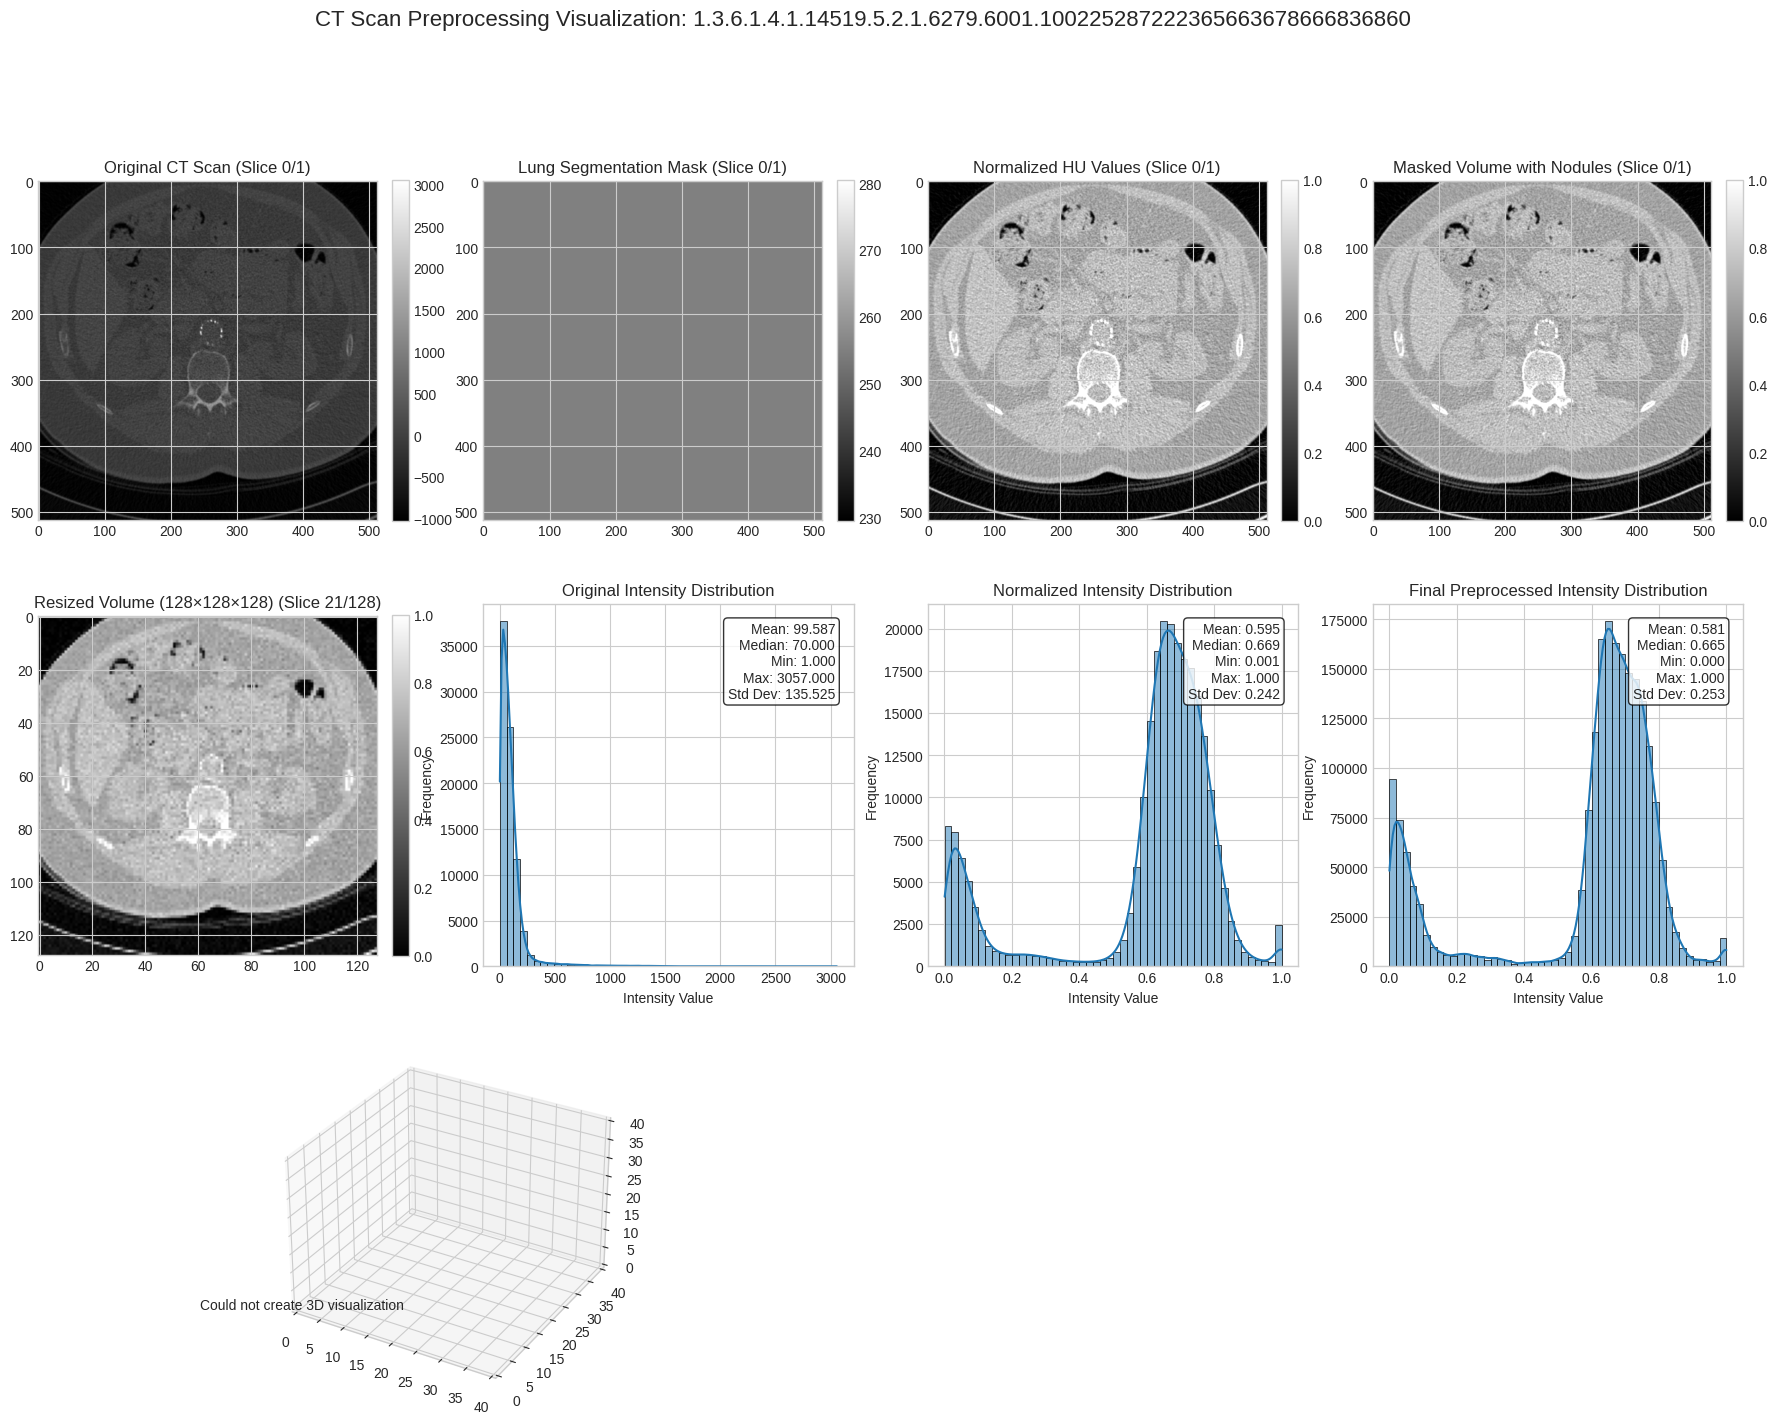

In [28]:
# =============================================================================
# 5. Main Entry Point
# =============================================================================

if __name__ == "__main__":
    # Configure paths (edit these for your environment)
    BASE_DIR = "/kaggle/input/luna-16/LUNA_16"
    ANNOTATIONS_FILE = "/kaggle/input/luna-16/LUNA_16/annotations.csv"
    CANDIDATES_FILE = "/kaggle/input/luna-16/LUNA_16/candidates_V2.csv"
    OUTPUT_DIR = "/kaggle/working/"
    NUM_SCANS = 3
    
    # Print configuration
    print("\n===== CT Scan Preprocessing Visualization =====")
    print(f"Base Directory: {BASE_DIR}")
    print(f"Annotations: {ANNOTATIONS_FILE}")
    print(f"Candidates: {CANDIDATES_FILE}")
    print(f"Output Directory: {OUTPUT_DIR}")
    print(f"Number of Scans: {NUM_SCANS}")
    print("==============================================\n")
    
    # Run the main function
    processed_scans = visualize_multiple_scans(
        BASE_DIR,
        ANNOTATIONS_FILE,
        CANDIDATES_FILE,
        OUTPUT_DIR,
        NUM_SCANS
    )
    
    # Print summary
    print("\n===== Processing Summary =====")
    print(f"Total processed scans: {len(processed_scans)}")
    for idx, scan_id in enumerate(processed_scans, 1):
        print(f"{idx}. {scan_id}")
    print("==============================")


# <b>🧠 3 <span style='color:#B5A8D5'>|</span> 3D DPN Pipeline  </b>


## 🛠️ Lung Nodule Detection Pipeline 🛠️

### Configuration
- Sets reproducible environment with random seeds
- Configures GPU/CPU device
- Defines model parameters (INPUT_SHAPE=(1,128,128,128), classes=2)

### Data Pipeline
- Custom LungNoduleDataset loads 3D CT scans with nodule labels
- Implements CT-specific augmentations (flips, rotations, brightness)
- Creates train/validation split with appropriate sampling



### 🏗️ Model Architecture 

#### 📥 Input/Output
- **Input Shape**: `(1, 128, 128, 128)` – single-channel 3D volumes  
- **Output**: Binary classification (**nodule** vs. **non-nodule**)

#### 🧪 Network Structure
1. **🔧 Initial Feature Extraction**
   - `7×7×7 Conv (64 filters, stride 2)` → `BatchNorm` → `ReLU`  
   - `3×3×3 MaxPool (stride 2)`

2. **🛠  Dual Path Blocks (DPN)**
   - **Layer 1**: `3 DPN blocks` (64 → 128 + 32×3)  
   - **Layer 2**: `4 DPN blocks` (128 + 32×3 → 256 + 64×4, stride 2)  
   - **Layer 3**: `6 DPN blocks` (256 + 64×4 → 512 + 128×6, stride 2)  
   - **Layer 4**: `3 DPN blocks` (512 + 128×6 → 1024 + 256×3, stride 2)

3. **🎯 Classification Head**
   - `Global Average Pooling`  
   - `Fully-connected layer (1024 + 256×3 → 2)`

---

### 🧬 Dual Path Block Design

Each DPN block consists of:

1. **📦 Bottleneck Structure**
   - `1×1×1 Conv` (channel reduction)  
   - `3×3×3 Conv` (spatial feature extraction)  
   - `1×1×1 Conv` (channel expansion)

2. **🧪 Dual Path Mechanism**
   - **Residual Path**: Maintains feature reuse (**ResNet** style)  
   - **Dense Path**: Enables feature exploration (**DenseNet** style)

---

### 📊 Model Capacity
- **Total Parameters**: ~18M (varies slightly based on implementation)  
- **Trainable Parameters**: ~18M

---

### 📉 Training Configuration
- **Loss Function**: Weighted Cross-Entropy (handles class imbalance)  
- **Optimizer**: AdamW (`learning rate = 1e-4`, `weight_decay = 1e-5`)  
- **LR Scheduler**: ReduceLROnPlateau  
- **Batch Size**: 4  
- **Data Augmentation**: Random flips, rotations, brightness adjustments

---

### 🔗 Feature Handling
- Features propagate through both **residual (addition)** and **dense (concatenation)** paths  
- **Residual Path**: Better gradient flow and training stability  
- **Dense Path**: Enhanced feature exploration and reuse


### Training Process
- Weighted cross-entropy loss for class imbalance
- AdamW optimizer with learning rate scheduling
- Tracks performance metrics (accuracy, AUC, loss)
- Saves best model based on validation metrics

### Evaluation
- Generates ROC curves and confusion matrices
- Computes classification report with precision/recall
- Saves visualizations and metrics to results directory

🖥️ Using device: cuda
📋 Starting 3D DPN model training pipeline...
🖥️ Using device: cuda
🔍 Initializing dataset...
🛠️ Initializing dataset with files from /kaggle/working/preprocessed_scans and metadata from /kaggle/working/preprocessed_scans/scan_metadata.csv...

📊 Dataset Class Distribution:
  - Total samples: 888
  - Nodule scans (class 1): 600 (67.6%)
  - Non-nodule scans (class 0): 288 (32.4%)
  - Class ratio (nodule:non-nodule): 1:0.5


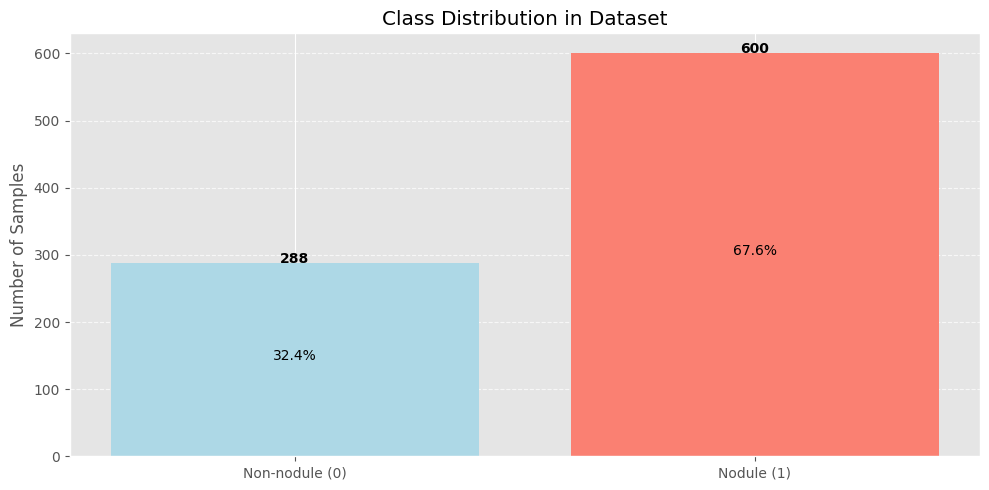

📊 Total dataset size: 888
📈 Training set size: 711
📉 Validation set size: 177

📊 Dataset Class Distribution:
  - Total samples: 888
  - Nodule scans (class 1): 600 (67.6%)
  - Non-nodule scans (class 0): 288 (32.4%)
  - Class ratio (nodule:non-nodule): 1:0.5

📊 Dataset Class Distribution:
  - Total samples: 888
  - Nodule scans (class 1): 600 (67.6%)
  - Non-nodule scans (class 0): 288 (32.4%)
  - Class ratio (nodule:non-nodule): 1:0.5
🧠 Initializing 3D DPN model...
📐 Model Architecture:
Total parameters: 13,543,042
Trainable parameters: 13,543,042
🏃 Starting training for 25 epochs...

📋 Epoch 1/25


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Batch 10/178: Loss: 0.7307 | Acc: 50.00% (20/40)
Batch 20/178: Loss: 0.6661 | Acc: 48.75% (39/80)
Batch 30/178: Loss: 1.1452 | Acc: 50.83% (61/120)
Batch 40/178: Loss: 0.9620 | Acc: 55.00% (88/160)
Batch 50/178: Loss: 1.1859 | Acc: 55.50% (111/200)
Batch 60/178: Loss: 0.4515 | Acc: 54.58% (131/240)
Batch 70/178: Loss: 0.6587 | Acc: 54.29% (152/280)
Batch 80/178: Loss: 0.8703 | Acc: 54.69% (175/320)
Batch 90/178: Loss: 0.7061 | Acc: 53.33% (192/360)
Batch 100/178: Loss: 0.7749 | Acc: 53.75% (215/400)
Batch 110/178: Loss: 0.5065 | Acc: 54.09% (238/440)
Batch 120/178: Loss: 0.7650 | Acc: 55.00% (264/480)
Batch 130/178: Loss: 0.5026 | Acc: 56.15% (292/520)
Batch 140/178: Loss: 0.8224 | Acc: 56.43% (316/560)
Batch 150/178: Loss: 0.3674 | Acc: 58.17% (349/600)
Batch 160/178: Loss: 0.3664 | Acc: 59.06% (378/640)
Batch 170/178: Loss: 1.1615 | Acc: 60.29% (410/680)
🔄 Epoch 1/25 - Train Loss: 0.7027, Train Acc: 61.04% | Val Loss: 0.9281, Val Acc: 70.06%, AUC: 0.6394
💾 Model saved to /kaggle/work

/tmp/ipykernel_359/3643630362.py:713: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH)['model_state_dict'])



📈 Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.19      0.29        53
           1       0.73      0.94      0.82       124

    accuracy                           0.72       177
   macro avg       0.66      0.57      0.55       177
weighted avg       0.69      0.72      0.66       177


📉 Final AUC: 0.6954

💾 Results saved to /kaggle/working/results


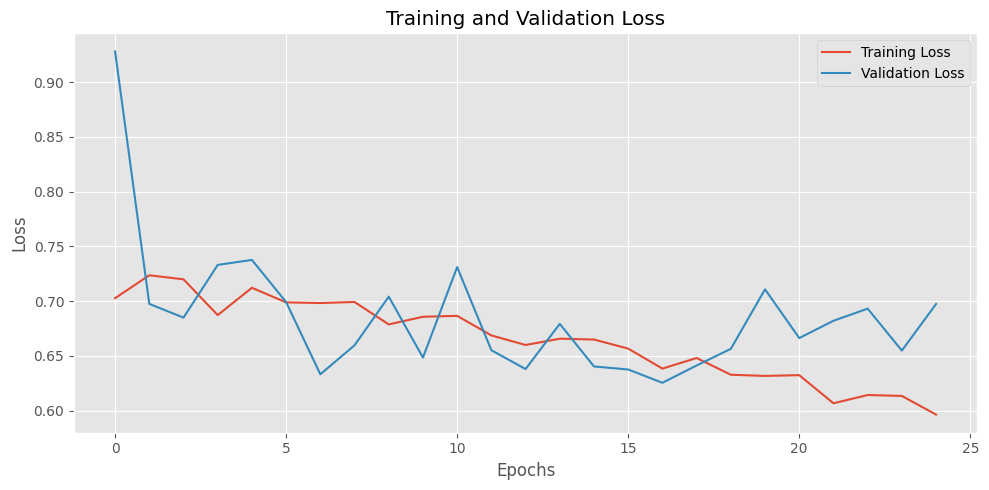

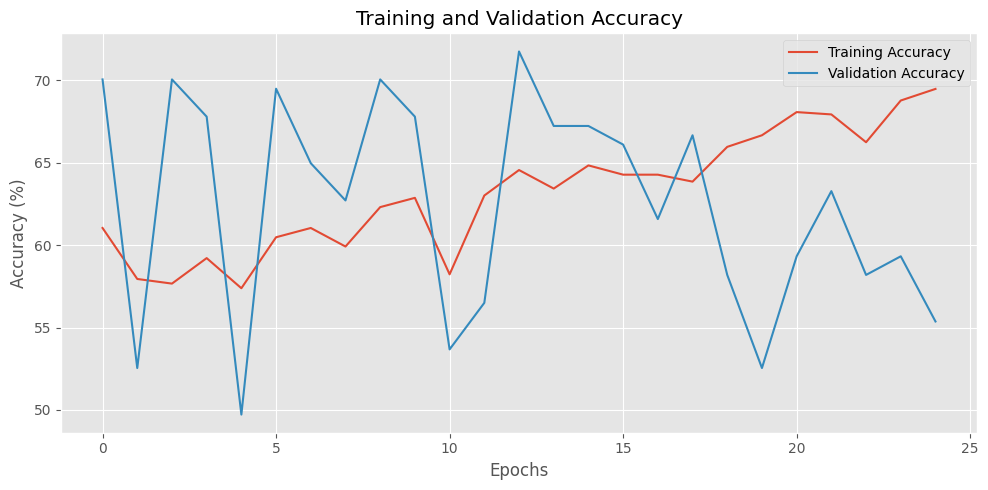

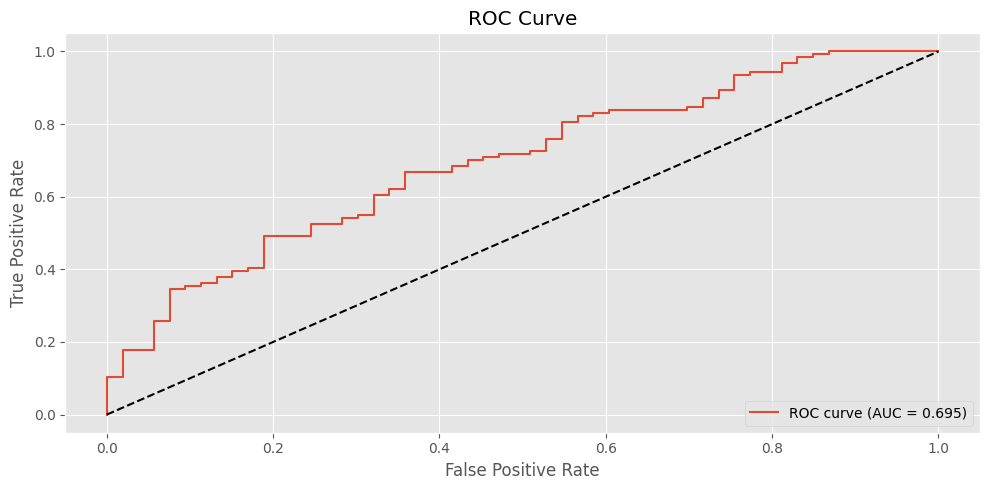

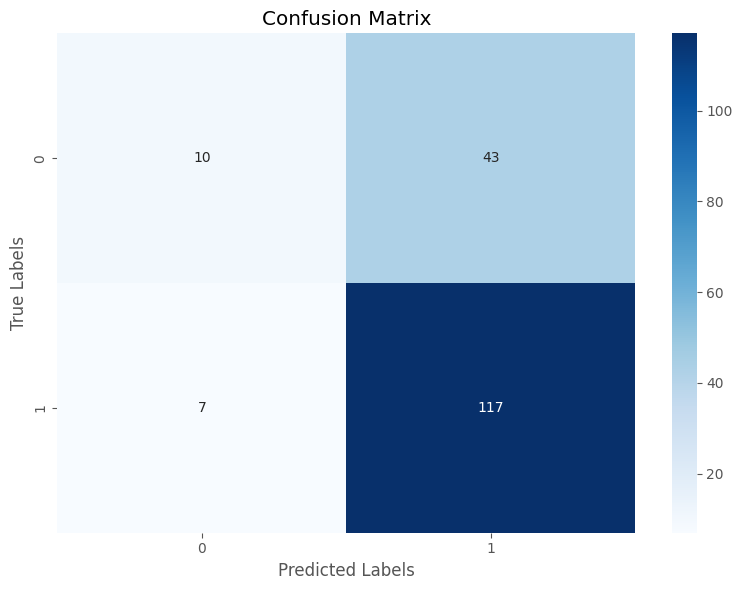

In [2]:
### import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
import scipy.ndimage
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, SubsetRandomSampler

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

# Constants
INPUT_SHAPE = (1, 128, 128, 128)  # (channels, depth, height, width)
NUM_CLASSES = 2  # Binary classification (nodule vs. non-nodule)
BATCH_SIZE = 4
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
VAL_SPLIT = 0.2  # 20% validation split

# Paths
BASE_DIR = '/kaggle/working'  # Base directory
NPY_DIR = os.path.join(BASE_DIR, 'preprocessed_scans')  # Directory with preprocessed scans
METADATA_CSV = os.path.join(NPY_DIR, 'scan_metadata.csv')  # Metadata file from preprocessing
MODEL_SAVE_PATH = os.path.join(BASE_DIR, 'models', 'dpn3d_model.pth')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Create directories if they don't exist
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# ===============================================================
# Data Loading and Preparation
# ===============================================================


class LungNoduleDataset(torch.utils.data.Dataset):
    def __init__(self, npy_dir, csv_path, augment=False, verbose=False):
        """
        Args:
            npy_dir (str): Directory with preprocessed scan files.
            csv_path (str): Path to scan_metadata.csv containing labels.
            augment (bool): Whether to apply data augmentation.
            verbose (bool): Whether to print detailed logs.
        """
        if verbose:
            print(f"🛠️ Initializing dataset with files from {npy_dir} and metadata from {csv_path}...")
        
        self.npy_dir = npy_dir
        self.metadata = pd.read_csv(csv_path)
        self.augment = augment
        self.verbose = verbose
        
        # Get all scan IDs and labels directly from metadata
        self.scan_ids = self.metadata['scan_id'].values
        self.labels = self.metadata['has_nodule'].values
        self.file_paths = self.metadata['file_path'].values
        
        # Print class distribution
        counts = np.bincount(self.labels)
        total_samples = len(self.labels)
        
        print(f"\n📊 Dataset Class Distribution:")
        print(f"  - Total samples: {total_samples}")
        
        # Safely handle potential missing classes
        nodule_count = counts[1] if len(counts) > 1 else 0
        non_nodule_count = counts[0] if len(counts) > 0 else 0
        
        print(f"  - Nodule scans (class 1): {nodule_count} ({nodule_count/total_samples*100:.1f}%)")
        print(f"  - Non-nodule scans (class 0): {non_nodule_count} ({non_nodule_count/total_samples*100:.1f}%)")
        
        # Class ratio
        ratio = non_nodule_count/max(1, nodule_count) if nodule_count > 0 else "∞"
        if isinstance(ratio, float):
            print(f"  - Class ratio (nodule:non-nodule): 1:{ratio:.1f}")
        else:
            print(f"  - Class ratio (nodule:non-nodule): 1:{ratio}")
            
        # Visual representation if requested
        if verbose:
            self._visualize_distribution(counts, total_samples)
    
    def _visualize_distribution(self, counts, total_samples):
        """Create visualization of class distribution"""
        try:
            # Create bar chart of class distribution
            plt.figure(figsize=(10, 5))
            plt.bar(['Non-nodule (0)', 'Nodule (1)'], counts, color=['lightblue', 'salmon'])
            plt.title('Class Distribution in Dataset')
            plt.ylabel('Number of Samples')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add count labels on top of bars
            for i, count in enumerate(counts):
                plt.text(i, count + 0.1, str(count), ha='center', fontweight='bold')
                plt.text(i, count/2, f"{count/total_samples*100:.1f}%", ha='center', color='black')
            
            plt.tight_layout()
            plt.show()
            
            # Print warning if imbalanced
            if len(counts) > 1 and counts[1] / total_samples < 0.1:
                print("\n⚠️ Warning: Dataset has significant class imbalance!")
                print("   Consider implementing one of these strategies:")
                print("   1. Weighted sampling during training")
                print("   2. Class weighting in loss function")
                print("   3. Data augmentation for minority class")
                
        except Exception as e:
            print(f"Could not create visualization: {e}")
            
    def __len__(self):
        return len(self.scan_ids)

    def __getitem__(self, index):
        try:
            # Load from npz file - your preprocessing saves as npz with 'volume' key
            file_path = self.file_paths[index]
            data = np.load(file_path)
            volume = data['volume']  # Extract the volume array
            label = self.labels[index]
            
            # Make sure volume has 1 channel
            if len(volume.shape) == 3:  # If 3D without channel dimension
                volume = np.expand_dims(volume, axis=0)  # Add channel dimension (1,D,H,W)
            
            if self.augment:
                volume = self.augment_volume(volume)
                
            # Convert to Tensor
            volume = torch.tensor(volume, dtype=torch.float32)
            label = torch.tensor(label, dtype=torch.long)
                
            return volume, label
            
        except Exception as e:
            print(f"❌ Error loading sample {index} ({self.file_paths[index]}): {e}")
            # Return a default sample in case of error
            volume = np.zeros((1, 128, 128, 128), dtype=np.float32)
            label = 0
            return torch.tensor(volume, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
    
    # Keep your existing data augmentation methods unchanged
    def random_flip(self, volume):
        # Random flips along random axes
        if np.random.random() > 0.5:
            volume = np.flip(volume, axis=1)  # flip depth
        if np.random.random() > 0.5:
            volume = np.flip(volume, axis=2)  # flip height
        if np.random.random() > 0.5:
            volume = np.flip(volume, axis=3)  # flip width
        return volume

    def random_rotate(self, volume):
        # Random small rotations (max 10 degrees)
        angle = np.random.uniform(-10, 10)
        axes = [(1, 2), (1, 3), (2, 3)][np.random.randint(0, 3)]  # random rotation plane
        volume = scipy.ndimage.rotate(volume, angle, axes=axes, reshape=False, order=1, mode='nearest')
        return volume

    def random_brightness(self, volume):
        # Random brightness adjustment (+/- 10%)
        factor = 1.0 + np.random.uniform(-0.1, 0.1)
        volume = np.clip(volume * factor, 0, 1)
        return volume

    def augment_volume(self, volume):
        volume = self.random_flip(volume)
        volume = self.random_rotate(volume)
        volume = self.random_brightness(volume)
        return volume
    

# ===============================================================
# 3D Dual Path Network Implementation - FIXED VERSION
# ===============================================================

import torch
import torch.nn as nn

class DPN3D(nn.Module):
    """
    3D Dual Path Network implementation aligned with DeepLung paper
    """
    def __init__(self, input_channels=1, num_classes=2):
        super(DPN3D, self).__init__()
        
        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )
        
        # DPN blocks with careful channel management
        self.layer1 = self._make_layer(64, 128, 32, 3, 1)
        self.layer2 = self._make_layer(128 + 3*32, 256, 64, 4, 2)
        self.layer3 = self._make_layer(256 + 4*64, 512, 128, 6, 2)
        self.layer4 = self._make_layer(512 + 6*128, 1024, 256, 3, 2)
        
        # Global pooling and classification
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.classifier = nn.Linear(1024 + 3*256, num_classes)
        
    def _make_layer(self, in_channels, out_channels, dense_channels, num_blocks, stride):
        layers = []
        
        # First block with potential downsampling
        layers.append(DPNBlock(in_channels, out_channels, dense_channels, first_block=True, stride=stride))
        
        # Subsequent blocks - note how we carefully track the channels
        curr_in_channels = out_channels + dense_channels
        for i in range(1, num_blocks):
            layers.append(DPNBlock(curr_in_channels, out_channels, dense_channels))
            curr_in_channels = out_channels + (i+1)*dense_channels
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial convolutional layers
        x = self.features(x)
        
        # DPN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        
        return x
        
    def load_trained_model(self, model_path):
        """
        Load trained model parameters from a saved checkpoint file.
        
        Args:
            model_path (str): Path to the saved model checkpoint
        """
        checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.eval()  # Set model to evaluation mode
        print(f"Model loaded successfully from {model_path}")
        
    def extract_features(self, x):
        """
        Extract features from the model before the classification layer
        
        Args:
            x (Tensor): Input tensor of shape [B, C, D, H, W]
            
        Returns:
            Tensor: Features before classification layer
        """
        # Initial convolutional layers
        x = self.features(x)
        
        # DPN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        return x
    
    def get_prediction_and_confidence(self, x):
        """
        Get prediction label and confidence score
        
        Args:
            x (Tensor): Input tensor of shape [B, C, D, H, W]
            
        Returns:
            tuple: (predicted_label, confidence_score)
        """
        self.eval()  # Set to evaluation mode
        with torch.no_grad():
            outputs = self(x)
            probs = torch.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1)
            confidence = torch.max(probs, dim=1)[0]
            
        return pred_label, confidence


class DPNBlock(nn.Module):
    """
    Dual Path Block for 3D DPN.
    Tracks both residual path and dense path features carefully.
    """
    def __init__(self, in_channels, out_channels, dense_channels, first_block=False, stride=1):
        super(DPNBlock, self).__init__()
        
        self.dense_channels = dense_channels
        self.out_channels = out_channels
        self.first_block = first_block
        
        # Bottleneck channels for efficiency
        self.bottleneck_channels = out_channels // 4
        
        # First 1x1 conv - reduces channels
        self.conv1 = nn.Conv3d(in_channels, self.bottleneck_channels, 
                              kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(self.bottleneck_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        # 3x3 conv
        self.conv2 = nn.Conv3d(self.bottleneck_channels, self.bottleneck_channels, 
                              kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(self.bottleneck_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
        # Second 1x1 conv - increases channels
        self.conv3 = nn.Conv3d(self.bottleneck_channels, out_channels + dense_channels, 
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels + dense_channels)
        
        # Projection shortcut for residual path if needed
        if first_block or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
        else:
            self.shortcut = None
            
        self.relu3 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        # Split input into residual and dense parts
        if self.first_block:
            residual = x
        else:
            residual = x[:, :self.out_channels, :, :, :]
            dense_part = x[:, self.out_channels:, :, :, :]
       
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        # Third conv block
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Split the output into residual and dense paths
        out_residual = out[:, :self.out_channels, :, :, :]
        out_dense = out[:, self.out_channels:, :, :, :]
        
        # Residual connection
        if self.shortcut is not None:
            residual = self.shortcut(residual)
            
        # Add residual
        out_residual = out_residual + residual
        out_residual = self.relu3(out_residual)

        # Concatenate dense features
        if self.first_block:
            return torch.cat([out_residual, out_dense], dim=1)
        else:
            out_dense = torch.cat([dense_part, out_dense], dim=1)
            return torch.cat([out_residual, out_dense], dim=1)

# ===============================================================
# Training Functions
# ===============================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx + 1}/{len(dataloader)}: Loss: {loss.item():.4f} | "
                  f"Acc: {100. * correct / total:.2f}% ({correct}/{total})")
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model on validation set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for ROC curve
            all_outputs.append(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            
    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    
    # Concatenate all batches
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_targets, all_outputs)
    roc_auc = auc(fpr, tpr)
    
    return val_loss, val_acc, fpr, tpr, roc_auc

def save_model(model, path):
    """Save model parameters"""
    torch.save({
        'model_state_dict': model.state_dict(),
    }, path)
    print(f"💾 Model saved to {path}")

def visualize_results(train_losses, val_losses, train_accs, val_accs, 
                      fpr, tpr, roc_auc, save_dir):
    """Visualize and save training results"""
    # Set up plot style
    plt.style.use('ggplot')
    
    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'loss_curve.png'))
    
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'accuracy_curve.png'))
    
    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'))

def predict_and_evaluate(model, dataloader, device):
    """Generate predictions and evaluate model performance"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    cm = confusion_matrix(all_targets, all_preds)
    report = classification_report(all_targets, all_preds)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'))
    
    return all_preds, all_probs, all_targets, roc_auc, report

# ===============================================================
# Main Training Loop
# ===============================================================

def main():
    """Main function to train and evaluate the 3D DPN model"""
    print("📋 Starting 3D DPN model training pipeline...")
    print(f"🖥️ Using device: {device}")
    
    # Initialize dataset with the metadata file from preprocessing
    print("🔍 Initializing dataset...")
    full_dataset = LungNoduleDataset(npy_dir=NPY_DIR, 
                                     csv_path=METADATA_CSV, 
                                     augment=False, 
                                     verbose=True)
    class_counts = np.bincount(full_dataset.labels)
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    class_weights = class_weights / class_weights.sum()  # Normalize
    class_weights = class_weights.to(device)
    
    # Check dataset size
    dataset_size = len(full_dataset)
    print(f"📊 Total dataset size: {dataset_size}")
    
    if dataset_size == 0:
        print("❌ No valid samples found. Check paths and data preparation.")
        return
    
    # Create train/val split indices
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    split = int(np.floor(VAL_SPLIT * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]
    
    print(f"📈 Training set size: {len(train_indices)}")
    print(f"📉 Validation set size: {len(val_indices)}")
    
    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    # Create dataloaders - use augmentation for training
    train_loader = DataLoader(
        LungNoduleDataset(npy_dir=NPY_DIR, csv_path=METADATA_CSV, augment=True, verbose=False),
        batch_size=BATCH_SIZE, 
        sampler=train_sampler,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader = DataLoader(
        LungNoduleDataset(npy_dir=NPY_DIR, csv_path=METADATA_CSV, augment=False, verbose=False),
        batch_size=BATCH_SIZE,
        sampler=val_sampler,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
   
    # Initialize model
    print("🧠 Initializing 3D DPN model...")
    model = DPN3D(input_channels=INPUT_SHAPE[0], num_classes=NUM_CLASSES).to(device)
    
    # Print model summary
    print("📐 Model Architecture:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss function, optimizer and scheduler
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Training loop
    print(f"🏃 Starting training for {NUM_EPOCHS} epochs...")
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_epoch = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_fpr = None
    best_tpr = None
    best_auc = 0.0
    
    start_time = time.time()
    
    try:
        for epoch in range(NUM_EPOCHS):
            print(f"\n📋 Epoch {epoch+1}/{NUM_EPOCHS}")
            
            # Train
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            # Validate
            val_loss, val_acc, fpr, tpr, roc_auc = validate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            # Update scheduler
            scheduler.step(val_loss)
            
            # Print epoch results
            print(f"🔄 Epoch {epoch+1}/{NUM_EPOCHS} - "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, AUC: {roc_auc:.4f}")
            
            # Save best model
            if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
                best_val_loss = val_loss
                best_val_acc = val_acc
                best_epoch = epoch
                best_fpr, best_tpr, best_auc = fpr, tpr, roc_auc
                save_model(model, MODEL_SAVE_PATH)
    
    except KeyboardInterrupt:
        print("\n⚠️ Training interrupted by user")
    
    except Exception as e:
        print(f"\n❌ Error during training: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        # Training complete or interrupted
        training_time = time.time() - start_time
        print(f"\n✅ Training run for {training_time // 60:.0f}m {training_time % 60:.0f}s")
        
        if len(train_losses) > 0:
            print(f"🏆 Best model at epoch {best_epoch+1} with Val Acc: {best_val_acc:.2f}% and Val Loss: {best_val_loss:.4f}")
            
            # Visualize results if we have any
            if best_fpr is not None and best_tpr is not None:
                visualize_results(train_losses, val_losses, train_accs, val_accs, 
                                best_fpr, best_tpr, best_auc, RESULTS_DIR)
            
            # Final evaluation if we have a saved model
            if os.path.exists(MODEL_SAVE_PATH):
                print("\n📊 Performing final evaluation...")
                model.load_state_dict(torch.load(MODEL_SAVE_PATH)['model_state_dict'])
                all_preds, all_probs, all_targets, final_auc, report = predict_and_evaluate(model, val_loader, device)
                
                print("\n📈 Classification Report:")
                print(report)
                
                print(f"\n📉 Final AUC: {final_auc:.4f}")
                
                print(f"\n💾 Results saved to {RESULTS_DIR}")
                
                # Write classification report to file
                with open(os.path.join(RESULTS_DIR, 'classification_report.txt'), 'w') as f:
                    f.write(f"Classification Report:\n{report}\n\nAUC: {final_auc:.4f}")

if __name__ == "__main__":
    main()


# <b>🧪 4 <span style='color:#B5A8D5'>|</span> Report generation for nodule detection  </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>4.1 |</span></b>  generation pipeline </b></p>
</div>


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib
matplotlib.use('Agg')  # Use non-GUI backend
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from fpdf import FPDF
import random
import scipy.ndimage
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from datetime import datetime
import pyvista as pv


def load_raw_scan(raw_path, shape=(512, 512, None), dtype=np.int16):
    """
    Load a raw CT scan from file
    
    Args:
        raw_path: Path to the raw file
        shape: Expected shape (X, Y, Z) where Z can be None to calculate from file size
        dtype: Data type of the raw file
        
    Returns:
        numpy array: The loaded CT scan data
    """
    file_size = os.path.getsize(raw_path)
    voxel_size = np.dtype(dtype).itemsize
    total_voxels = file_size // voxel_size
    if shape[2] is None:
        depth = total_voxels // (shape[0] * shape[1])
        full_shape = (depth, shape[1], shape[0])  # Z,Y,X
    else:
        full_shape = (shape[2], shape[1], shape[0])
    with open(raw_path, 'rb') as f:
        scan = np.frombuffer(f.read(), dtype=dtype)
    scan = scan.reshape(full_shape)
    return scan



import os
import numpy as np
import pyvista as pv
from skimage import measure

# Enhanced visualization function for nodules
def generate_3d_nodule_visualization(volume, nodules, output_dir):

    """
    Generate a realistic 3D visualization of detected nodules.

    Args:
        volume: The CT scan volume (C, D, H, W).
        nodules: List of tuples (x, y, z, diameter) for each nodule.
        output_dir: Directory to save the 3D visualization.

    Returns:
        str: Path to the 3D visualization image.
    """
   
    os.makedirs(output_dir, exist_ok=True)

    # Extract the volume data and remove channel dimension
    vol_data = volume.squeeze().cpu().numpy()

    # Normalize the volume for better rendering
    vol_data = (vol_data - vol_data.min()) / (vol_data.max() - vol_data.min())

    # Apply Marching Cubes algorithm to extract nodule surfaces
    verts, faces, normals, _ = measure.marching_cubes(
        vol_data, level=np.percentile(vol_data, 98)  # Use high-intensity threshold
    )

    # Fix the faces array to match PyVista's requirements
    faces_fixed = np.hstack([[3] + list(face) for face in faces])

    # Create a pyvista mesh
    mesh = pv.PolyData(verts, faces_fixed)

    # Create a pyvista plotter with offscreen rendering
    plotter = pv.Plotter(off_screen=True)
    plotter.set_background("white")  # Set background color

    # Add the nodule surface to the plotter
    plotter.add_mesh(
        mesh, color="pink", opacity=0.8, smooth_shading=True, specular=0.5, name="Nodule"
    )

    # Highlight detected nodules with spheres
    for i, (x, y, z, diameter) in enumerate(nodules):
        nodule_center = (x, y, z)
        sphere = pv.Sphere(center=nodule_center, radius=diameter / 2)
        plotter.add_mesh(
            sphere, color="red", opacity=1.0, smooth_shading=True, name=f"Nodule_{i+1}"
        )

    # Add lighting and interactive options
    plotter.add_axes()
    plotter.add_light(pv.Light(position=(1, 1, 1), intensity=0.8))

    # Save the 3D visualization as an image
    output_path = os.path.join(output_dir, "realistic_3d_nodule_visualization.png")
    plotter.show(screenshot=output_path)
    plotter.close()


    return output_path
    


def generate_activation_maps(model, volume, output_dir):
    """
    Generate activation maps from the model for the given volume
    
    Args:
        model: The trained model
        volume: Input volume
        output_dir: Directory to save activation maps
        
    Returns:
        str: Path to the activation map image
    """
    # Register forward hook to get activation maps from layer1 and layer4
    activations = {}
    
    def hook_fn(module, input, output):
        activations[module] = output.detach()
    
    hooks = []
    hooks.append(model.layer1.register_forward_hook(hook_fn))
    hooks.append(model.layer4.register_forward_hook(hook_fn))
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(volume)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Create activation map visualizations
    plt.figure(figsize=(15, 8))
    plt.suptitle('DPN3D Network Activation Maps', fontsize=16)
    
    # Format for subplotting
    rows = 2  # Early and late layers
    cols = 4  # Number of feature maps to show
    
    # Get activations from early and late layers
    early_act = activations[model.layer1].cpu().squeeze(0)
    late_act = activations[model.layer4].cpu().squeeze(0)
    
    # Show early layer activations
    for i in range(min(cols, early_act.shape[0])):
        plt.subplot(rows, cols, i+1)
        # Take middle slice of the activation volume
        act_map = early_act[i, early_act.shape[1]//2, :, :].numpy()
        plt.imshow(act_map, cmap='viridis')
        plt.title(f'Layer 1 - Filter {i}')
        plt.axis('off')
    
    # Show late layer activations
    for i in range(min(cols, late_act.shape[0])):
        plt.subplot(rows, cols, cols+i+1)
        # Take middle slice of the activation volume
        act_map = late_act[i, late_act.shape[1]//2, :, :].numpy()
        plt.imshow(act_map, cmap='viridis')
        plt.title(f'Layer 4 - Filter {i}')
        plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    activation_path = os.path.join(output_dir, 'activation_maps.png')
    plt.savefig(activation_path, dpi=150)
    plt.close()
    
    return activation_path

# Add this function to visualize raw CT scan
def visualize_raw_scan(raw_scan_data, output_dir):
    """
    Generate visualizations of the raw CT scan
    
    Args:
        raw_scan_data: The raw CT scan data
        output_dir: Directory to save visualizations
        
    Returns:
        dict: Paths to the generated visualization images
    """
    os.makedirs(output_dir, exist_ok=True)
    vis_paths = {}
    
    # For consistent windowing - Hounsfield units for lung
    vmin = -1000
    vmax = 400
    
    # Full volume visualization - 9 axial slices
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    depth = raw_scan_data.shape[0]
    
    for i in range(3):
        for j in range(3):
            slice_idx = int(depth * (i*3 + j + 1) / 10)  # Distribute slices
            axes[i, j].imshow(raw_scan_data[slice_idx], cmap='gray', vmin=vmin, vmax=vmax)
            axes[i, j].set_title(f'Z-slice {slice_idx}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    raw_multi_slice_path = os.path.join(output_dir, 'raw_multi_slice_visualization.png')
    plt.savefig(raw_multi_slice_path, dpi=150)
    plt.close()
    
    vis_paths['raw_multi_slice'] = raw_multi_slice_path
    
    # Create 3D visualization with 3 planes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Middle slice for each plane
    z_mid = raw_scan_data.shape[0] // 2
    y_mid = raw_scan_data.shape[1] // 2
    x_mid = raw_scan_data.shape[2] // 2
    
    # Axial slice (z-plane)
    axes[0].imshow(raw_scan_data[z_mid], cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Axial Slice (z={z_mid})')
    axes[0].axis('off')
    
    # Coronal slice (y-plane)
    axes[1].imshow(raw_scan_data[:, y_mid, :], cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Coronal Slice (y={y_mid})')
    axes[1].axis('off')
    
    # Sagittal slice (x-plane)
    axes[2].imshow(raw_scan_data[:, :, x_mid], cmap='gray', vmin=vmin, vmax=vmax)
    axes[2].set_title(f'Sagittal Slice (x={x_mid})')
    axes[2].axis('off')
    
    plt.tight_layout()
    raw_planes_path = os.path.join(output_dir, 'raw_planes_visualization.png')
    plt.savefig(raw_planes_path, dpi=150)
    plt.close()
    
    vis_paths['raw_planes'] = raw_planes_path
    
    return vis_paths


# Import the DPN3D model architecture
class DPN3D(torch.nn.Module):
    """
    3D Dual Path Network implementation aligned with DeepLung paper
    """
    def __init__(self, input_channels=1, num_classes=2):
        super(DPN3D, self).__init__()
        
        # Initial convolution
        self.features = torch.nn.Sequential(
            torch.nn.Conv3d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        )
        
        # DPN blocks with careful channel management
        self.layer1 = self._make_layer(64, 128, 32, 3, 1)
        self.layer2 = self._make_layer(128 + 3*32, 256, 64, 4, 2)
        self.layer3 = self._make_layer(256 + 4*64, 512, 128, 6, 2)
        self.layer4 = self._make_layer(512 + 6*128, 1024, 256, 3, 2)
        
        # Global pooling and classification
        self.avg_pool = torch.nn.AdaptiveAvgPool3d(1)
        self.classifier = torch.nn.Linear(1024 + 3*256, num_classes)
        
    def _make_layer(self, in_channels, out_channels, dense_channels, num_blocks, stride):
        layers = []
        
        # First block with potential downsampling
        layers.append(DPNBlock(in_channels, out_channels, dense_channels, first_block=True, stride=stride))
        
        # Subsequent blocks - note how we carefully track the channels
        curr_in_channels = out_channels + dense_channels
        for i in range(1, num_blocks):
            layers.append(DPNBlock(curr_in_channels, out_channels, dense_channels))
            curr_in_channels = out_channels + (i+1)*dense_channels
            
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial convolutional layers
        x = self.features(x)
        
        # DPN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        
        return x
        
    def load_trained_model(self, model_path):
        """
        Load trained model parameters from a saved checkpoint file.
        
        Args:
            model_path (str): Path to the saved model checkpoint
        """
        checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.eval()  # Set model to evaluation mode
        print(f"Model loaded successfully from {model_path}")
        
    def extract_features(self, x):
        """
        Extract features from the model before the classification layer
        
        Args:
            x (Tensor): Input tensor of shape [B, C, D, H, W]
            
        Returns:
            Tensor: Features before classification layer
        """
        # Initial convolutional layers
        x = self.features(x)
        
        # DPN blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        return x
    
    def get_prediction_and_confidence(self, x):
        """
        Get prediction label and confidence score
        
        Args:
            x (Tensor): Input tensor of shape [B, C, D, H, W]
            
        Returns:
            tuple: (predicted_label, confidence_score, probabilities)
        """
        self.eval()  # Set to evaluation mode
        with torch.no_grad():
            outputs = self(x)
            probs = torch.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1)
            confidence = torch.max(probs, dim=1)[0]
            
        return pred_label, confidence, probs


class DPNBlock(torch.nn.Module):
    """
    Dual Path Block for 3D DPN.
    Tracks both residual path and dense path features carefully.
    """
    def __init__(self, in_channels, out_channels, dense_channels, first_block=False, stride=1):
        super(DPNBlock, self).__init__()
        
        self.dense_channels = dense_channels
        self.out_channels = out_channels
        self.first_block = first_block
        
        # Bottleneck channels for efficiency
        self.bottleneck_channels = out_channels // 4
        
        # First 1x1 conv - reduces channels
        self.conv1 = torch.nn.Conv3d(in_channels, self.bottleneck_channels, 
                              kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm3d(self.bottleneck_channels)
        self.relu1 = torch.nn.ReLU(inplace=True)
        
        # 3x3 conv
        self.conv2 = torch.nn.Conv3d(self.bottleneck_channels, self.bottleneck_channels, 
                              kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm3d(self.bottleneck_channels)
        self.relu2 = torch.nn.ReLU(inplace=True)
        
        # Second 1x1 conv - increases channels
        self.conv3 = torch.nn.Conv3d(self.bottleneck_channels, out_channels + dense_channels, 
                              kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm3d(out_channels + dense_channels)
        
        # Projection shortcut for residual path if needed
        if first_block or stride != 1:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm3d(out_channels)
            )
        else:
            self.shortcut = None
            
        self.relu3 = torch.nn.ReLU(inplace=True)
        
    def forward(self, x):
        # Split input into residual and dense parts
        if self.first_block:
            residual = x
        else:
            residual = x[:, :self.out_channels, :, :, :]
            dense_part = x[:, self.out_channels:, :, :, :]
       
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        # Third conv block
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Split the output into residual and dense paths
        out_residual = out[:, :self.out_channels, :, :, :]
        out_dense = out[:, self.out_channels:, :, :, :]
        
        # Residual connection
        if self.shortcut is not None:
            residual = self.shortcut(residual)
            
        # Add residual
        out_residual = out_residual + residual
        out_residual = self.relu3(out_residual)

        # Concatenate dense features
        if self.first_block:
            return torch.cat([out_residual, out_dense], dim=1)
        else:
            out_dense = torch.cat([dense_part, out_dense], dim=1)
            return torch.cat([out_residual, out_dense], dim=1)


class PDF(FPDF):
    """Custom PDF class with header and footer"""
    

    def header(self):
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, 'Lung Nodule Analysis Report', 0, 1, 'C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

    def add_first_page(self, scan_id, pred_label, confidence, probs, date, image_path, summary):
        """
        Add an enhanced first page to the PDF report.

        Args:
            scan_id: ID of the analyzed CT scan.
            pred_label: Predicted label (0=non-nodule, 1=nodule).
            confidence: Prediction confidence.
            probs: Class probabilities.
            date: Date of report generation.
            image_path: Path to the image to be displayed on the first page.
            summary: A short summary of the analysis.
        """
        # Add a new page
        self.add_page()

        # Title Section
        self.set_font('Arial', 'B', 24)
        self.set_text_color(0, 51, 102)  # Navy blue
        self.cell(0, 10, "CT Scan Analysis Report", 0, 1, 'C')
        self.ln(5)

        # Subtitle
        self.set_font('Arial', 'B', 16)
        self.set_text_color(100, 100, 100)  # Gray
        self.cell(0, 10, "Detected by 3D Dual Path Network Model", 0, 1, 'C')
        self.ln(15)

        # Analysis Summary Section
        self.set_font('Arial', '', 12)
        self.set_text_color(0, 0, 0)  # Black

        # CT Scan ID
        self.cell(0, 10, f"CT Scan ID: {scan_id}", 0, 1, 'L')

        # Prediction
        pred_class = "Nodule Detected" if pred_label == 1 else "No Nodule Detected"
        self.cell(0, 10, f"Prediction: {pred_class}", 0, 1, 'L')

        # Confidence Level
        confidence_percentage = confidence * 100
        self.cell(0, 10, f"Confidence: {confidence_percentage:.2f}%", 0, 1, 'L')

        # Confidence Category (High/Low)
        confidence_category = "High Confidence" if confidence > 0.75 else "Low Confidence"
        self.cell(0, 10, f"Detection Confidence: {confidence_category}", 0, 1, 'L')

        # Class Probabilities
        prob_nodule = probs[0][1].item() * 100
        prob_non_nodule = probs[0][0].item() * 100
        self.cell(0, 10, f"Class Probabilities:", 0, 1, 'L')
        self.cell(0, 10, f"- Nodule: {prob_nodule:.2f}%", 0, 1, 'L')
        self.cell(0, 10, f"- Non-nodule: {prob_non_nodule:.2f}%", 0, 1, 'L')

        # Date
        self.cell(0, 10, f"Date: {date}", 0, 1, 'L')
        self.ln(10)

        # Add Summary
        self.set_font('Arial', 'I', 10)
        self.multi_cell(0, 5, f"Summary: {summary}")
        self.ln(15)

        # Add Image
        self.image(image_path, x=25, y=self.get_y(), w=160)
        self.ln(10)
    
    
    

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.set_fill_color(200, 220, 255)
        self.cell(0, 6, title, 0, 1, 'L', 1)
        self.ln(4)
        
    def chapter_body(self, body):
        self.set_font('Arial', '', 10)
        self.multi_cell(0, 5, body)
        self.ln()


def find_nodule_coordinates(volume, pred_label, annotations_df=None, series_uid=None):
    """
    Find coordinates of potential nodules in the volume.
    If actual annotations are available, use them; otherwise use a detection heuristic.
    
    Args:
        volume: The CT scan volume
        pred_label: Predicted label (0=non-nodule, 1=nodule)
        annotations_df: DataFrame with nodule annotations
        series_uid: Series UID of the scan
        
    Returns:
        list of tuples (x, y, z, diameter_mm) for each detected nodule
    """
    if pred_label == 0:  # No nodule predicted
        return []
    
    # If we have annotations and series_uid, use them
    if annotations_df is not None and series_uid is not None:
        nodule_annotations = annotations_df[annotations_df['seriesuid'] == series_uid]
        if not nodule_annotations.empty:
            # Convert world coordinates to volume coordinates (crude approximation)
            # In a real system, this would use the scan's transformation matrix
            nodules = []
            for _, row in nodule_annotations.iterrows():
                # Simple scaling from world to image coordinates - this is approximate
                x = int((row['coordX'] + 200) / 400 * volume.shape[2])
                y = int((row['coordY'] + 200) / 400 * volume.shape[3]) 
                z = int((row['coordZ'] + 400) / 800 * volume.shape[1])
                diameter_px = int(row['diameter_mm'] / 2)  # Convert mm to approximate pixels
                
                # Ensure coordinates are within bounds
                x = max(0, min(x, volume.shape[2]-1))
                y = max(0, min(y, volume.shape[3]-1))
                z = max(0, min(z, volume.shape[1]-1))
                
                nodules.append((x, y, z, diameter_px))
            return nodules
    
    # If no annotations or can't match series_uid, use a heuristic approach
    # Find regions with high intensity (potential nodules)
    volume_np = volume.squeeze().cpu().numpy()  # Remove channel dimension and convert to numpy
    
    # Apply threshold to find high-intensity regions (potential nodules)
    threshold = np.percentile(volume_np, 98)  # Top 2% intensity
    binary = volume_np > threshold
    
    # Apply morphological operations to clean up the binary image
    binary = scipy.ndimage.binary_opening(binary, structure=np.ones((3,3,3)))
    binary = scipy.ndimage.binary_closing(binary, structure=np.ones((3,3,3)))
    
    # Label connected components
    labeled, num_features = scipy.ndimage.label(binary)
    
    # Get properties of each component
    nodules = []
    if num_features > 0:
        # Find center of mass for each component
        centers = scipy.ndimage.center_of_mass(volume_np, labeled, range(1, num_features+1))
        
        # Calculate size of each component
        sizes = scipy.ndimage.sum(binary, labeled, range(1, num_features+1))
        
        # Sort components by size (largest first)
        sorted_indices = np.argsort(-sizes)
        
        # Take at most 3 largest components as nodules
        for idx in sorted_indices[:min(3, len(sizes))]:
            if sizes[idx] > 10:  # Minimum size threshold
                z, y, x = map(int, centers[idx])
                # Estimate diameter as cube root of volume (in pixels)
                diameter_px = int(np.cbrt(sizes[idx]) / 2)
                nodules.append((x, y, z, diameter_px))
    
    return nodules


def generate_slice_visualizations(volume, nodules, output_dir):
    """
    Generate visualizations of axial, coronal, and sagittal slices with nodule markers.
    
    Args:
        volume: The CT scan volume (C, D, H, W)
        nodules: List of tuples (x, y, z, diameter) for each nodule
        output_dir: Directory to save visualizations
        
    Returns:
        dict: Paths to the generated visualization images
    """
    os.makedirs(output_dir, exist_ok=True)
    vis_paths = {}
    
    # Extract the volume data and remove channel dimension
    vol_data = volume.squeeze().cpu().numpy()
    
    # For consistent windowing
    vmin = -1000
    vmax = 600
    
    # Generate visualizations only if nodules were detected
    if nodules:
        for i, (x, y, z, diameter) in enumerate(nodules):
            # Create figure with 3 subplots (axial, coronal, sagittal)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Axial slice (z-plane)
            axes[0].imshow(vol_data[z, :, :], cmap='gray', vmin=vmin, vmax=vmax)
            axes[0].add_patch(Rectangle((x-diameter, y-diameter), 2*diameter, 2*diameter, 
                                        fill=False, edgecolor='red', linewidth=2))
            axes[0].set_title(f'Axial Slice (z={z})')
            
            # Coronal slice (y-plane)
            axes[1].imshow(vol_data[:, y, :], cmap='gray', vmin=vmin, vmax=vmax)
            axes[1].add_patch(Rectangle((x-diameter, z-diameter), 2*diameter, 2*diameter, 
                                        fill=False, edgecolor='red', linewidth=2))
            axes[1].set_title(f'Coronal Slice (y={y})')
            
            # Sagittal slice (x-plane)
            axes[2].imshow(vol_data[:, :, x], cmap='gray', vmin=vmin, vmax=vmax)
            axes[2].add_patch(Rectangle((y-diameter, z-diameter), 2*diameter, 2*diameter, 
                                        fill=False, edgecolor='red', linewidth=2))
            axes[2].set_title(f'Sagittal Slice (x={x})')
            
            plt.tight_layout()
            
            # Save the figure
            nodule_vis_path = os.path.join(output_dir, f'nodule_{i+1}_visualization.png')
            plt.savefig(nodule_vis_path, dpi=150)
            plt.close()
            
            vis_paths[f'nodule_{i+1}'] = nodule_vis_path
    
       
    
    # Multi-slice view for axial slices
    # Show 9 axial slices evenly distributed across the volume
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    d = vol_data.shape[0]
    
    for i in range(3):
        for j in range(3):
            slice_idx = int(d * (i*3 + j + 1) / 10)  # Distribute slices
            axes[i, j].imshow(vol_data[slice_idx, :, :], cmap='gray', vmin=vmin, vmax=vmax)
            axes[i, j].set_title(f'Z-slice {slice_idx}')
            
            # Mark nodules that appear in this slice
            for x, y, z, diameter in nodules:
                if abs(z - slice_idx) <= diameter:  # Nodule appears in this slice
                    axes[i, j].add_patch(Rectangle((x-diameter, y-diameter), 2*diameter, 2*diameter, 
                                                fill=False, edgecolor='red', linewidth=2))
    
    plt.tight_layout()
    multi_slice_path = os.path.join(output_dir, 'multi_slice_visualization.png')
    plt.savefig(multi_slice_path, dpi=150)
    plt.close()
    
    vis_paths['multi_slice'] = multi_slice_path
    
    return vis_paths


def visualize_feature_space(model, volume, output_dir):
    """
    Extract deep features and visualize them using t-SNE
    
    Args:
        model: The trained model
        volume: Input volume
        output_dir: Directory to save visualizations
        
    Returns:
        str: Path to the feature visualization image
    """
    # Extract features from the model
    model.eval()
    with torch.no_grad():
        features = model.extract_features(volume)
    
    # Convert to numpy for visualization
    features_np = features.cpu().numpy()
    
    try:
        # Create variations of the features for better visualization
        num_variations = 20  # Create this many variations
        variations = []
        labels = []  # 0 for original, 1-4 for different variation types
        
        # Add the original features
        variations.append(features_np[0])
        labels.append(0)
        
        # Create variations with small Gaussian noise of different levels
        for i in range(num_variations):
            noise_level = 0.01 * (i+1)
            noisy_features = features_np[0] + np.random.normal(0, noise_level, features_np[0].shape)
            variations.append(noisy_features)
            labels.append(1)  # Noise variations
            
        # Add a few more variations with different patterns
        # Scale variations
        for i in range(3):
            scale_factor = 0.9 + i * 0.1
            scaled_features = features_np[0] * scale_factor
            variations.append(scaled_features)
            labels.append(2)  # Scale variations
            
        # Add/subtract mean variations
        mean_shift = np.mean(features_np[0]) * 0.1
        variations.append(features_np[0] + mean_shift)
        variations.append(features_np[0] - mean_shift)
        labels.append(3)  # Mean shift up
        labels.append(3)  # Mean shift down
        
        # Convert to array
        variations = np.array(variations)
        labels = np.array(labels)
        
        # Set perplexity based on number of samples (must be < n_samples)
        n_samples = variations.shape[0]
        perplexity = min(5, n_samples - 1)  # Safe default that will work with small sample sizes
        
        # Apply t-SNE with appropriate perplexity
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_result = tsne.fit_transform(variations)
        
        # Visualize t-SNE result
        plt.figure(figsize=(10, 8))
        
        # Create colormap for different types of variations
        cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))
        scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                             c=labels, cmap=cmap, alpha=0.7, s=100)
        
        # Highlight the original point
        plt.scatter(tsne_result[0, 0], tsne_result[0, 1], 
                   c='red', marker='*', s=200, edgecolors='black', label='Original')
        
        # Add legend for variation types
        label_descriptions = {
            0: 'Original',
            1: 'Noise Variation',
            2: 'Scale Variation',
            3: 'Mean Shift'
        }
        
        # Create handles for the legend
        legend_handles = []
        for label_value in sorted(np.unique(labels)):
            if label_value in label_descriptions:
                legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                               markerfacecolor=cmap(label_value/len(label_descriptions)), 
                                               markersize=10, label=label_descriptions[label_value]))
        
        plt.legend(handles=legend_handles, loc='best')
        plt.title('t-SNE Visualization of Deep Features')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.tight_layout()
        
    except Exception as e:
        # If t-SNE fails, create a simpler PCA plot instead
        print(f"t-SNE failed: {e}. Creating simple PCA visualization instead.")
        
        # Create a very simple 2D plot using the first 2 PCA components
        from sklearn.decomposition import PCA
        
        # Ensure we have at least a few variations
        if len(variations) < 5:
            # Add more variations if needed
            for i in range(5):
                variations = np.vstack([variations, features_np[0] * (1 + i*0.01)])
                labels = np.append(labels, 0)
        
        # Apply PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(variations)
        
        plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', alpha=0.7, s=100)
        plt.scatter(pca_result[0, 0], pca_result[0, 1], c='red', marker='*', s=200, label='Original')
        plt.legend()
        plt.title('PCA Visualization of Deep Features')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.tight_layout()
    
    # Save the figure
    tsne_path = os.path.join(output_dir, 'feature_visualization.png')
    plt.savefig(tsne_path, dpi=150)
    plt.close()
    
    return tsne_path


def get_clinical_recommendations(pred_label, confidence, nodules):
    """
    Generate clinical recommendations based on prediction results
    
    Args:
        pred_label: Predicted label (0=non-nodule, 1=nodule)
        confidence: Prediction confidence
        nodules: List of detected nodules with coordinates and diameters
        
    Returns:
        str: Clinical recommendations
    """
    if pred_label == 0:
        if confidence > 0.9:
            return ("No suspicious pulmonary nodules detected with high confidence. " 
                   "Recommend routine screening as per patient risk factors and clinical guidelines.")
        else:
            return ("No definitive pulmonary nodules detected, however with moderate confidence. "
                   "Consider follow-up imaging in 6-12 months for high-risk patients.")
    else:
        # Nodule(s) detected
        recommendations = ["Pulmonary nodule(s) detected."]
        
        # Add details for each nodule
        for i, (_, _, _, diameter_px) in enumerate(nodules):
            # Convert diameter from pixels to approximate mm (assuming 1px ≈ 1mm)
            diameter_mm = diameter_px * 2
            
            if diameter_mm < 6:
                recommendations.append(f"Nodule {i+1}: Approximately {diameter_mm:.1f}mm in diameter. "
                                      f"Recommend follow-up CT in 6-12 months to assess for growth.")
            elif diameter_mm < 8:
                recommendations.append(f"Nodule {i+1}: Approximately {diameter_mm:.1f}mm in diameter. "
                                      f"Recommend follow-up CT in 3-6 months to assess for growth.")
            else:
                recommendations.append(f"Nodule {i+1}: Approximately {diameter_mm:.1f}mm in diameter. "
                                      f"Consider further evaluation with PET/CT or tissue sampling "
                                      f"based on patient risk factors and nodule characteristics.")
        
        if confidence < 0.75:
            recommendations.append("Note: Model confidence is moderate. Radiologist assessment is strongly recommended.")
        
        return "\n\n".join(recommendations)



# Function to generate a table of nodule characteristics
def generate_nodule_characteristics_table(nodules):
    """
    Create a table summarizing nodule characteristics.

    Args:
        nodules: List of detected nodules with coordinates and diameters.

    Returns:
        str: HTML-like table rendering of nodule characteristics.
    """
    table = "Nodule Characteristics:\n\n"
    table += "{:<10} {:<15} {:<15} {:<15} {:<15}\n".format(
        "Nodule", "X-Coord", "Y-Coord", "Z-Coord", "Diameter (mm)"
    )
    table += "-" * 70 + "\n"

    for idx, (x, y, z, diameter_px) in enumerate(nodules):
        diameter_mm = diameter_px * 2  # Convert to mm
        table += "{:<10} {:<15} {:<15} {:<15} {:<15.2f}\n".format(
            idx + 1, x, y, z, diameter_mm
        )

    return table



def create_pdf_report(scan_id, series_uid, pred_label, confidence, probs, nodules, 
                      visualization_paths, raw_vis_paths, tsne_path, activation_map_path,
                      recommendations, nodule_table, nodule_3d_path,output_path):
    """
    Create a comprehensive PDF report with all analysis results
    
    Args:
        scan_id: ID of the analyzed scan
        series_uid: Series UID of the scan
        pred_label: Predicted label (0=non-nodule, 1=nodule)
        confidence: Prediction confidence
        probs: Class probabilities
        nodules: List of detected nodules
        visualization_paths: Paths to preprocessed scan visualization images
        raw_vis_paths: Paths to raw scan visualization images
        tsne_path: Path to t-SNE visualization
        activation_map_path: Path to activation map visualization
        recommendations: Clinical recommendations
        output_path: Path to save the PDF report
        
    Returns:
        str: Path to the generated PDF report
    """
    # Create PDF object
    pdf = PDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    
    # Report header with scan ID and date
    pdf.set_font('Arial', 'B', 16)
    pdf.cell(0, 10, "Lung Nodule Analysis Report", 0, 1, 'C')
    pdf.set_font('Arial', '', 12)
    pdf.cell(0, 10, f"Scan ID: {scan_id}", 0, 1, 'C')
    if series_uid:
        pdf.cell(0, 10, f"Series UID: {series_uid}", 0, 1, 'C')
    pdf.cell(0, 10, f"Date: {datetime.now().strftime('%B %d, %Y')}", 0, 1, 'C')
    pdf.ln(10)


    # Add nodule characteristics table
    pdf.add_page()
    pdf.chapter_title("Nodule Characteristics")
    pdf.set_font('Courier', '', 10)
    pdf.multi_cell(0, 5, nodule_table)


    # Add 3D nodule visualization
    if nodule_3d_path:
        pdf.add_page()
        pdf.chapter_title("3D Nodule Visualization")
        pdf.image(nodule_3d_path, x=10, w=190)
    
    # Raw CT Scan Visualization (if available)
    if raw_vis_paths:
        pdf.add_page()
        pdf.chapter_title("Original CT Scan")
        
        if 'raw_multi_slice' in raw_vis_paths:
            pdf.chapter_body("Multi-slice visualization of the original lung CT scan:")
            pdf.image(raw_vis_paths['raw_multi_slice'], x=10, w=190)
            pdf.ln(5)
        
        if 'raw_planes' in raw_vis_paths:
            pdf.add_page()
            pdf.chapter_title("Original CT Scan - Orthogonal Views")
            pdf.chapter_body("Axial, Coronal, and Sagittal views of the original CT scan:")
            pdf.image(raw_vis_paths['raw_planes'], x=10, w=190)
            pdf.ln(5)
    
    # Activation Maps
    pdf.add_page()
    pdf.chapter_title("Neural Network Activation Maps")
    pdf.chapter_body("Visualizations of the model's internal activations when processing this scan:")
    pdf.image(activation_map_path, x=10, w=190)
    pdf.ln(5)
    
    # Analysis Summary
    pdf.add_page()
    pdf.chapter_title("Analysis Summary")
    
    # Format the probabilities as percentages
    prob_nodule = probs[0][1].item() * 100
    prob_non_nodule = probs[0][0].item() * 100
    
    summary_text = f"Prediction: {'Nodule Detected' if pred_label.item() == 1 else 'No Nodule Detected'}\n"
    summary_text += f"Confidence: {confidence.item()*100:.2f}%\n\n"
    summary_text += f"Class Probabilities:\n"
    summary_text += f"- Nodule: {prob_nodule:.2f}%\n"
    summary_text += f"- Non-nodule: {prob_non_nodule:.2f}%\n\n"
    
    if nodules:
        summary_text += f"Number of detected nodules: {len(nodules)}\n"
        for i, (x, y, z, diameter) in enumerate(nodules):
            summary_text += f"Nodule {i+1}: Located at position (x={x}, y={y}, z={z}), "
            summary_text += f"approx. diameter: {diameter*2}mm\n"
    else:
        summary_text += "No specific nodules were localized in this scan."
        
    pdf.chapter_body(summary_text)
    
    # Preprocessed Scan Visualizations
    pdf.add_page()
    pdf.chapter_title("Preprocessed CT Scan Visualizations")
    
    if 'multi_slice' in visualization_paths:
        pdf.chapter_body("Multi-slice visualization of the preprocessed lung CT scan:")
        pdf.image(visualization_paths['multi_slice'], x=10, w=190)
        pdf.ln(5)
    
    # Add individual nodule visualizations if available
    for key, path in visualization_paths.items():
        if key.startswith('nodule_'):
            pdf.add_page()
            pdf.chapter_title(f"Nodule {key.split('_')[1]} Analysis")
            pdf.chapter_body("Axial, Coronal, and Sagittal slices showing the detected nodule:")
            pdf.image(path, x=10, w=190)
            pdf.ln(5)
        elif key == 'no_nodules' and 'multi_slice' not in visualization_paths:
            pdf.chapter_body("Representative slices from the scan (no nodules detected):")
            pdf.image(path, x=10, w=190)
            pdf.ln(5)
    
    # Feature analysis visualization
    pdf.add_page()
    pdf.chapter_title("Deep Feature Analysis")
    pdf.chapter_body("t-SNE visualization of deep features extracted by the neural network:")
    pdf.image(tsne_path, x=30, w=150)
    pdf.ln(10)
    
    # Clinical Recommendations
    pdf.add_page()
    pdf.chapter_title("Clinical Recommendations")
    pdf.chapter_body(recommendations)
    
    # Disclaimer
    pdf.ln(10)
    pdf.set_font('Arial', 'I', 10)
    pdf.multi_cell(0, 5, "DISCLAIMER: This report was generated using artificial intelligence and "
                        "is intended to assist medical professionals. It should not replace professional "
                        "medical judgment. All findings should be verified by a qualified radiologist.")
    
    # Save the PDF
    pdf.output(output_path)
    
    return output_path


def main():
    """
    Main function to generate the lung nodule analysis report
    """
    print("Starting lung nodule analysis report generation...")
    
    # Define paths
    base_dir = '/kaggle/working'
    npz_dir = os.path.join(base_dir, 'preprocessed_scans')
    model_path = '/kaggle/input/dpn3d_model/pytorch/default/1/dpn3d_model.pth'
    scan_info_path = os.path.join(base_dir, 'scan_info_mapping.csv')
    annotations_path = '/kaggle/input/luna-16/LUNA_16/annotations.csv'
    output_dir = os.path.join(base_dir, 'results')
    vis_dir = os.path.join(output_dir, 'visualizations')
    image_path = "/kaggle/input/nodule-detection-pipeline/Nodule Detection Pipeline.png"
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(vis_dir, exist_ok=True)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load the model
    model = DPN3D(input_channels=1, num_classes=2).to(device)
    try:
        model.load_trained_model(model_path)
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        # Try loading with direct torch.load if the custom method fails
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint)
            model.eval()
            print("Model loaded directly with torch.load")
        except Exception as e2:
            print(f"Could not load model: {e2}")
            return
    
    # Load scan info and annotations
    try:
        scan_info_df = pd.read_csv(scan_info_path)
        print(f"Loaded scan info with columns: {scan_info_df.columns.tolist()}")
    except Exception as e:
        print(f"Warning: Could not load scan info: {e}")
        scan_info_df = None
    
    try:
        annotations_df = pd.read_csv(annotations_path)
        print(f"Loaded annotations for {len(annotations_df)} nodules")
    except Exception as e:
        print(f"Warning: Could not load annotations: {e}")
        annotations_df = None
    
    try:
        import glob
        # Look for .npz files
        scan_files = glob.glob(os.path.join(npz_dir, '**', '*.npz'), recursive=True)
        
        if not scan_files:
            print(f"No preprocessed scan files found in {npz_dir}")
            return
        
        # Select a random scan
        random_scan_path = random.choice(scan_files)
        scan_id = os.path.basename(random_scan_path).replace('.npz', '')
        print(f"Selected scan: {scan_id}")
        
        # Load the preprocessed scan
        data = np.load(random_scan_path)
        volume = data['volume']
        
        # Add batch dimension if needed
        if len(volume.shape) == 3:
            volume = np.expand_dims(volume, axis=0)  # Add channel dimension
        
        if len(volume.shape) == 4:
            volume = np.expand_dims(volume, axis=0)  # Add batch dimension
        
        # Convert to torch tensor
        volume_tensor = torch.tensor(volume, dtype=torch.float32).to(device)
        
        # Get series_uid and raw file path from scan_info_df
        series_uid = None
        raw_file_path = None
        raw_scan_data = None
        
        if scan_info_df is not None:
            # Match scan_id to folder_id in the mapping file
            scan_info = scan_info_df[scan_info_df['folder_id'] == scan_id]
            
            if not scan_info.empty:
                series_uid = scan_info['seriesuid'].iloc[0]
                raw_file_path = scan_info['raw_file'].iloc[0]
                print(f"Matched scan to series_uid: {series_uid}")
                print(f"Raw file path: {raw_file_path}")
                
                # Load the raw CT scan
                if os.path.exists(raw_file_path):
                    try:
                        raw_scan_data = load_raw_scan(raw_file_path)
                        print(f"Loaded raw scan with shape: {raw_scan_data.shape}")
                    except Exception as e:
                        print(f"Error loading raw scan: {e}")
        
        # Make prediction
        pred_label, confidence, probs = model.get_prediction_and_confidence(volume_tensor)
        print(f"Prediction: {pred_label.item()} (Confidence: {confidence.item():.4f})")
        
        # Generate activation maps
        activation_map_path = generate_activation_maps(model, volume_tensor, vis_dir)
        print(f"Generated activation maps at {activation_map_path}")
        
        # Find nodule coordinates
        nodules = find_nodule_coordinates(volume_tensor, pred_label.item(), annotations_df, series_uid)
        print(f"Found {len(nodules)} nodules")
        
        # Generate visualizations of preprocessed scan
        visualization_paths = generate_slice_visualizations(volume_tensor, nodules, vis_dir)
        print(f"Generated {len(visualization_paths)} visualizations of preprocessed scan")
        
        # Generate visualizations of raw scan if available
        raw_vis_paths = {}
        if raw_scan_data is not None:
            raw_vis_paths = visualize_raw_scan(raw_scan_data, vis_dir)
            print(f"Generated {len(raw_vis_paths)} visualizations of raw scan")
        
        # Visualize feature space
        tsne_path = visualize_feature_space(model, volume_tensor, vis_dir)
        print(f"Generated t-SNE visualization at {tsne_path}")
        
        # Get clinical recommendations
        recommendations = get_clinical_recommendations(pred_label.item(), confidence.item(), nodules)
        print("Generated clinical recommendations")


        # Generate nodule characteristics table
        nodule_table = generate_nodule_characteristics_table(nodules)

        # Generate 3D nodule visualization
        nodule_3d_path = generate_3d_nodule_visualization(volume_tensor, nodules, vis_dir)
        
        # Create PDF report
        pdf_path = os.path.join(output_dir, f"{scan_id}_nodule_analysis_report.pdf")
        create_pdf_report(scan_id, series_uid, pred_label, confidence, probs, nodules, 
                         visualization_paths, raw_vis_paths, tsne_path, activation_map_path, 
                         recommendations,nodule_table, nodule_3d_path, pdf_path)
        print(f"PDF report generated at {pdf_path}")
        
    except Exception as e:
        print(f"Error processing scan: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()
        

Starting lung nodule analysis report generation...
Using device: cuda
Model loaded successfully from /kaggle/input/dpn3d_model/pytorch/default/1/dpn3d_model.pth
Model loaded successfully
Loaded scan info with columns: ['folder_id', 'seriesuid', 'folder_path', 'raw_file', 'has_nodule', 'nodule_count']
Loaded annotations for 1186 nodules
Selected scan: 297964221542942838344351735414
Matched scan to series_uid: 1.3.6.1.4.1.14519.5.2.1.6279.6001.297964221542942838344351735414
Raw file path: /kaggle/input/luna-16/LUNA_16/subset8/297964221542942838344351735414/0.raw
Loaded raw scan with shape: (1, 512, 512)
Prediction: 1 (Confidence: 0.8037)
Generated activation maps at /kaggle/working/results/visualizations/activation_maps.png
Found 2 nodules
Generated 3 visualizations of preprocessed scan
Generated 2 visualizations of raw scan


/tmp/ipykernel_178/3381436134.py:784: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))


Generated t-SNE visualization at /kaggle/working/results/visualizations/feature_visualization.png
Generated clinical recommendations


<div style="color:white;display:fill;border-radius:8px;
            background-color:#B5A8D5;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#B5A8D5'>4.2 |</span></b>  generated report </b></p>
</div>


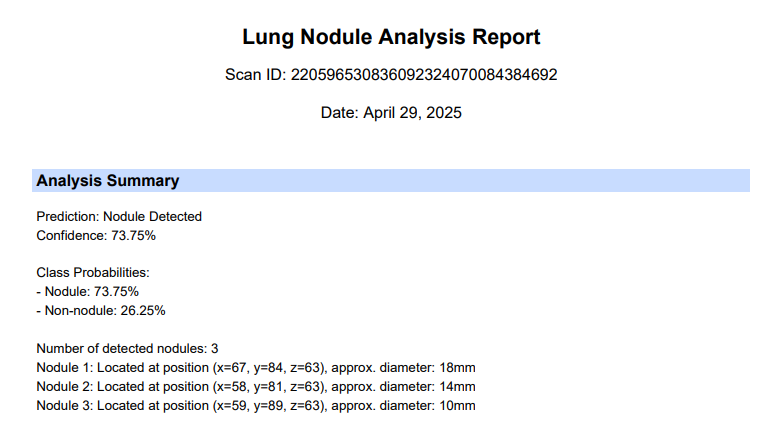

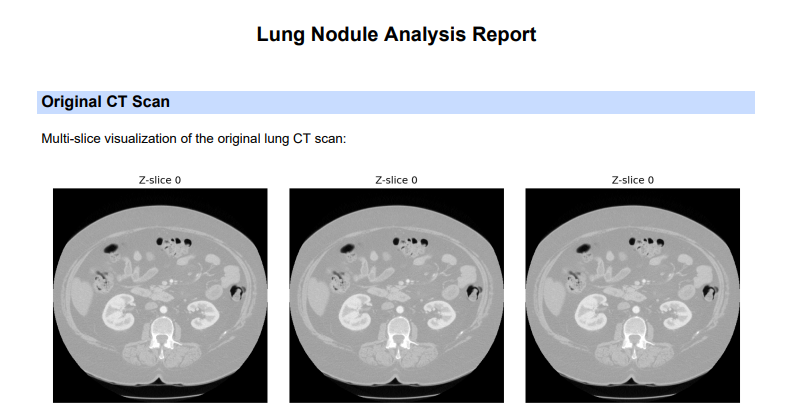

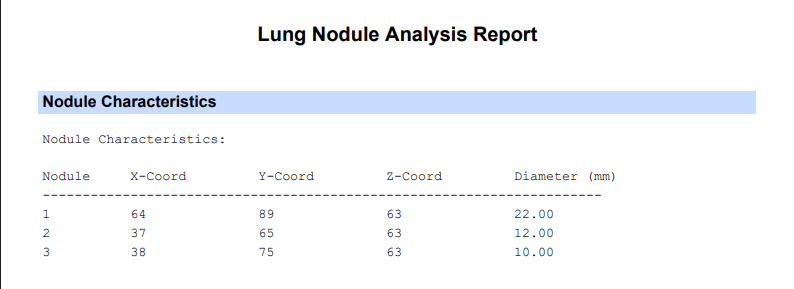

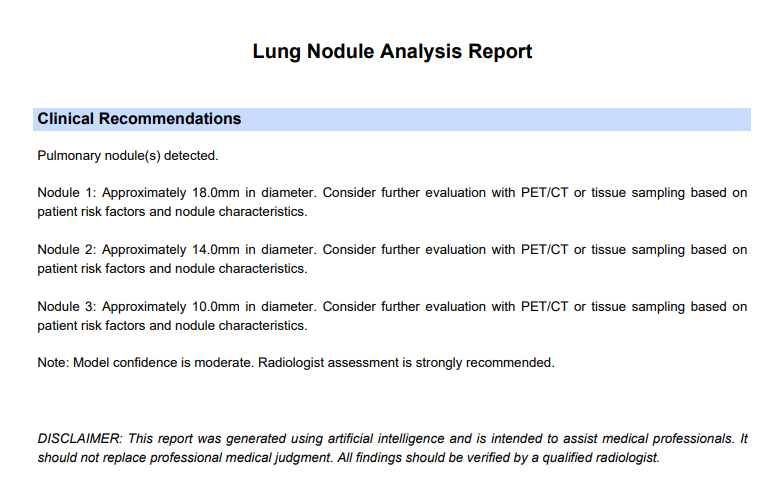

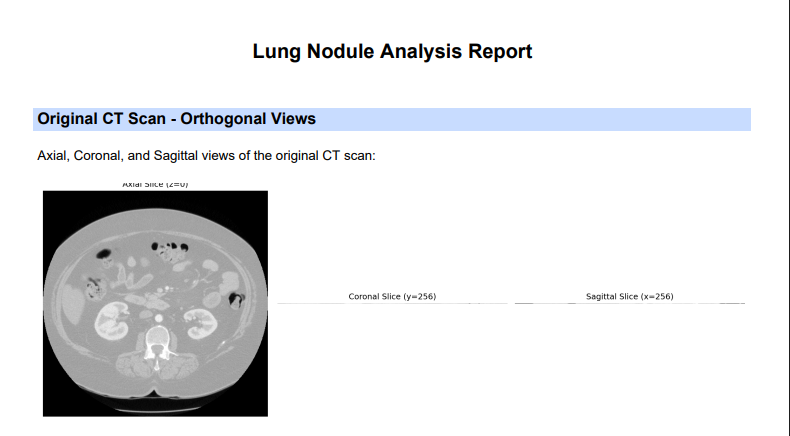

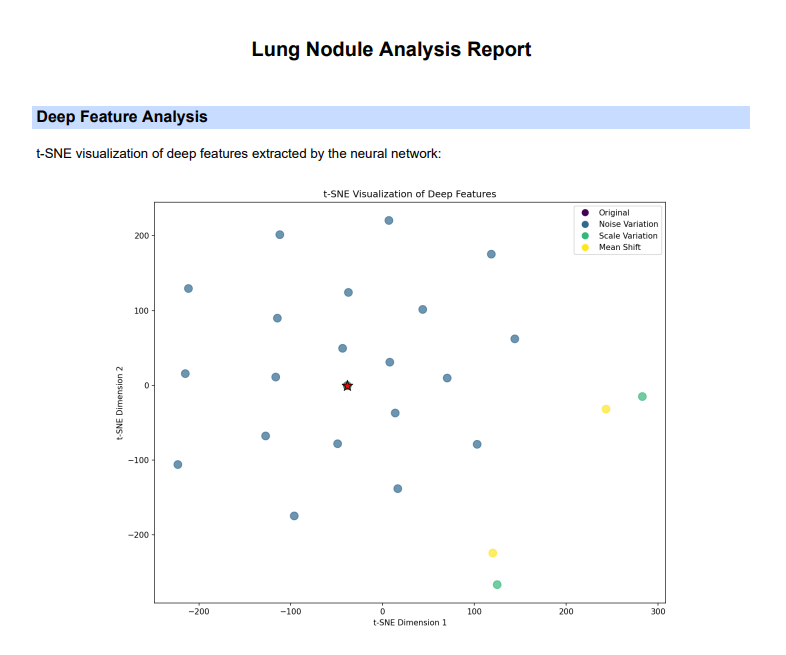

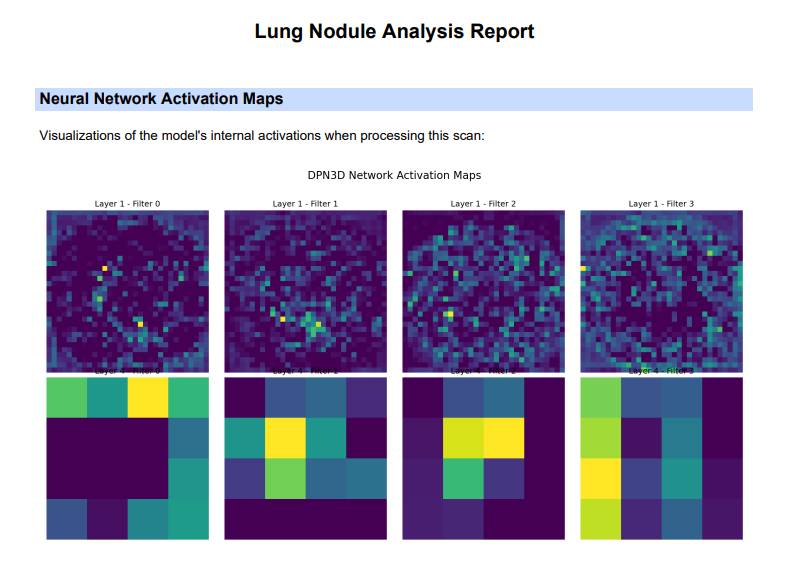